✅ Modelos No Supervisados para Detección de Anomalías
- Z-core
- I1
- Isolation Forest

    Ideal para datos de alta dimensión. Aísla observaciones inusuales más rápidamente.

    Funciona bien con conjuntos de datos desequilibrados (como suelen ser los de anomalías).

    Puedes aplicarlo a todos los clientes o individualmente.

- One-Class SVM

    Aprende una función que encierra la mayoría de los datos normales y detecta lo que está fuera.

    Mejor para datos con un solo tipo de comportamiento "normal".

    Requiere escalar los datos.

- Elliptic Envelope (basado en covarianza robusta)

    Supone que los datos normales siguen una distribución elíptica (gaussiana).

    Rápido y simple, pero sensible a outliers si no se ajusta bien.

- Autoencoders (Redes Neuronales)

    Aprenden a reconstruir los datos normales; una mala reconstrucción sugiere anomalías.

    Potente para relaciones complejas entre variables.

- DBSCAN (si tienes coordenadas o tiempo)

    Detecta puntos fuera de clusters densos.

    Útil si hay una componente temporal o espacial.
- LOF  (Local Outlier Factor) es un algoritmo de detección de anomalías no supervisado que mide el grado de “rareza” de un punto comparándolo con sus vecinos. Fue diseñado para identificar outliers locales, es decir, puntos que son anómalos respecto a su vecindad, aunque no lo parezcan en el conjunto global.

presión [bar], temperatura [°C] y volumen de gas [m3].

#### Variables
- Masa del gas
- Densidad
- Caudal masico
- Energía entregada

## Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Configuración general de estilo
sns.set(style="whitegrid")

## Carga de datos

Debido a que todos los clientes poseen las mismas dimensiones se procede entonces a generar un df estandarizado para aglomerar toda la informacion y revisarla de forma general y particular por cliente

In [11]:
# Carga de datos y concatenación en un df
path = r'D:\MIAD\GIT\proyecto_aplicado\optigas-contugas\data\raw\Datos.xlsx'
df = pd.concat( [df.assign(**{'Cliente': sheet_name}) for sheet_name, df in pd.read_excel(path, sheet_name=None).items()], ignore_index=True)
df['Fecha'] = pd.to_datetime(df['Fecha'])
df.head()

Fecha    Presion  Temperatura    Volumen   Cliente
0 2019-01-14 00:00:00  17.732563    28.209354  20.969751  CLIENTE1
1 2019-01-14 01:00:00  17.747776    28.518614  17.845739  CLIENTE1
2 2019-01-14 02:00:00  17.758916    28.230191  20.975914  CLIENTE1
3 2019-01-14 03:00:00  17.727940    27.811509  20.592299  CLIENTE1
4 2019-01-14 04:00:00  17.746484    27.795293  21.690626  CLIENTE1

## Analisis exploratorio de datos

In [12]:
# Definir la función para graficar distribuciones de un cliente
def graficar_distribuciones_por_cliente(data, cliente, color, variables=['Presion', 'Temperatura', 'Volumen']):
    """
    Grafica las distribuciones de las variables operativas para un cliente específico.

    Args:
        data (DataFrame): El DataFrame con los datos consolidados.
        cliente (str): El identificador del cliente.
        variables (list): Lista de nombres de las variables a graficar.
    """
    cliente_data = data[data['Cliente'] == cliente]
    plt.figure(figsize=(12, 4))

    for i, var in enumerate(variables, 1):
        plt.subplot(1, len(variables), i)
        sns.histplot(cliente_data[var], kde=True, bins=30, color=color)
        plt.title(f"Distribución de {var} - Cliente: {cliente}")
        plt.xlabel(var)
        plt.ylabel("Frecuencia")

    plt.tight_layout()
    plt.show()

### 1. Evaluación de la Calidad de los Datos

#### Completitud

Para evaluar la completitud se presente observar:
- Valores nulos
- Valores duplicados
- Valores de 0 en cada columna
- Fechas faltantes por cliente

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847960 entries, 0 to 847959
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Fecha        847960 non-null  datetime64[ns]
 1   Presion      847960 non-null  float64       
 2   Temperatura  847960 non-null  float64       
 3   Volumen      847960 non-null  float64       
 4   Cliente      847960 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 32.3+ MB


In [14]:
registros_por_cliente = df.groupby('Cliente').size()
df_registros = registros_por_cliente.reset_index(name='Total_Registros')
df_registros = df_registros.sort_values('Total_Registros', ascending=False)
display(df_registros)

Cliente  Total_Registros
15   CLIENTE5            43415
5   CLIENTE14            43415
0    CLIENTE1            43412
8   CLIENTE17            43412
18   CLIENTE8            43147
7   CLIENTE16            43147
12  CLIENTE20            42808
16   CLIENTE6            42808
19   CLIENTE9            42428
6   CLIENTE15            42428
10  CLIENTE19            42305
14   CLIENTE4            42305
2   CLIENTE11            42248
13   CLIENTE3            42248
17   CLIENTE7            41776
3   CLIENTE12            41776
11   CLIENTE2            41382
9   CLIENTE18            41382
1   CLIENTE10            41059
4   CLIENTE13            41059

##### Valores nulos

In [15]:
#  Verificar valores nulos por columna
print("\nCantidad de valores nulos por columna:")
print(df.isnull().sum())


Cantidad de valores nulos por columna:
Fecha          0
Presion        0
Temperatura    0
Volumen        0
Cliente        0
dtype: int64


##### Valores duplicados

In [16]:
# Valores duplicados
print(df[df.duplicated()])

Empty DataFrame
Columns: [Fecha, Presion, Temperatura, Volumen, Cliente]
Index: []


##### Fechas faltantes por cliente

Total de registros faltantes: 22294


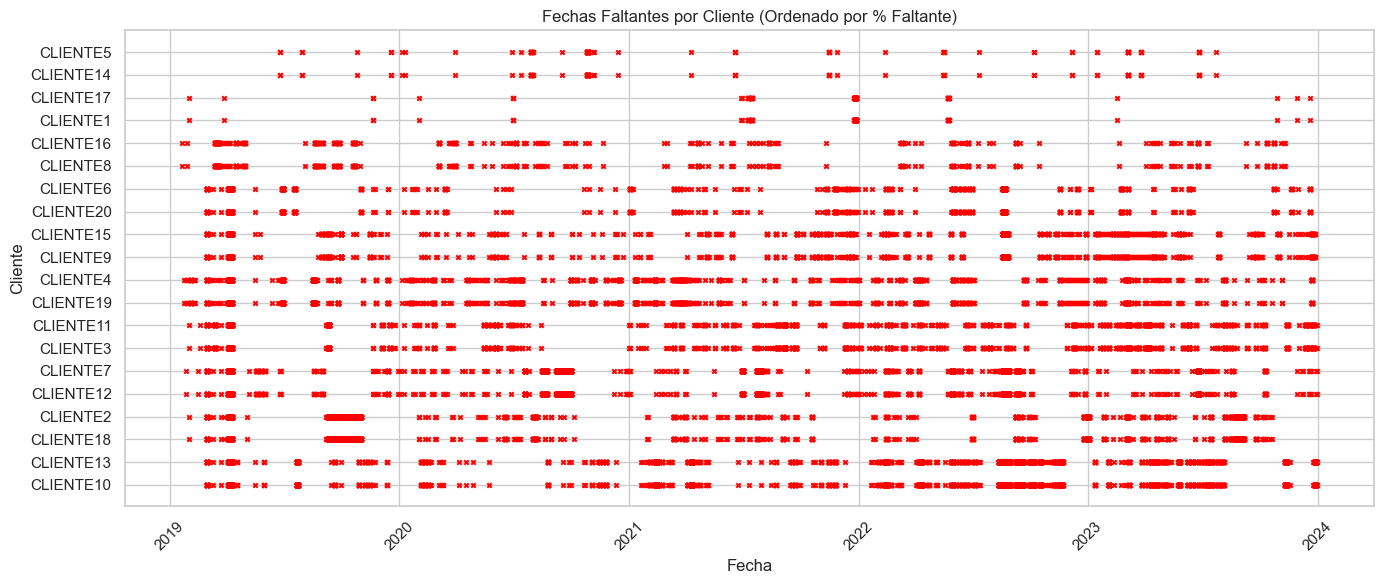

In [17]:
# Inicializar diccionarios
missing_data = {}
missing_percentage = {}

# Agrupar por cliente
for cliente, grupo in df.groupby('Cliente'):
    # Rango de fechas
    fecha_inicio = grupo['Fecha'].min()
    fecha_fin = grupo['Fecha'].max()
    
    # Fechas esperadas por hora
    fechas_completas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='h')
    fechas_cliente = pd.to_datetime(grupo['Fecha'].values)
    
    # Fechas faltantes
    fechas_faltantes = set(fechas_completas) - set(fechas_cliente)
    
    # Guardar fechas faltantes
    missing_data[cliente] = list(fechas_faltantes)
    
    # Calcular porcentaje
    porcentaje = len(fechas_faltantes) / len(fechas_completas) * 100
    missing_percentage[cliente] = porcentaje

# Mostrar porcentaje de datos faltantes por cliente
missing_percent_df = pd.DataFrame.from_dict(missing_percentage, orient='index', columns=['% Faltante'])
#display(missing_percent_df.sort_values('% Faltante', ascending=False))

# Calcular total de registros faltantes
total_faltantes = sum(len(fechas) for fechas in missing_data.values())
print(f"Total de registros faltantes: {total_faltantes}")

# Ordenar los clientes por % de faltantes (de mayor a menor)
clientes_ordenados = missing_percent_df.sort_values('% Faltante', ascending=False).index.tolist()

# Graficar fechas faltantes con orden personalizado en eje Y
plt.figure(figsize=(14, 6))
for cliente in clientes_ordenados:
    fechas_faltantes = missing_data.get(cliente, [])
    if fechas_faltantes:
        plt.scatter(fechas_faltantes, [cliente] * len(fechas_faltantes), color='red', marker='x', s=10)

plt.xlabel('Fecha')
plt.ylabel('Cliente')
plt.title('Fechas Faltantes por Cliente (Ordenado por % Faltante)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
# Crear DataFrame con número de registros faltantes
missing_counts = {cliente: len(fechas) for cliente, fechas in missing_data.items()}

# Unir todo en un solo DataFrame
completitud_df = pd.DataFrame.from_dict(missing_counts, orient='index', columns=['Registros_Faltantes'])
completitud_df['% Faltante'] = pd.Series(missing_percentage)

# Ordenar y mostrar
completitud_df = completitud_df.sort_values('% Faltante', ascending=False)
display(completitud_df)

Registros_Faltantes  % Faltante
CLIENTE10                 2453    5.637525
CLIENTE13                 2453    5.637525
CLIENTE18                 2135    4.906692
CLIENTE2                  2135    4.906692
CLIENTE12                 1736    3.989704
CLIENTE7                  1736    3.989704
CLIENTE3                  1265    2.907244
CLIENTE11                 1265    2.907244
CLIENTE19                 1207    2.773947
CLIENTE4                  1207    2.773947
CLIENTE9                  1084    2.491267
CLIENTE15                 1084    2.491267
CLIENTE20                  704    1.617944
CLIENTE6                   704    1.617944
CLIENTE8                   366    0.841147
CLIENTE16                  366    0.841147
CLIENTE1                   100    0.229822
CLIENTE17                  100    0.229822
CLIENTE14                   97    0.222927
CLIENTE5                    97    0.222927

In [19]:
lista_pares_organizados = completitud_df.index.tolist()

##### Valores de 0

In [20]:
# Verificación de la existencia de valores de 0 por columna y por cliente
cols_numericas = df.select_dtypes(include='number').columns
df_val_cero = df.groupby('Cliente')[cols_numericas].apply(lambda x: (x == 0).sum())
total_por_cliente = df.groupby('Cliente').size()
# Calcular % de ceros en Volumen
df_val_cero['% reg. Vol. igual a 0'] = df_val_cero['Volumen'] / total_por_cliente * 100
df_val_cero = df_val_cero.sort_values(by='% reg. Vol. igual a 0', ascending=False)
df_val_cero


Presion  Temperatura  Volumen  % reg. Vol. igual a 0
Cliente                                                        
CLIENTE9         0            0    37386              88.116338
CLIENTE10        0            0    35923              87.491171
CLIENTE15        0            0    36834              86.815311
CLIENTE13        0            0    35418              86.261234
CLIENTE19        0            0    33128              78.307529
CLIENTE4         0            0    29973              70.849781
CLIENTE12        0            0    23072              55.227882
CLIENTE7         0            0    21754              52.072961
CLIENTE5         0            0     7491              17.254405
CLIENTE14        0            0     4237               9.759300
CLIENTE6         0            0     1907               4.454775
CLIENTE20        0            0     1256               2.934031
CLIENTE8         0            0      839               1.944515
CLIENTE1         0            0      614               1.414355
CLIENTE16        0            0      389               0.901569
CLIENTE18        0            0      184               0.444638
CLIENTE2         0            0      141               0.340728
CLIENTE17        0            0       65               0.149728
CLIENTE3         0            0       41               0.097046
CLIENTE11        0            0        8               0.018936

In [21]:
# Extracción de datos con volumen igual a 0
df_vol_cero = df[(df['Volumen'] == 0)].copy()
# Extracción de datos con volumen diferente a 0
df_vol_dif_cero = df[(df['Volumen'] != 0)].copy()
print(f"Datos con valores de volumen igual a 0: {len(df_vol_cero)}")

Datos con valores de volumen igual a 0: 270660


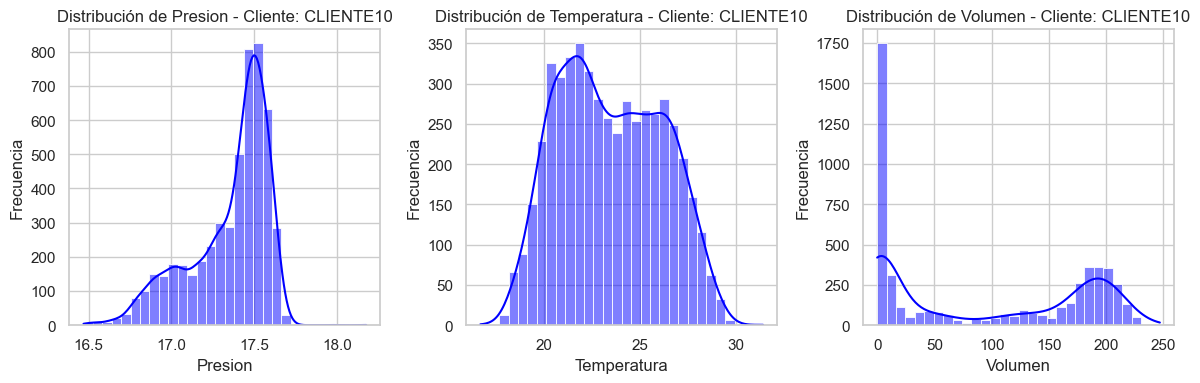

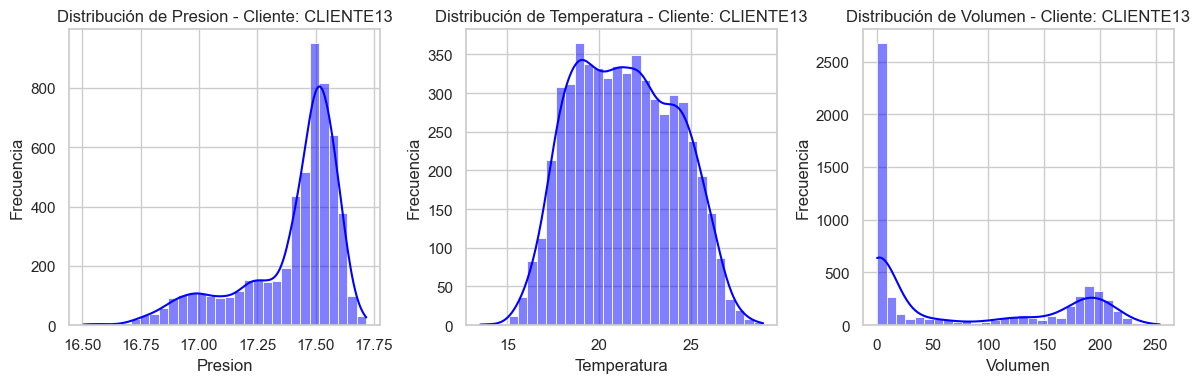

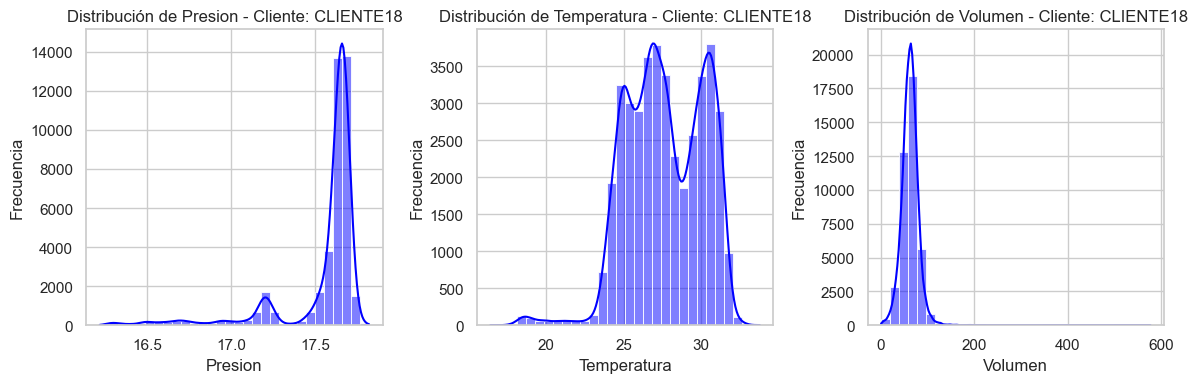

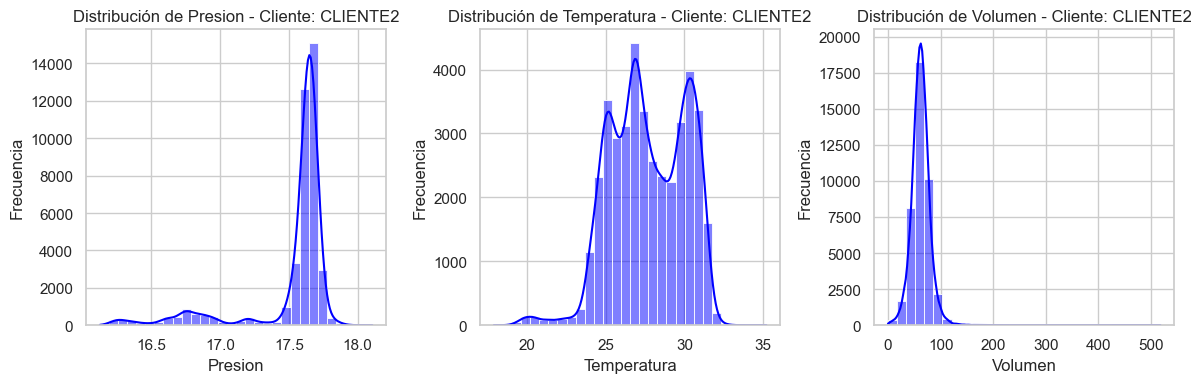

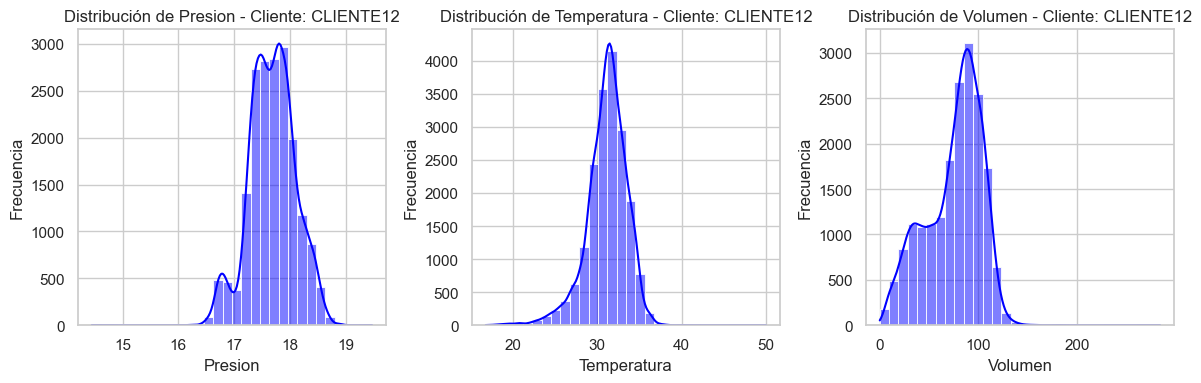

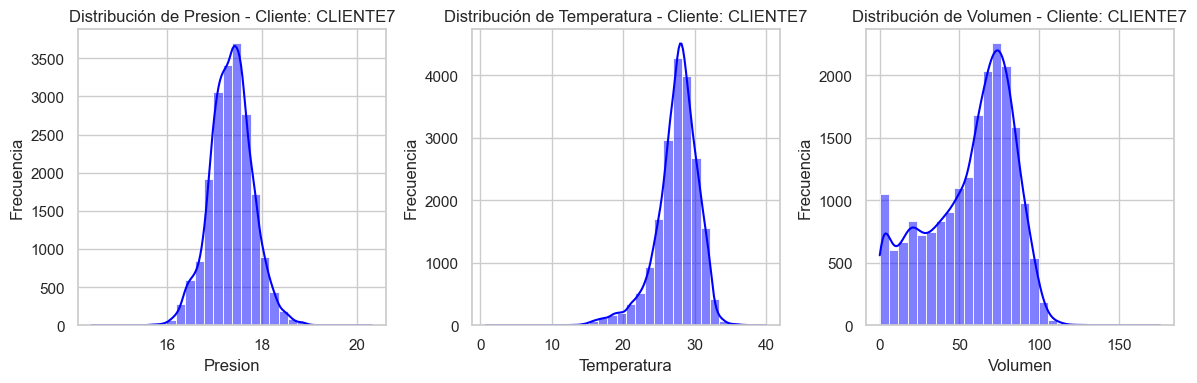

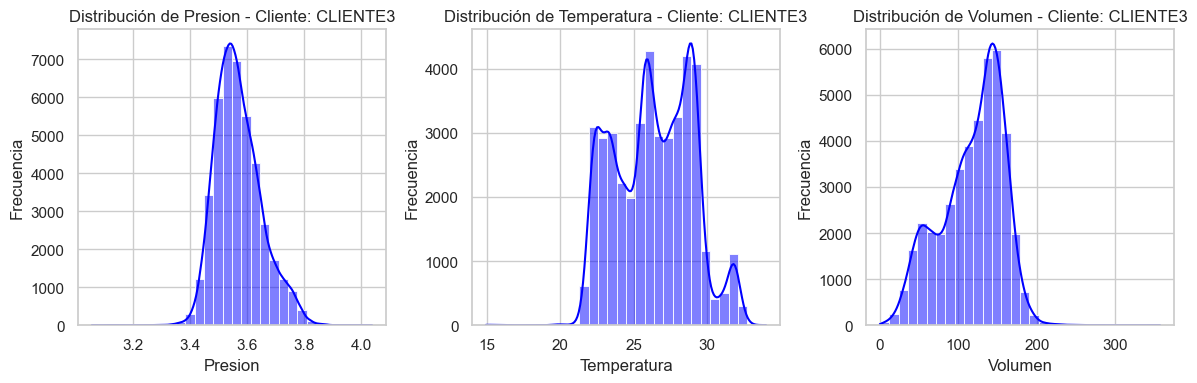

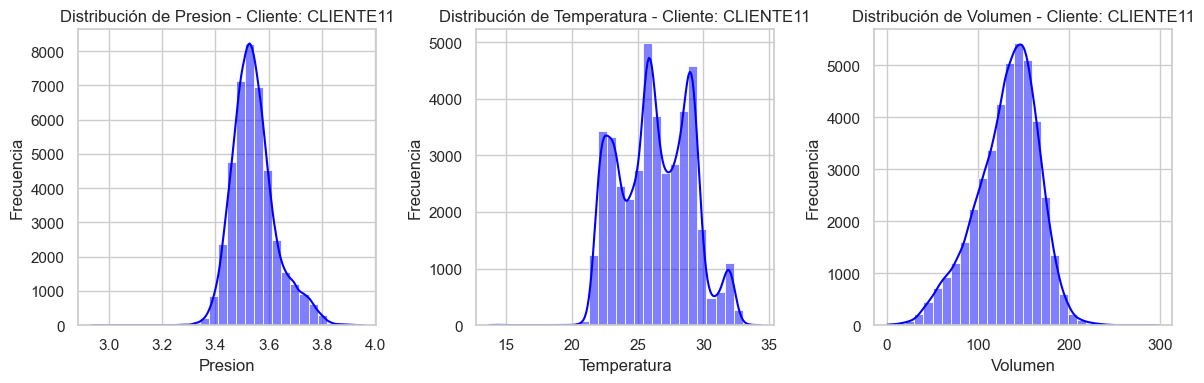

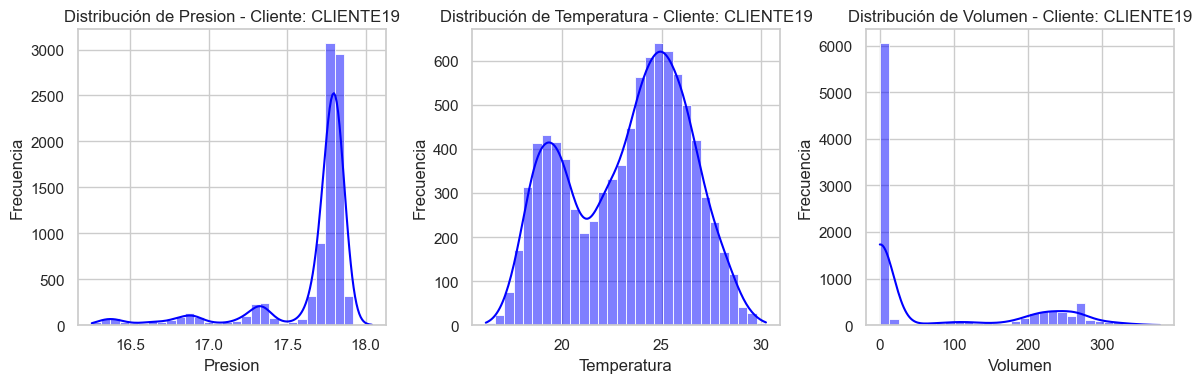

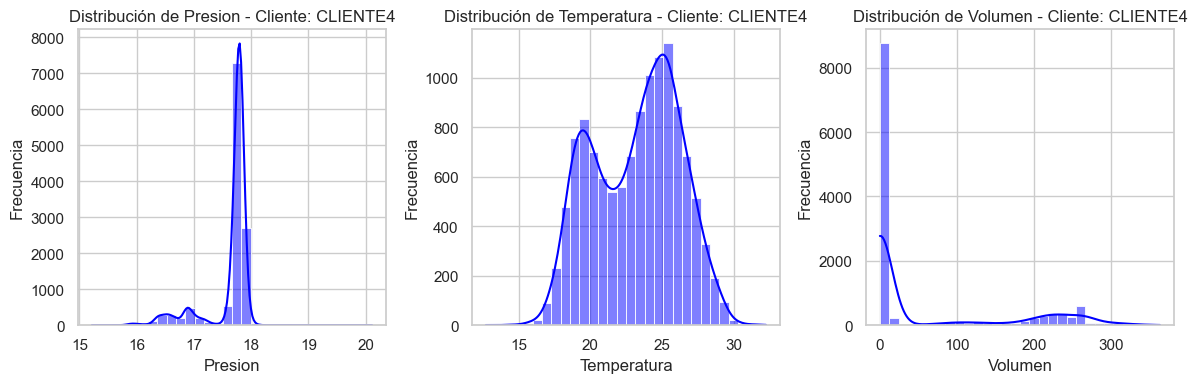

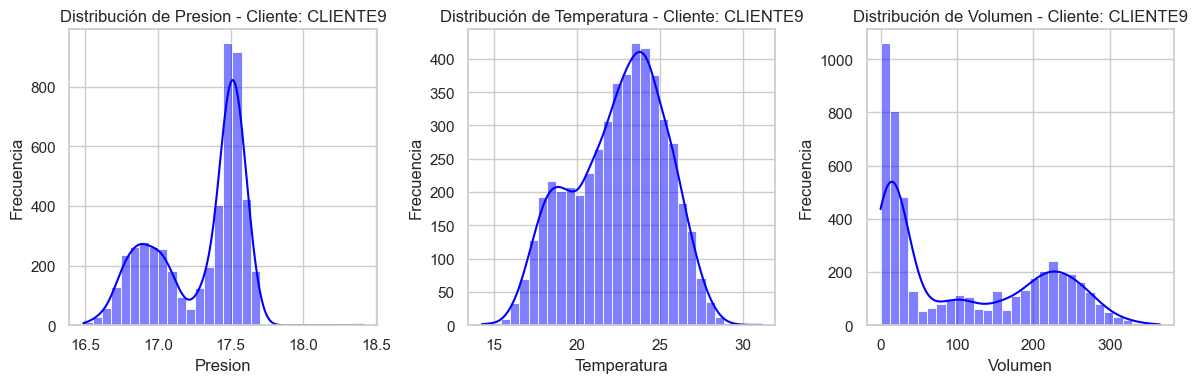

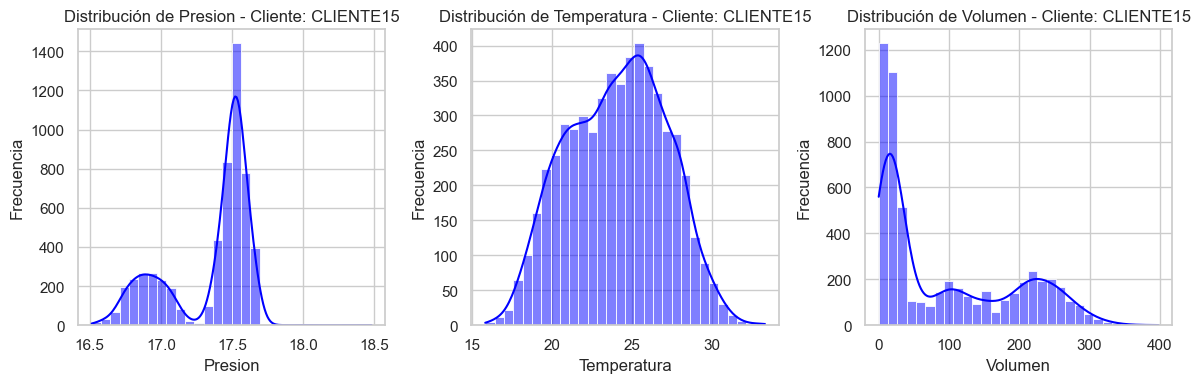

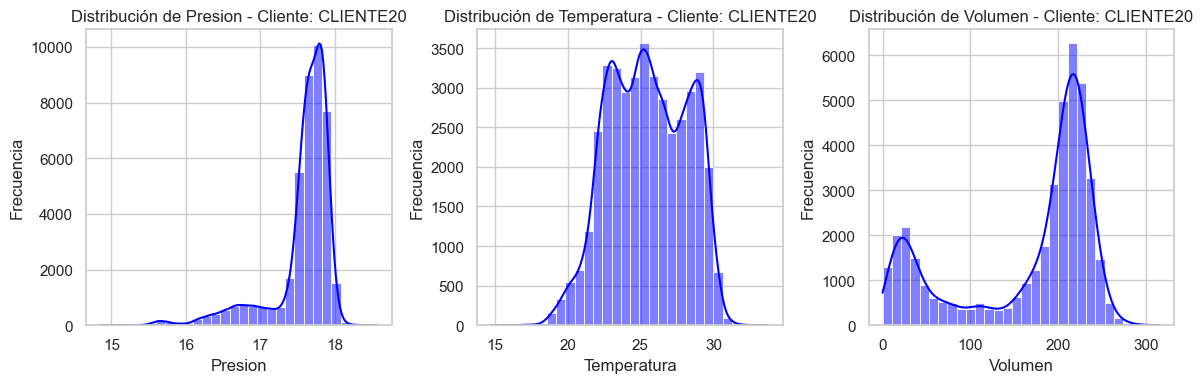

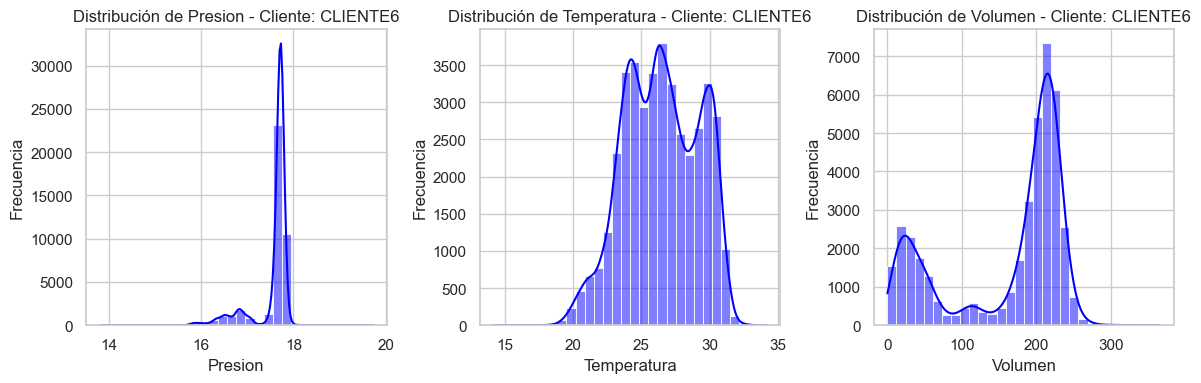

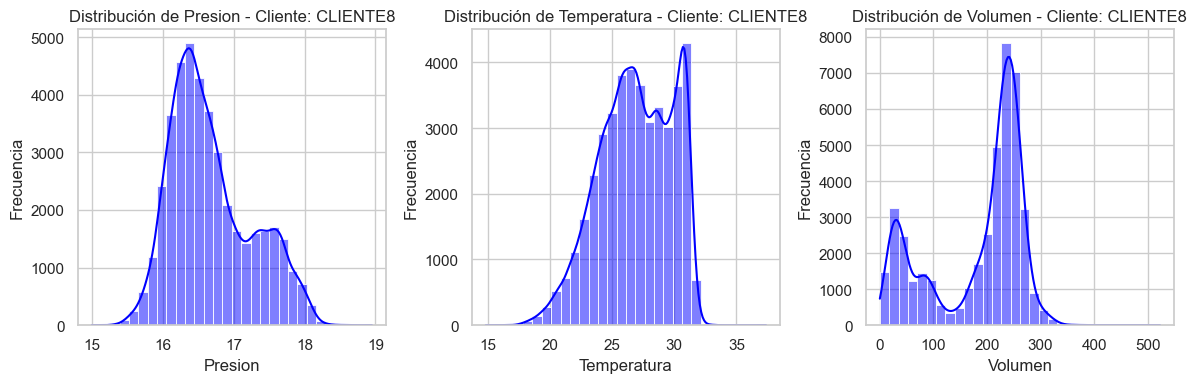

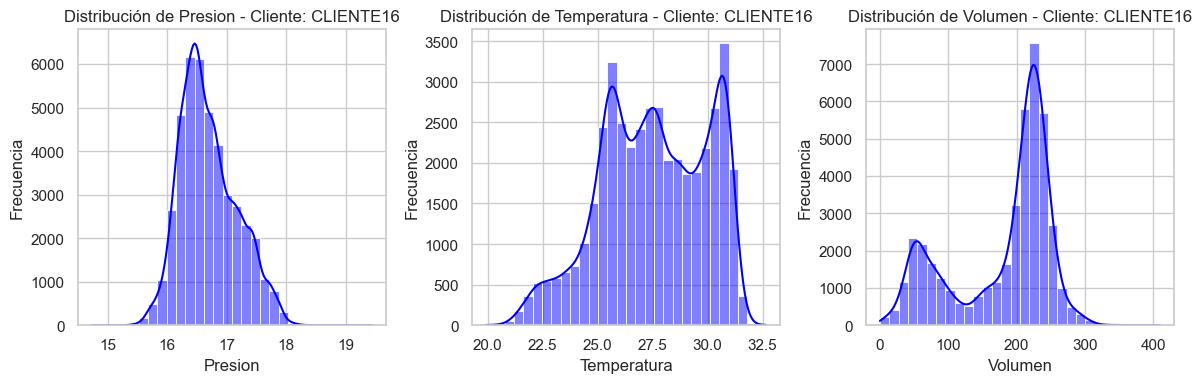

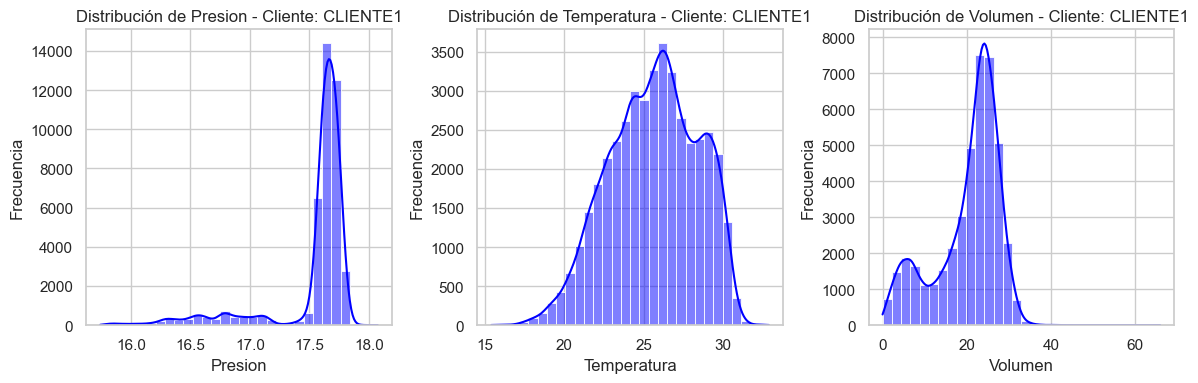

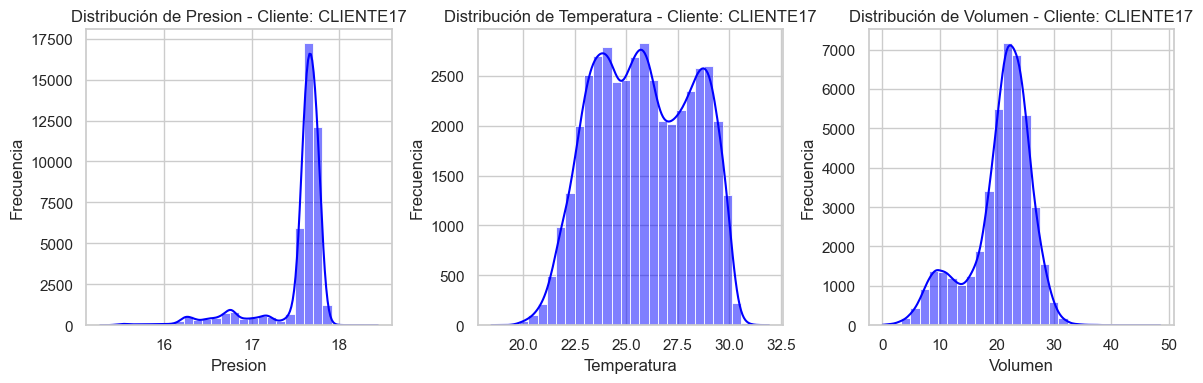

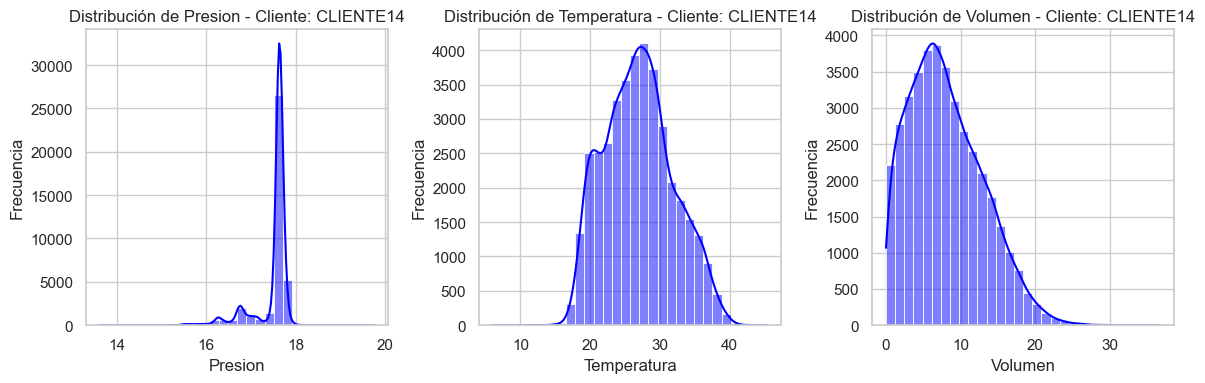

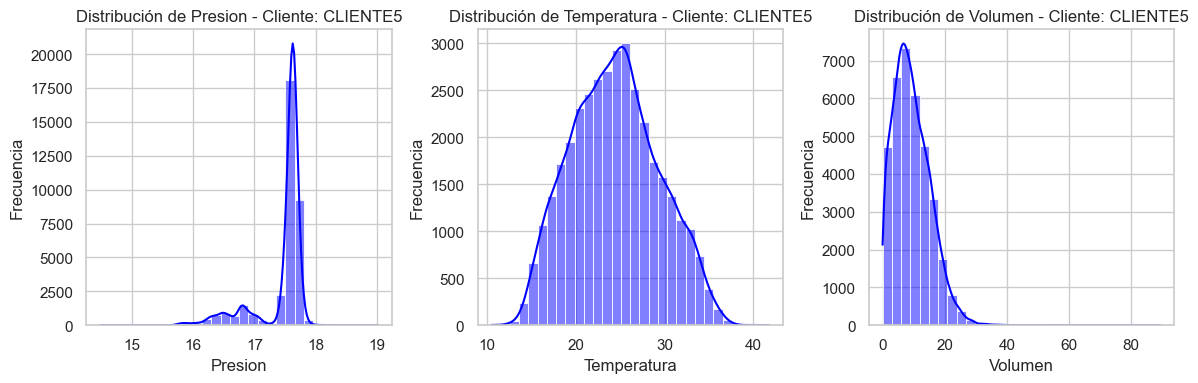

In [22]:
# Histogramas de datos de volumen diferente a 0
variables = ['Presion', 'Temperatura', 'Volumen']

# Distribución de 
for cliente in lista_pares_organizados:
    graficar_distribuciones_por_cliente(df_vol_dif_cero, cliente, "blue", variables)

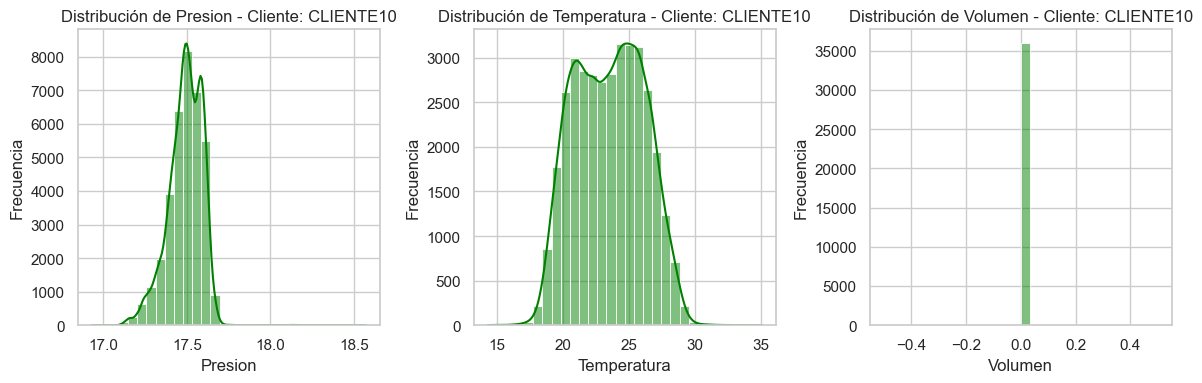

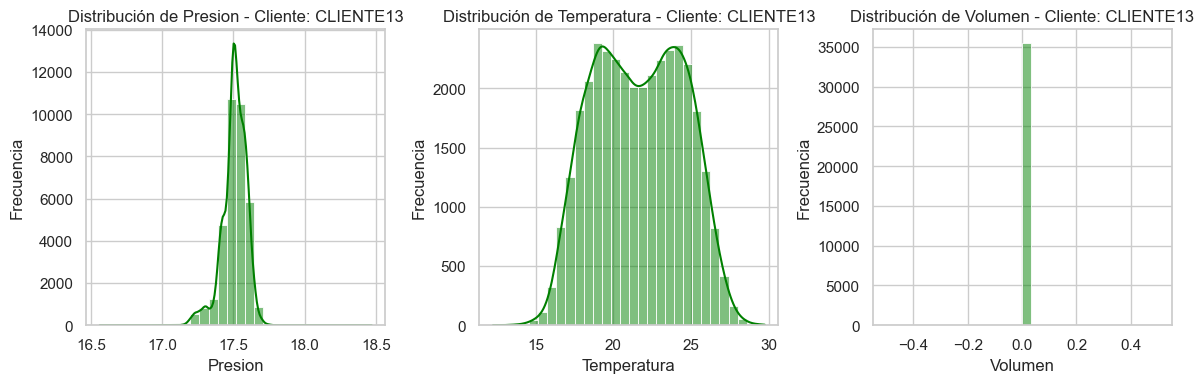

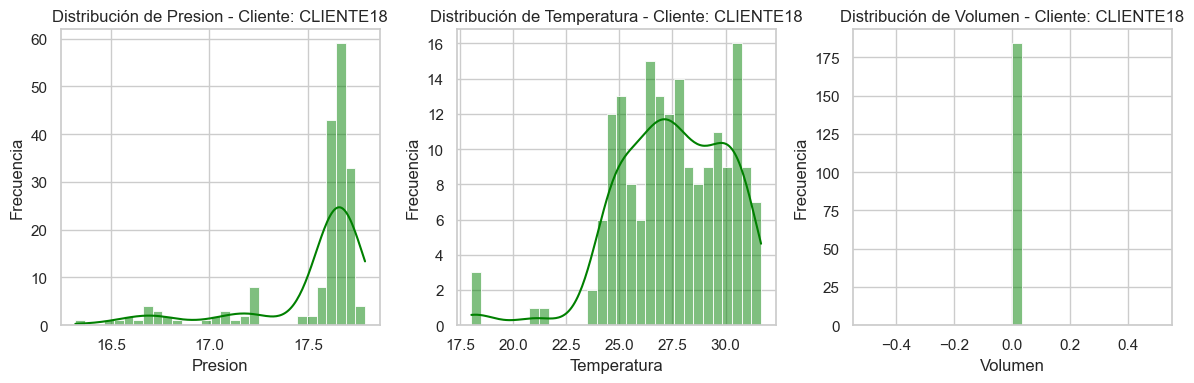

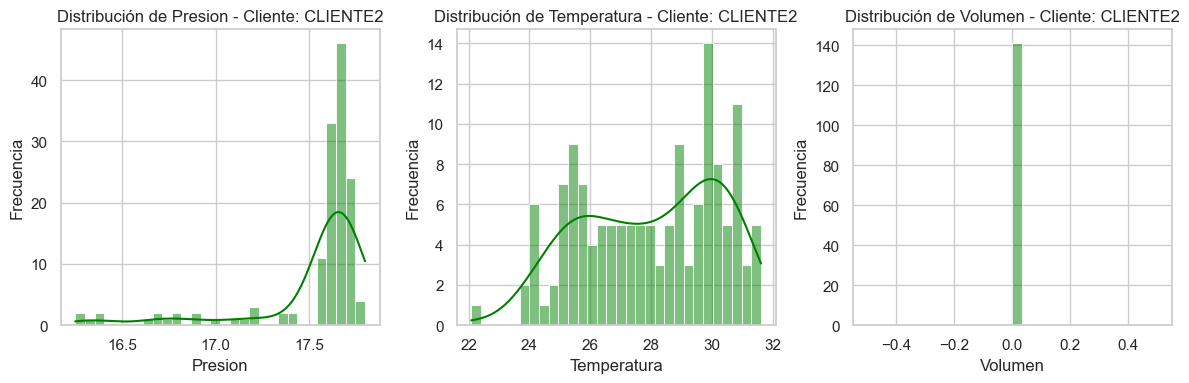

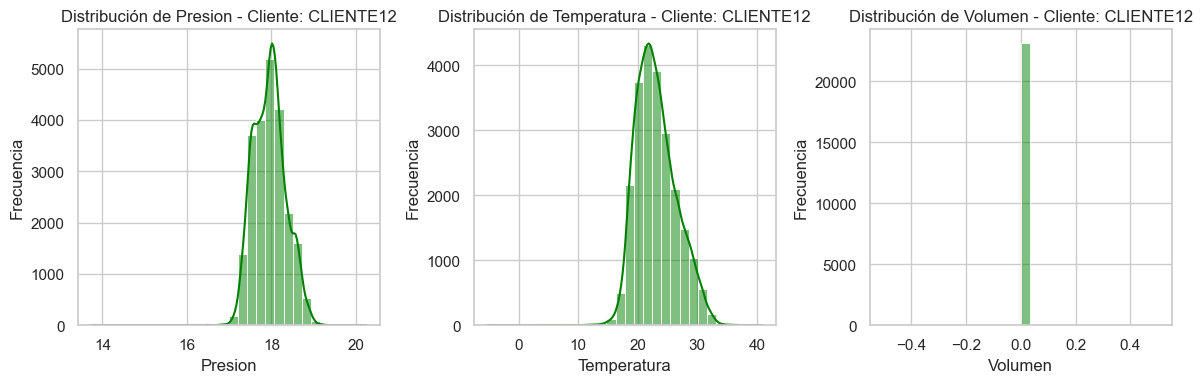

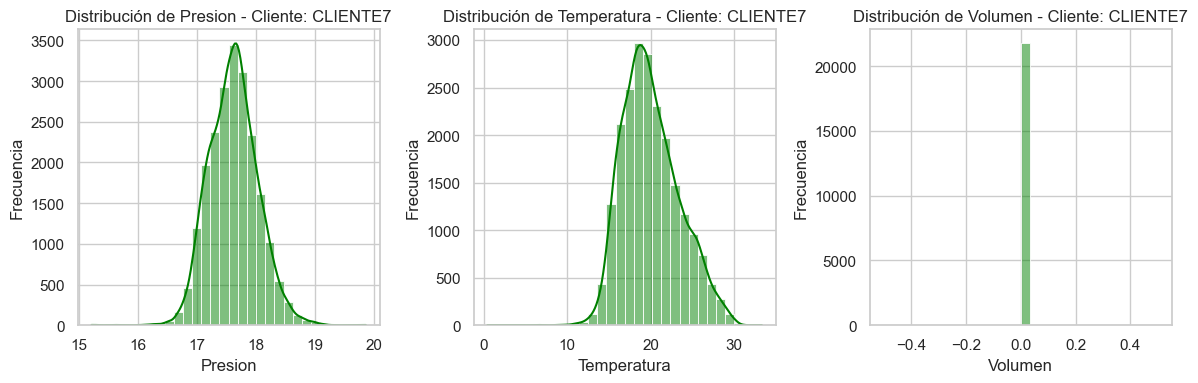

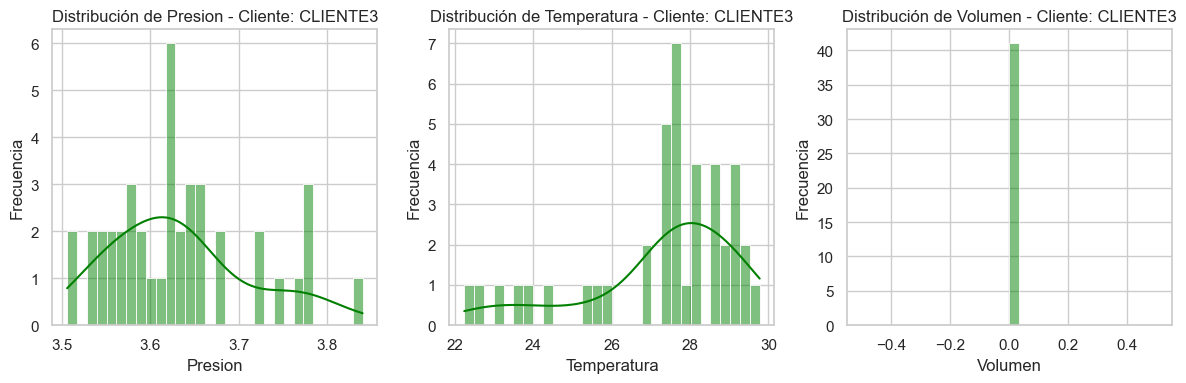

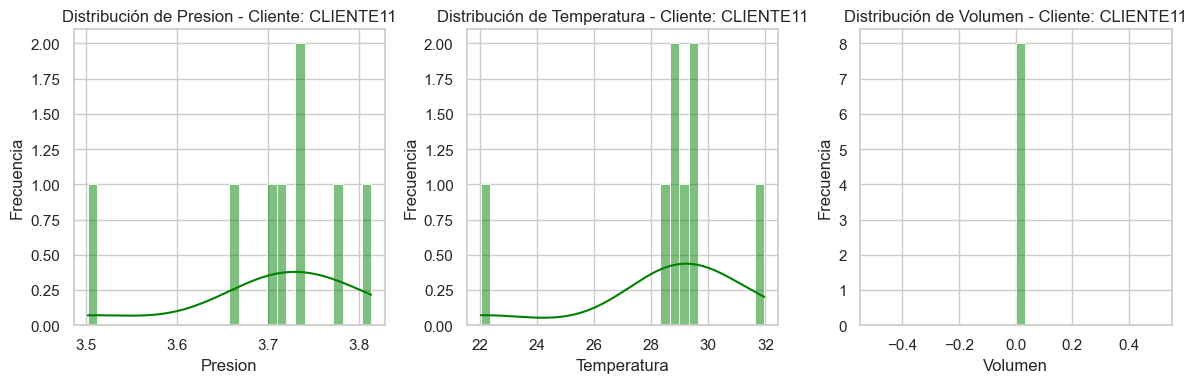

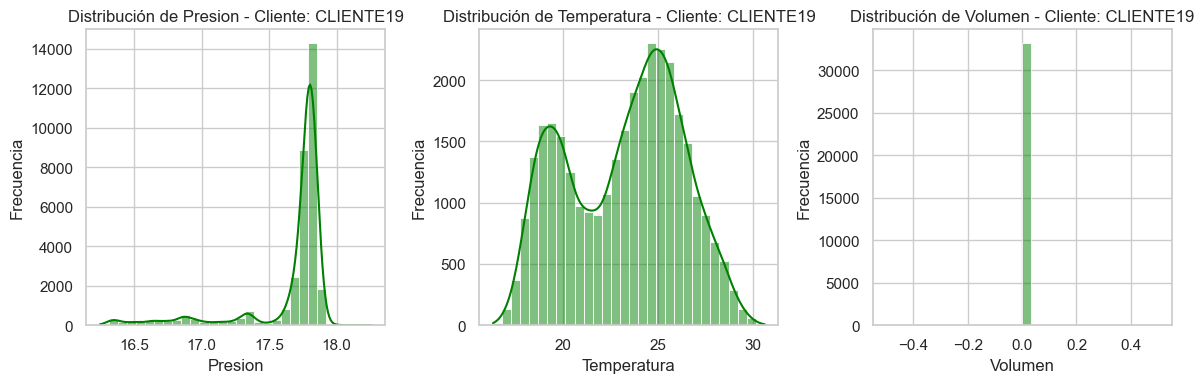

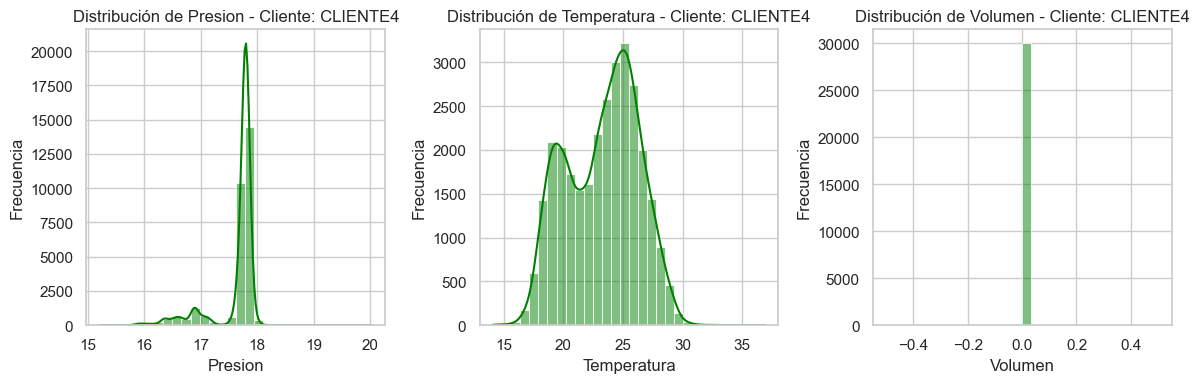

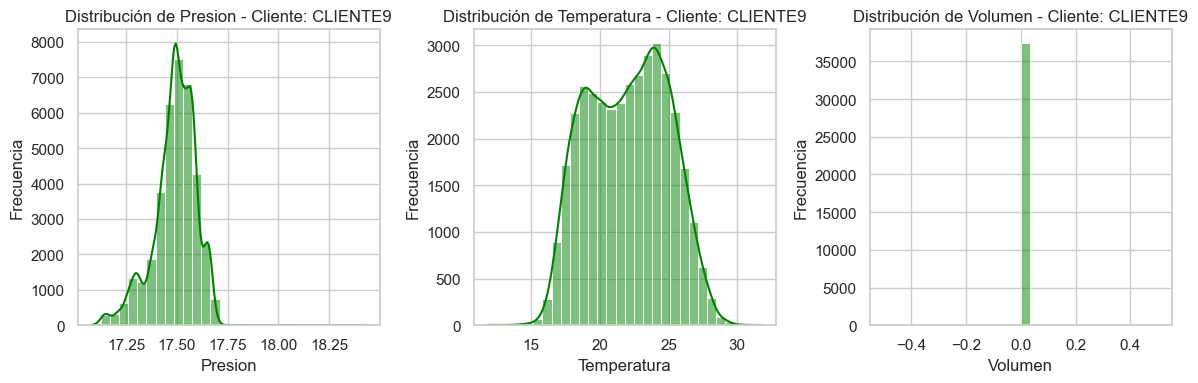

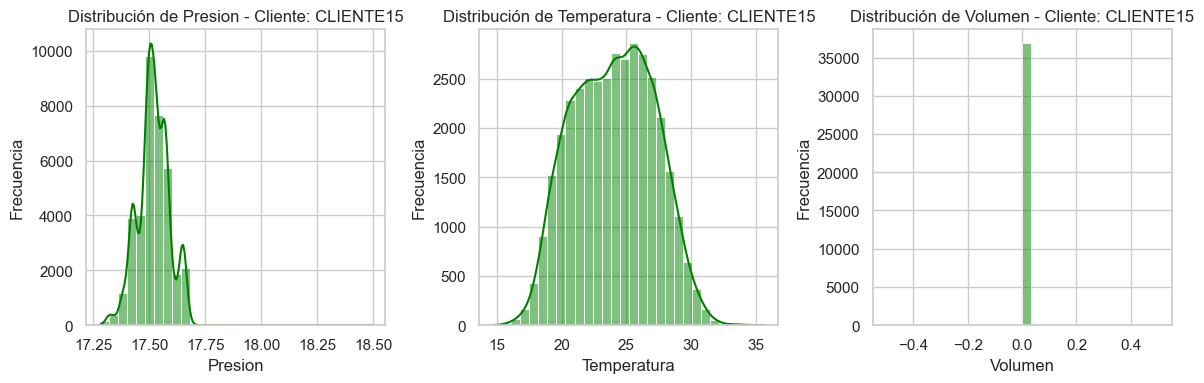

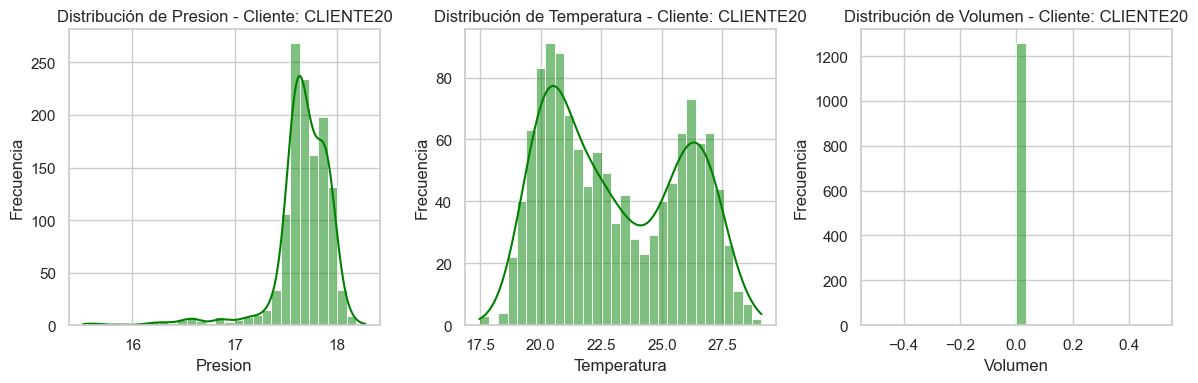

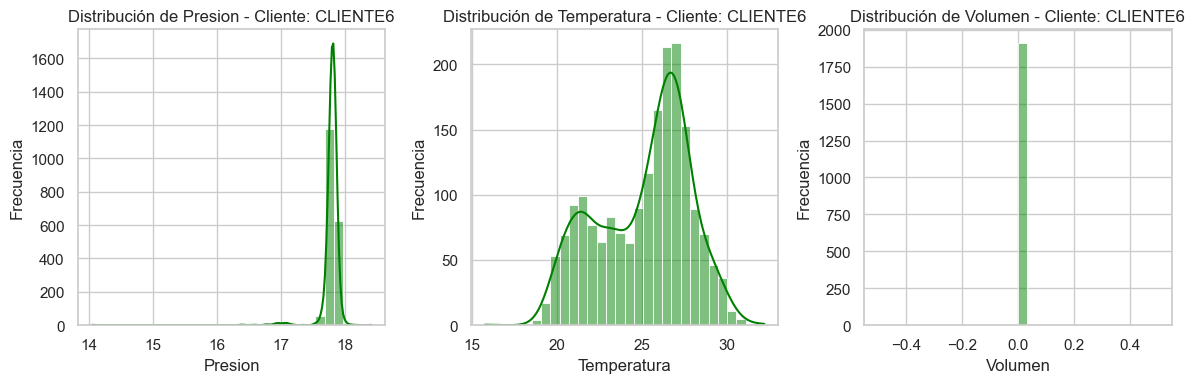

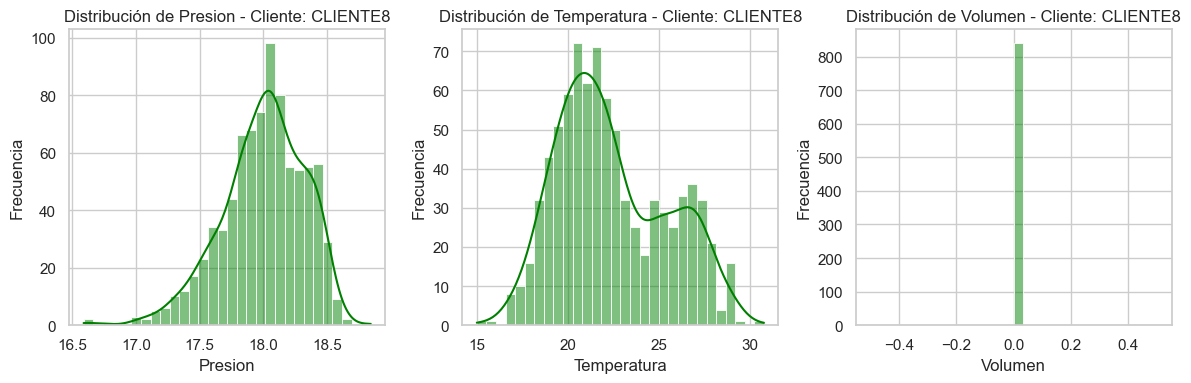

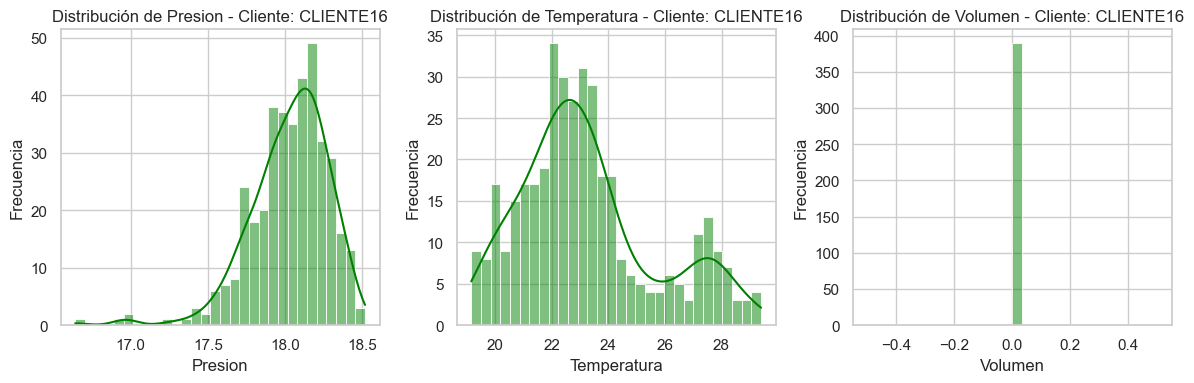

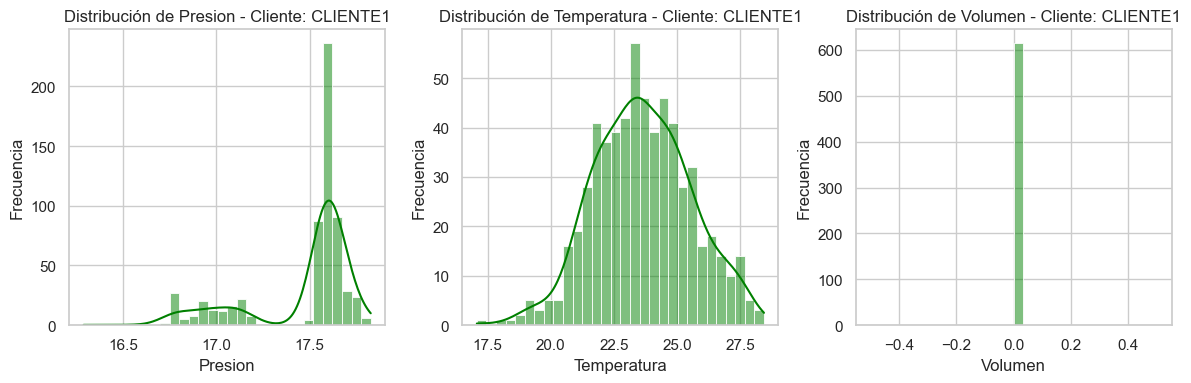

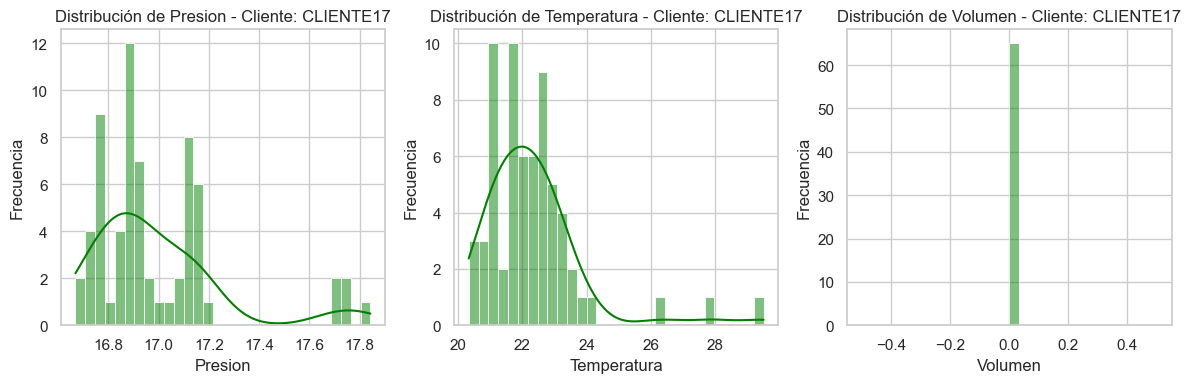

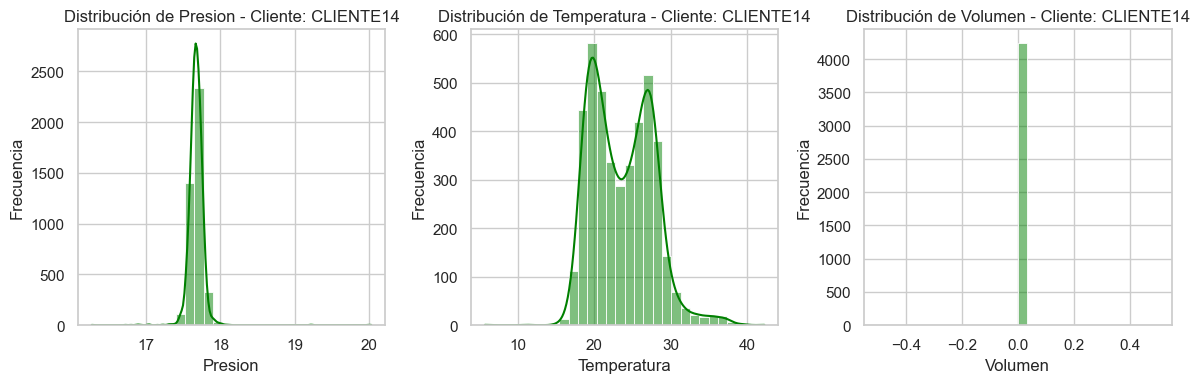

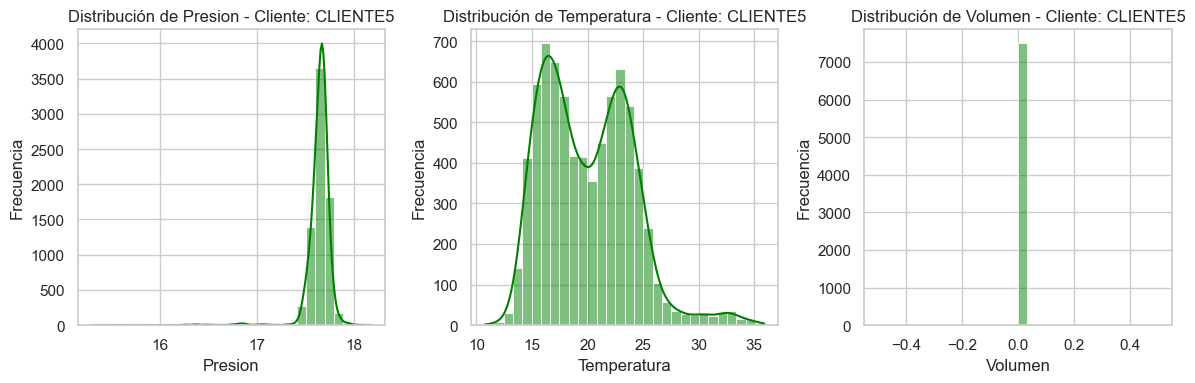

In [23]:
# Histogramas de datos de volumen igual a 0
variables = ['Presion', 'Temperatura', 'Volumen']
for cliente in lista_pares_organizados:
    graficar_distribuciones_por_cliente(df_vol_cero, cliente, "green", variables)

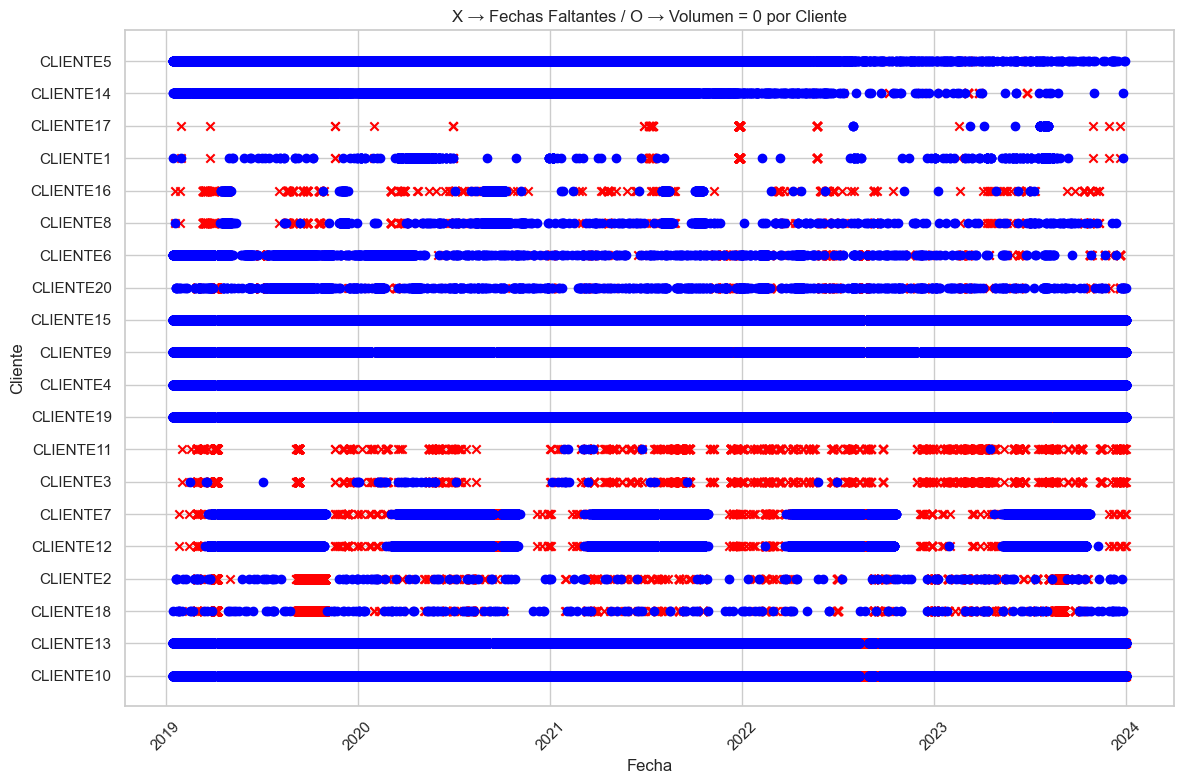

In [24]:
# Grafico datos con 0 y datos faltantes
# Inicializar un diccionario para almacenar los resultados
missing_data = {}
volume_zero_data = {}

# Agrupar por cliente
for cliente, grupo in df.groupby('Cliente'):
    # Obtener el rango de fechas para cada cliente (desde la más temprana hasta la más reciente)
    fecha_inicio = grupo['Fecha'].min()
    fecha_fin = grupo['Fecha'].max()
    
    # Crear una serie de fechas completas por hora entre el inicio y el fin de este cliente
    fechas_completas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='h')
    
    # Obtener las fechas disponibles para este cliente
    fechas_cliente = grupo['Fecha'].values
    
    # Identificar las fechas faltantes
    fechas_faltantes = set(fechas_completas) - set(fechas_cliente)
    
    # Identificar las fechas donde el volumen es 0
    fechas_volumen_0 = grupo[grupo['Volumen'] == 0]['Fecha'].values
    
    # Almacenar los resultados
    missing_data[cliente] = list(fechas_faltantes)
    volume_zero_data[cliente] = list(fechas_volumen_0)

# Graficar las fechas faltantes y las fechas con volumen 0
plt.figure(figsize=(12, 8))

# Graficar fechas faltantes (x rojas)
for cliente in lista_pares_organizados :
    fechas_faltantes = missing_data.get(cliente, [])
    if fechas_faltantes:
        plt.scatter(fechas_faltantes, [cliente] * len(fechas_faltantes), color='red', marker='x', label=f'Faltantes - {cliente}')

# Graficar volumen 0 (o azules)
for cliente in lista_pares_organizados :
    fechas_volumen_0 = volume_zero_data.get(cliente, [])
    if fechas_volumen_0:
        plt.scatter(fechas_volumen_0, [cliente] * len(fechas_volumen_0), color='blue', marker='o', label=f'Volumen = 0 - {cliente}')

# Ejes y etiquetas
plt.xlabel('Fecha')
plt.ylabel('Cliente')
plt.title('X → Fechas Faltantes / O → Volumen = 0 por Cliente')
plt.yticks(ticks=lista_pares_organizados)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

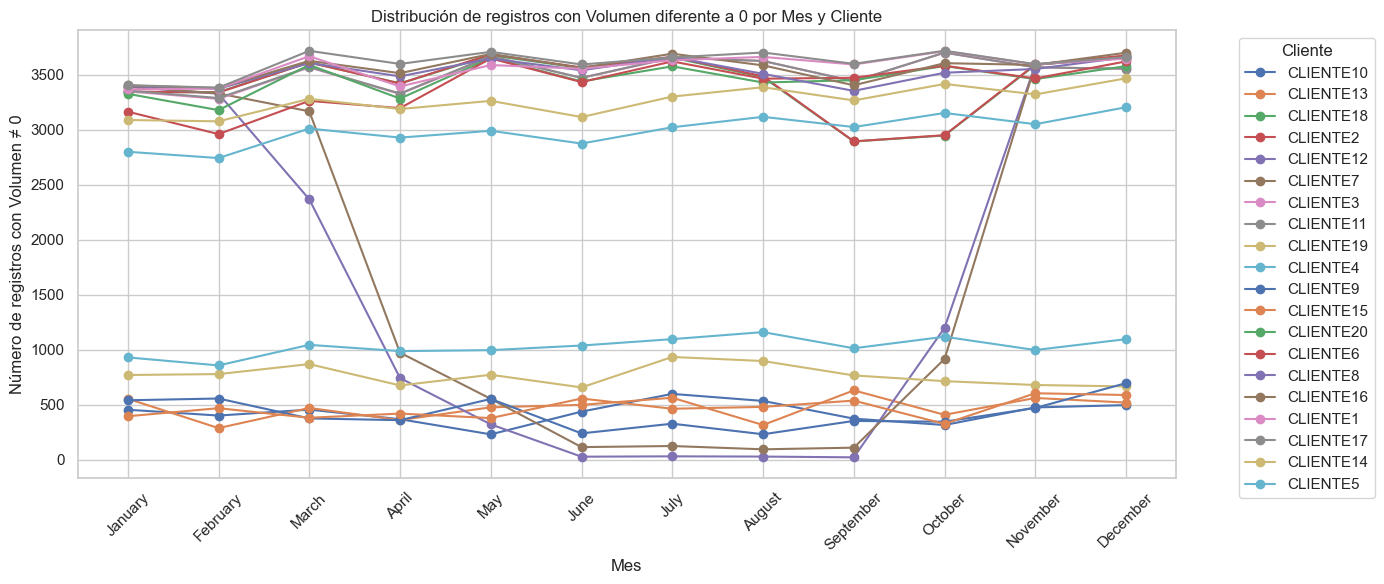

In [25]:
# Grafico de No. registros por mes del volumen diferente a 0
# Extraer el número del mes
df_vol_dif_cero['Mes_num'] = df_vol_dif_cero['Fecha'].dt.month
df_vol_dif_cero['Mes_nombre'] = df_vol_dif_cero['Mes_num'].map({
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
})

# Agrupar por cliente y número de mes
volumen_dif_cero_por_mes = df_vol_dif_cero.groupby(['Cliente', 'Mes_num', 'Mes_nombre']).size().reset_index(name='Conteo')

# Paso 3: Plot con eje X ordenado por número de mes
plt.figure(figsize=(14, 6))
for cliente in lista_pares_organizados:
    datos = volumen_dif_cero_por_mes[volumen_dif_cero_por_mes['Cliente'] == cliente]
    if not datos.empty:
        # Ordenar los datos por Mes_num para que el eje X esté en orden correcto
        datos = datos.sort_values('Mes_num')
        plt.plot(datos['Mes_nombre'], datos['Conteo'], marker='o', label=cliente)

plt.title('Distribución de registros con Volumen diferente a 0 por Mes y Cliente')
plt.xlabel('Mes')
plt.ylabel('Número de registros con Volumen ≠ 0')
plt.xticks(rotation=45)
plt.legend(title='Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [26]:
volumen_dif_cero_por_mes.head(5)

Cliente  Mes_num Mes_nombre  Conteo
0  CLIENTE1        1    January    3368
1  CLIENTE1        2   February    3375
2  CLIENTE1        3      March    3669
3  CLIENTE1        4      April    3394
4  CLIENTE1        5        May    3589

In [27]:
# Crear columna Año-Mes para agrupar
df_vol_cero['AñoMes'] = df_vol_cero['Fecha'].dt.to_period('M')

# Agrupar por Cliente y AñoMes y contar registros
distribucion_cero_mensual = df_vol_cero.groupby(['Cliente', 'AñoMes']).size().unstack(fill_value=0)

# Mostrar resultados
display(distribucion_cero_mensual)

AñoMes     2019-01  2019-02  2019-03  2019-04  2019-05  2019-06  2019-07  \
Cliente                                                                    
CLIENTE1         2        0        0        1        3        3        4   
CLIENTE10      369      530      573      546      689      670      553   
CLIENTE11        0        0        0        0        0        0        0   
CLIENTE12        0        0      221      565      719      705      741   
CLIENTE13      383      623      630      511      658      648      644   
CLIENTE14       60       79       91       77      116      109      125   
CLIENTE15      415      606      676      526      652      603      637   
CLIENTE16        0        0        0       32        9        0        0   
CLIENTE17        0        0        0        0        0        0        0   
CLIENTE18        5        4        3        1        6        2        6   
CLIENTE19      328      517      542      442      614      477      508   
CLIENTE2         3        5        7        0        1        3        6   
CLIENTE20        8        6       30        8        5       15       60   
CLIENTE3         0        1        2        0        0        0        1   
CLIENTE4       279      491      482      428      497      450      551   
CLIENTE5       111      169      178      164      192      197      187   
CLIENTE6       129      196      212      126       17       37       34   
CLIENTE7         0        0       40      566      722      709      744   
CLIENTE8         1        0        0       52       21        0        0   
CLIENTE9       395      612      670      531      647      664      667   

AñoMes     2019-08  2019-09  2019-10  ...  2023-03  2023-04  2023-05  2023-06  \
Cliente                               ...                                       
CLIENTE1         4        4        2  ...        6       16       15       17   
CLIENTE10      574      613      622  ...      641      537      652      637   
CLIENTE11        0        0        0  ...        0        1        0        0   
CLIENTE12      720      713      639  ...        0        0      443      667   
CLIENTE13      695      619      669  ...      621      596      601      574   
CLIENTE14       81       97       76  ...        1        1        1        2   
CLIENTE15      643      518      690  ...      640      545      591      596   
CLIENTE16        0        0        1  ...        0        1        0        1   
CLIENTE17        0        0        0  ...        1        1        0        1   
CLIENTE18        3        0        0  ...        4        7        3        3   
CLIENTE19      563      511      624  ...      585      547      582      570   
CLIENTE2         1        0        0  ...        3        9        6        0   
CLIENTE20       99      102       67  ...       10        4       12        5   
CLIENTE3         0        0        0  ...        0        0        0        0   
CLIENTE4       484      501      493  ...      537      517      565      541   
CLIENTE5       178      174      147  ...       13       16        9       14   
CLIENTE6        91       92       70  ...        4        2        6        2   
CLIENTE7       727      678      609  ...        0        1      267      646   
CLIENTE8         2        1        0  ...        3        0        3        3   
CLIENTE9       662      622      672  ...      667      566      599      697   

AñoMes     2023-07  2023-08  2023-09  2023-10  2023-11  2023-12  
Cliente                                                          
CLIENTE1        59       43        1        0        0        1  
CLIENTE10      554      577      590      696      560      581  
CLIENTE11        0        0        0        0        0        0  
CLIENTE12      725      726      715      355        1        0  
CLIENTE13      554      680      594      672      602      517  
CLIENTE14        1        4        0        0        1        1  
CLIENTE15      5

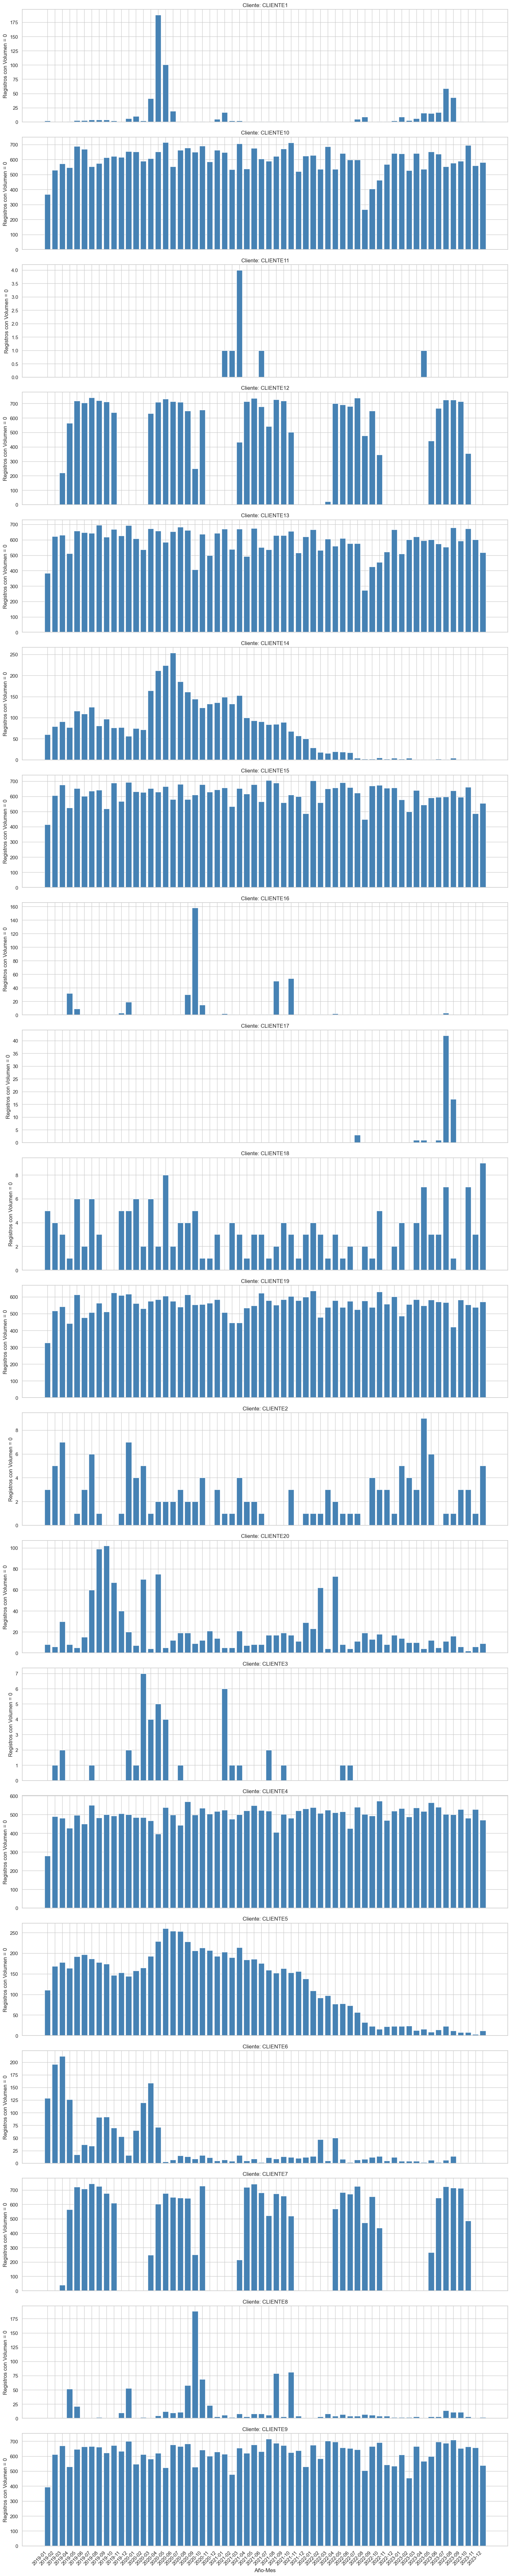

In [28]:
# Distribución de volumen = 0 desglosado por cliente y mes con su año
n_clientes = len(distribucion_cero_mensual)
fig, axs = plt.subplots(n_clientes, 1, figsize=(16, 4 * n_clientes), sharex=True)

for i, cliente in enumerate(distribucion_cero_mensual.index):
    axs[i].bar(distribucion_cero_mensual.columns.astype(str),
               distribucion_cero_mensual.loc[cliente],
               color='steelblue')
    axs[i].set_title(f'Cliente: {cliente}')
    axs[i].set_ylabel('Registros con Volumen = 0')

axs[-1].set_xlabel('Año-Mes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Consistencia

In [29]:
# Estadísticas descriptivas generales
print("\nEstadísticas descriptivas generales:")
df.describe().T


Estadísticas descriptivas generales:


count                           mean                  min  \
Fecha          847960  2021-07-08 22:08:19.659418112  2019-01-14 00:00:00   
Presion      847960.0                      16.072957             2.934873   
Temperatura  847960.0                      25.198239            -5.257899   
Volumen      847960.0                      62.328206                  0.0   

                             25%                  50%                  75%  \
Fecha        2020-04-13 23:00:00  2021-07-07 06:00:00  2022-10-06 02:15:00   
Presion                 17.09735            17.570449            17.694254   
Temperatura            22.693027            25.379859            27.886244   
Volumen                      0.0            21.773567            99.319649   

                             max        std  
Fecha        2023-12-31 23:00:00        NaN  
Presion                20.307852   4.186408  
Temperatura            50.019853   3.790497  
Volumen               577.413425  80.498112

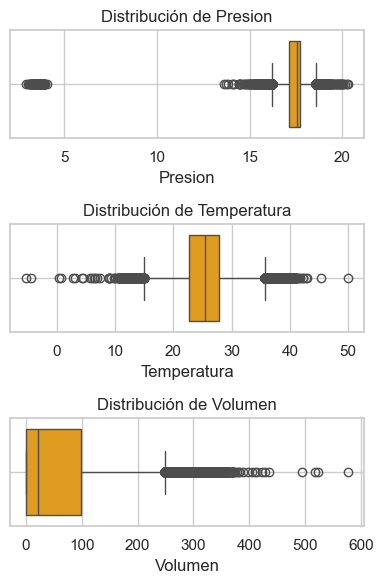

In [30]:
# Visualización de distribuciones
variables = ['Presion', 'Temperatura', 'Volumen']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4, 6))

for i, var in enumerate(variables):
    sns.boxplot(data=df, x=var, ax=axes[i], color='orange')
    axes[i].set_title(f'Distribución de {var}')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

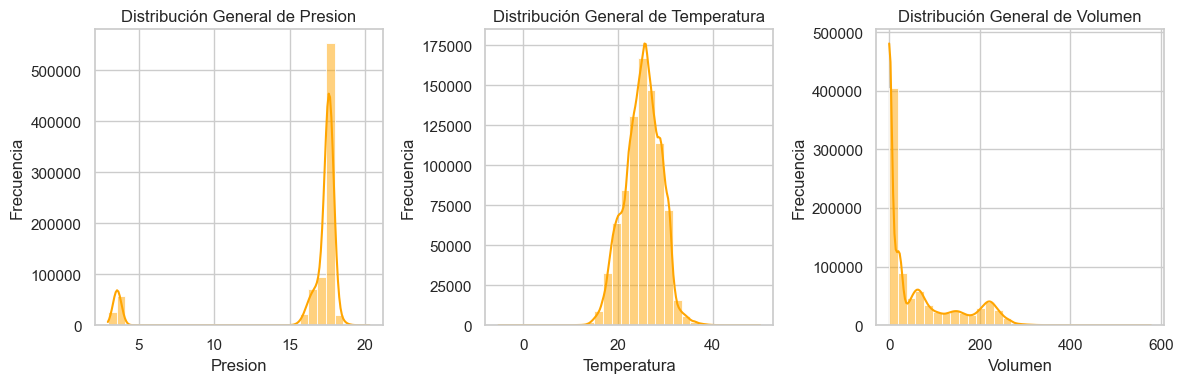

In [31]:
# Graficar distribuciones generales
variables = ['Presion', 'Temperatura', 'Volumen']
plt.figure(figsize=(12, 4))

for i, var in enumerate(variables, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[var], kde=True, bins=30, color="orange")
    plt.title(f"Distribución General de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

In [32]:
# Estadísticas descriptivas por cliente
# Generar estadísticas descriptivas por cliente
estadisticas = df.groupby('Cliente')[['Presion', 'Temperatura', 'Volumen']].describe()
estadisticas_ordenadas = estadisticas.loc[lista_pares_organizados]
print("\nEstadísticas descriptivas por cliente (orden personalizado):")
display(estadisticas_ordenadas)



Estadísticas descriptivas por cliente (orden personalizado):


Presion                                                        \
             count       mean       std        min        25%        50%   
Cliente                                                                    
CLIENTE10  41059.0  17.473694  0.134933  16.469864  17.421424  17.495303   
CLIENTE13  41059.0  17.492521  0.120068  16.505077  17.457089  17.511078   
CLIENTE18  41382.0  17.554599  0.252214  16.215105  17.590677  17.644742   
CLIENTE2   41382.0  17.526440  0.318984  16.129015  17.581711  17.637486   
CLIENTE12  41776.0  17.833667  0.418490  13.740922  17.538897  17.834866   
CLIENTE7   41776.0  17.490812  0.450059  14.418261  17.188626  17.493758   
CLIENTE3   42248.0   3.569593  0.080619   3.057171   3.512245   3.559350   
CLIENTE11  42248.0   3.545512  0.082752   2.934873   3.490493   3.535771   
CLIENTE19  42305.0  17.667217  0.324830  16.247484  17.723709  17.786565   
CLIENTE4   42305.0  17.639754  0.390818  15.214996  17.711300  17.779337   
CLIENTE9   42428.0  17.466627  0.157897  16.486477  17.428230  17.497293   
CLIENTE15  42428.0  17.495812  0.139307  16.514496  17.471277  17.515236   
CLIENTE20  42808.0  17.579587  0.408268  14.849737  17.537686  17.688964   
CLIENTE6   42808.0  17.569108  0.396870  13.810026  17.634058  17.707247   
CLIENTE8   43147.0  16.705630  0.598608  14.996490  16.258053  16.567409   
CLIENTE16  43147.0  16.705058  0.492334  14.734521  16.347862  16.619526   
CLIENTE1   43412.0  17.535934  0.358310  15.742337  17.590781  17.651439   
CLIENTE17  43412.0  17.533599  0.380016  15.265703  17.581482  17.653419   
CLIENTE14  43415.0  17.517128  0.369094  13.616877  17.568526  17.632941   
CLIENTE5   43415.0  17.489345  0.370395  14.489896  17.537779  17.614668   

                                Temperatura             ...             \
                 75%        max       count       mean  ...        75%   
Cliente                                                 ...              
CLIENTE10  17.564497  18.573079     41059.0  23.500489  ...  25.593807   
CLIENTE13  17.563878  18.471047     41059.0  21.591365  ...  23.941859   
CLIENTE18  17.675545  17.821359     41382.0  27.668722  ...  29.883001   
CLIENTE2   17.675036  18.106402     41382.0  27.673040  ...  29.825196   
CLIENTE12  18.106159  20.232110     41776.0  26.689551  ...  31.144009   
CLIENTE7   17.778862  20.307852     41776.0  23.622548  ...  27.865012   
CLIENTE3    3.617770   4.037030     42248.0  26.348434  ...  28.505966   
CLIENTE11   3.587027   3.954039     42248.0  26.307152  ...  28.569625   
CLIENTE19  17.819176  18.258619     42305.0  23.223832  ...  25.553592   
CLIENTE4   17.823517  20.112931     42305.0  23.241102  ...  25.554712   
CLIENTE9   17.559919  18.430469     42428.0  22.073596  ...  24.381765   
CLIENTE15  17.563664  18.493234     42428.0  24.026489  ...  26.399282   
CLIENTE20  17.820248  18.578203     42808.0  25.407173  ...  27.688004   
CLIENTE6   17.758536  19.720870     42808.0  26.393254  ...  28.666090   
CLIENTE8   17.104602  18.950955     43147.0  26.814551  ...  29.333184   
CLIENTE16  17.023767  19.440780     43147.0  27.481311  ...  29.654472   
CLIENTE1   17.711107  18.074274     43412.0  25.575853  ...  27.695776   
CLIENTE17  17.720431  18.445378     43412.0  25.849342  ...  27.929240   
CLIENTE14  17.684638  20.028395     43415.0  26.658520  ...  29.860792   
CLIENTE5   17.667026  19.009352     43415.0  23.665282  ...  27.070649   

                      Volumen                                          \
                 max    count        mean        std  min         25%   
Cliente                                                                 
CLIENTE10  35.069721  41059.0   11.788209  43.991880  0.0    0.000000   
CLIENTE13  29.753364  41059.0   10.276088  41.184079  0.0    0.000000   
CLIENTE18  33.789362  41382.0   61.758087  18.201164  0.0   51.444677   
CLIENTE2   35.208346  41382.0   61.819045  17.495571  0.0   51.809989   
CLIENTE12  50.019853  41776.0   33.731496  41.95

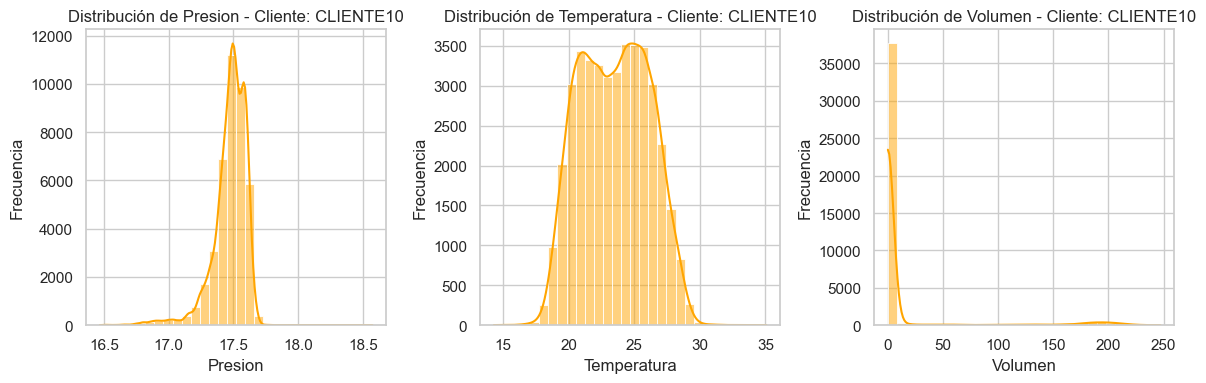

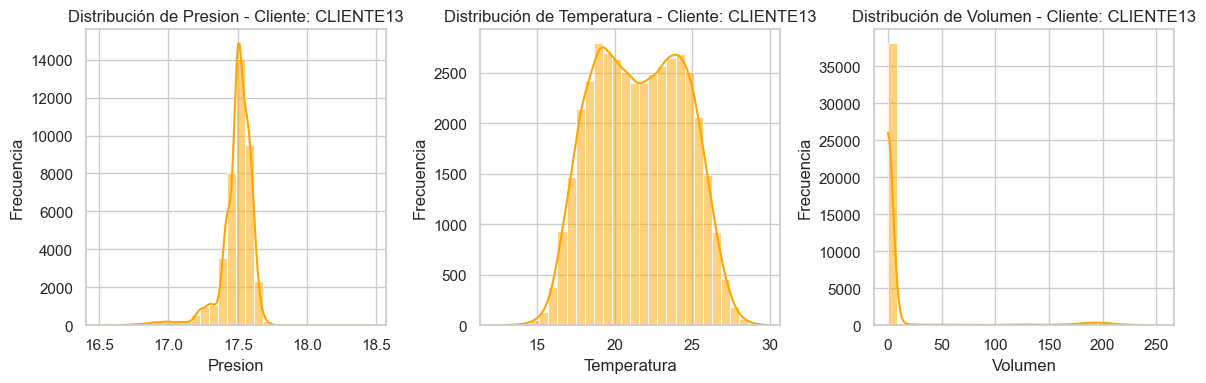

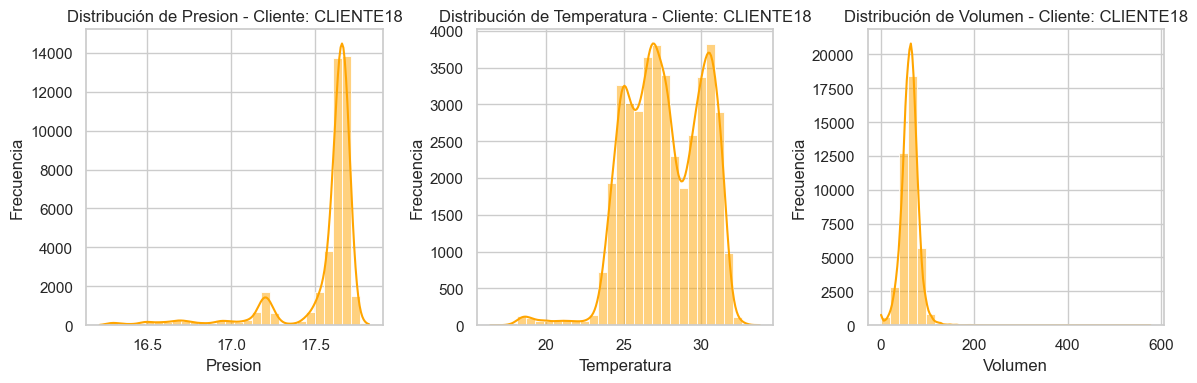

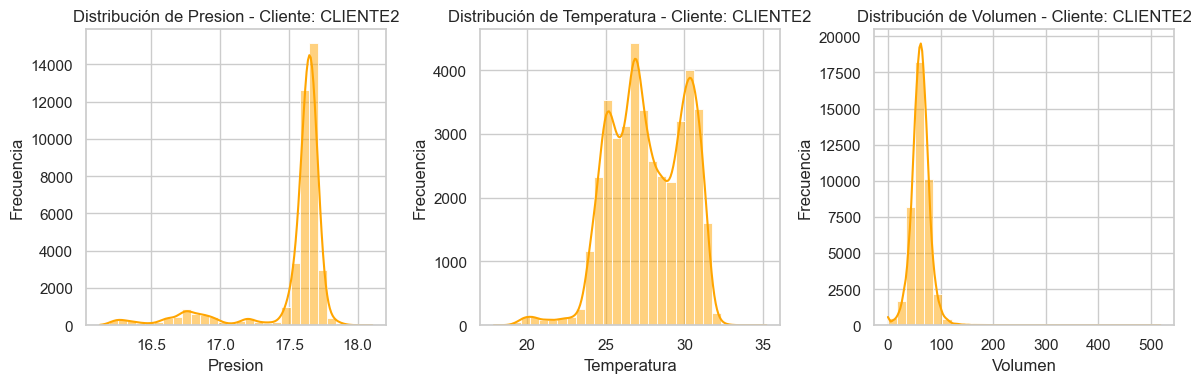

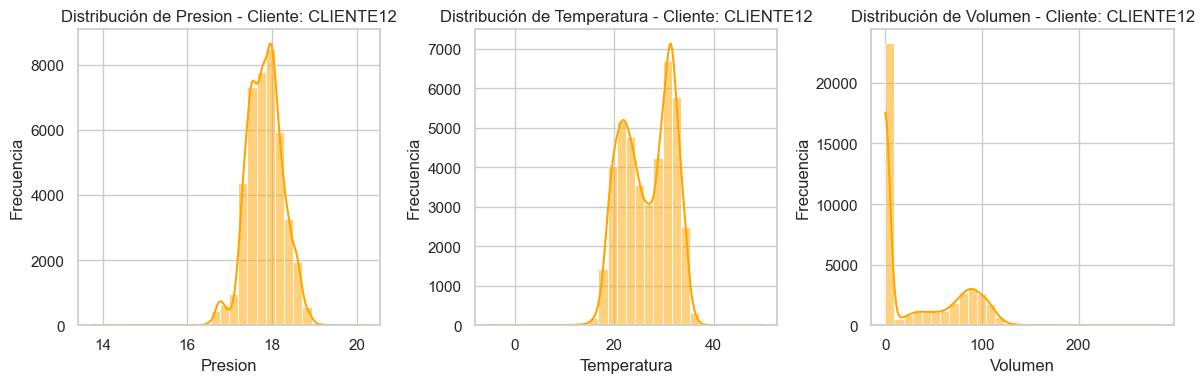

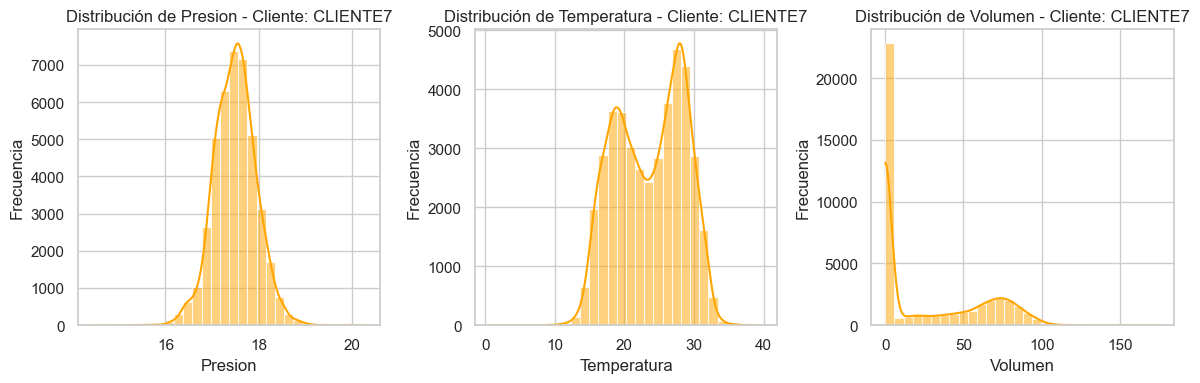

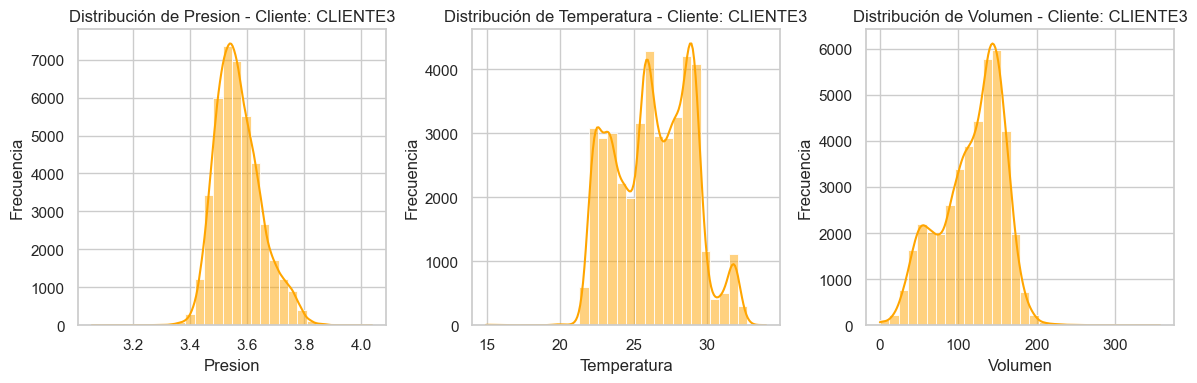

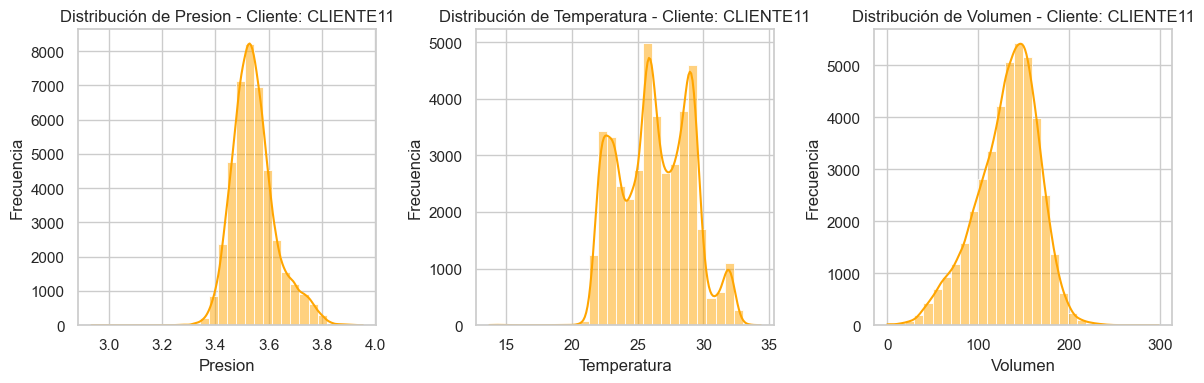

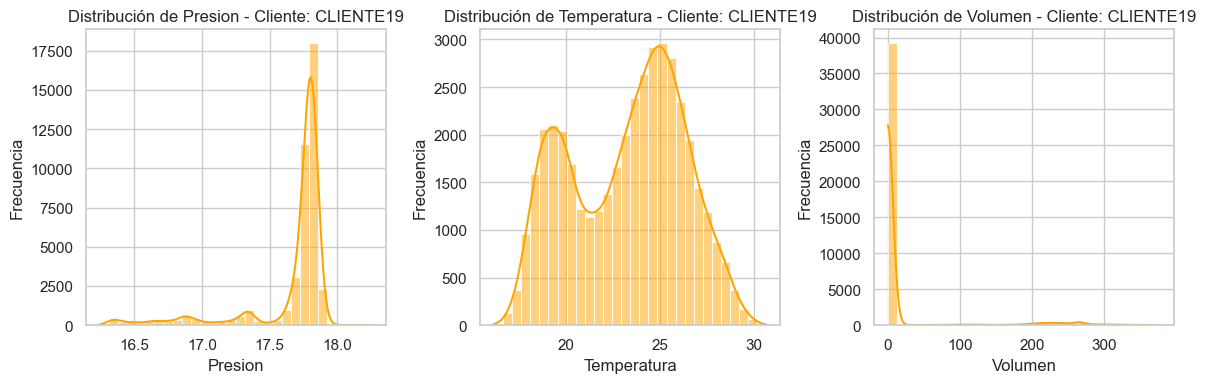

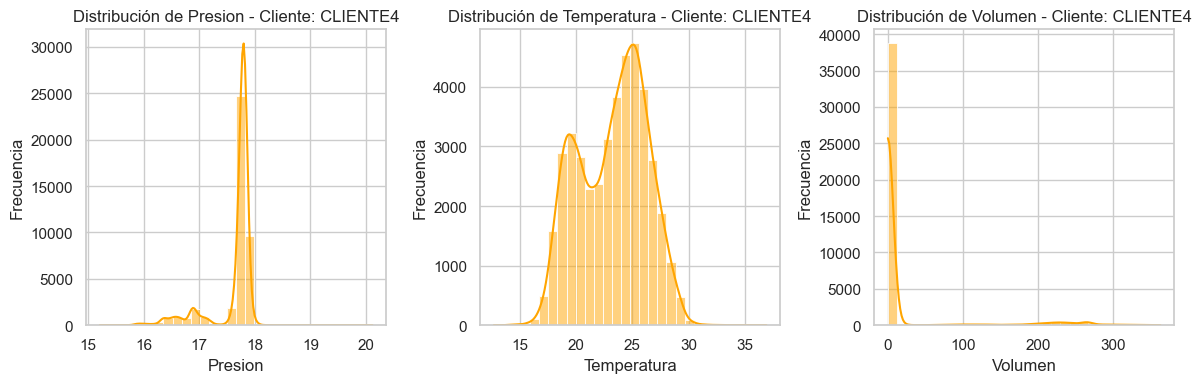

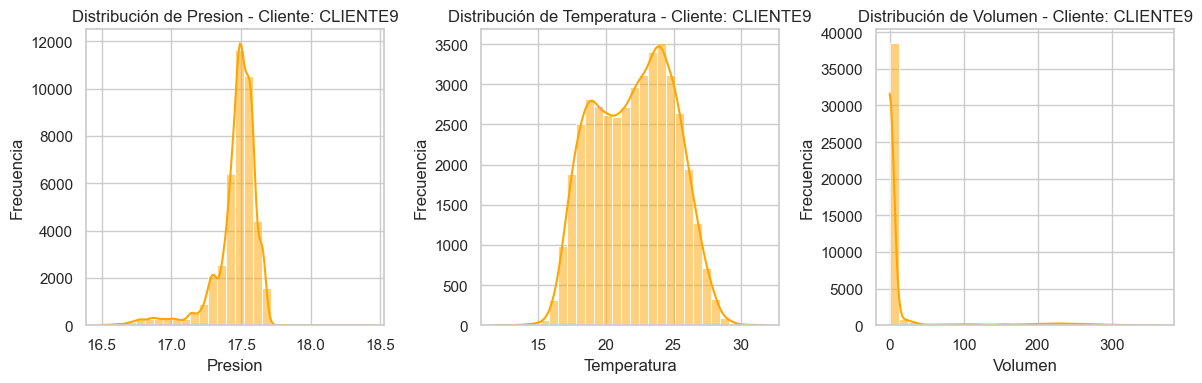

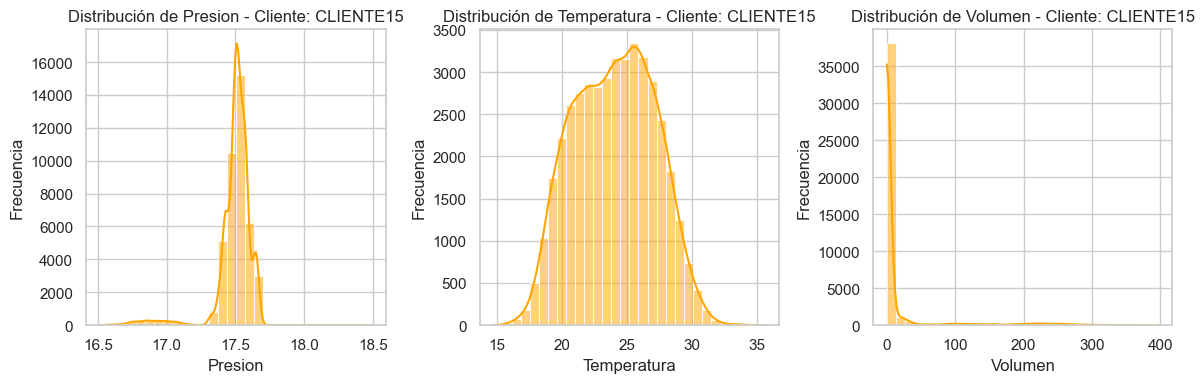

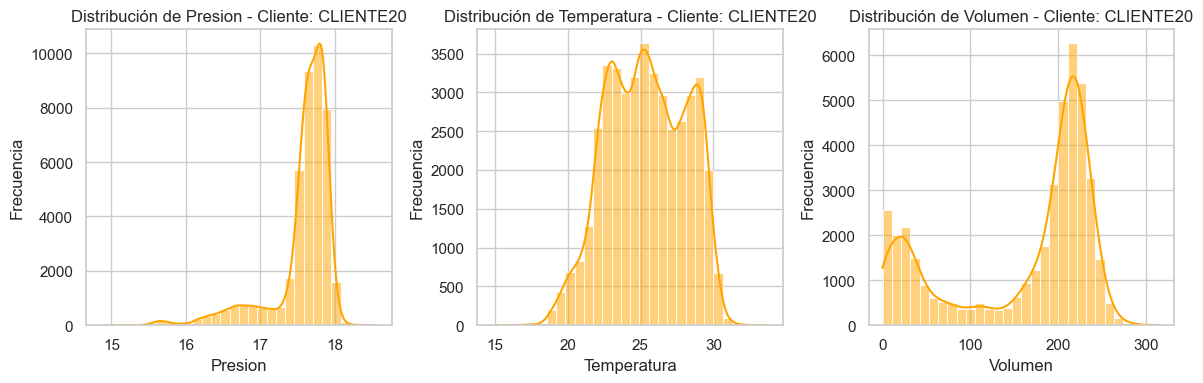

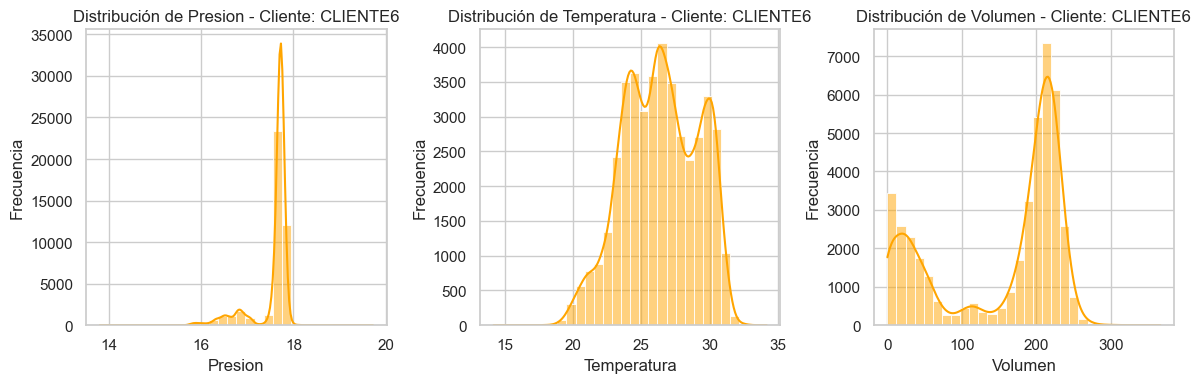

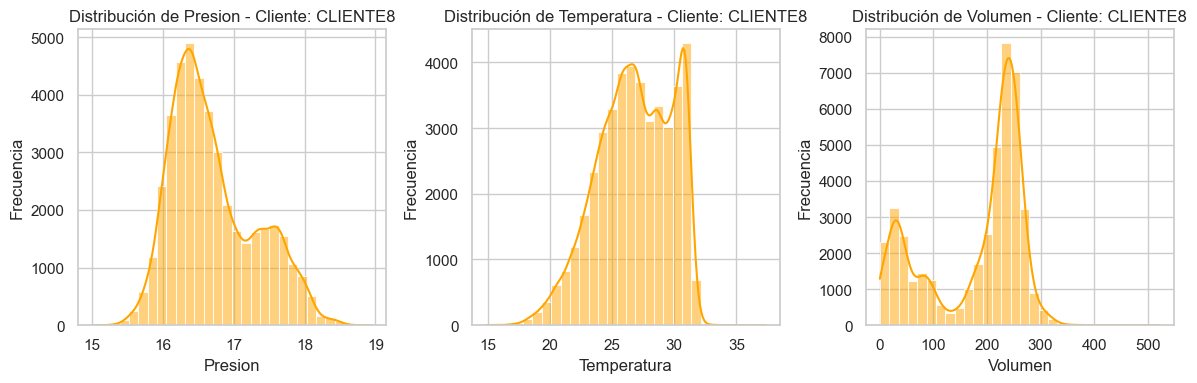

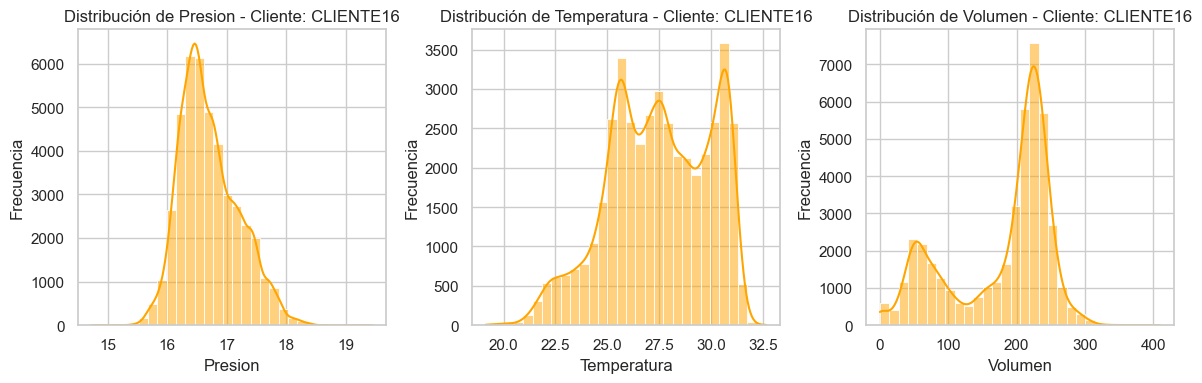

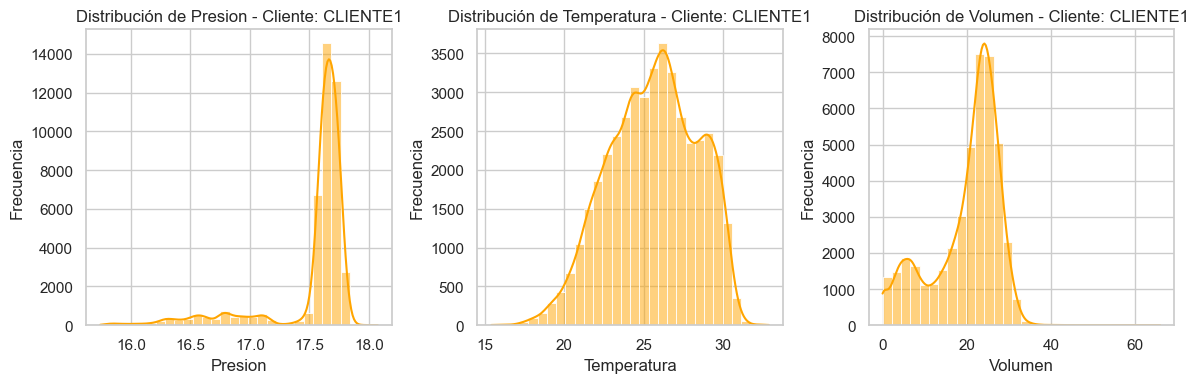

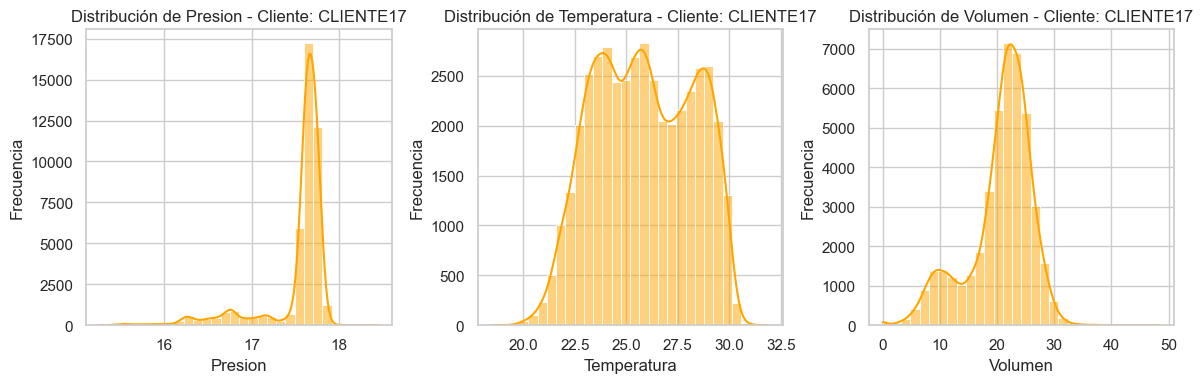

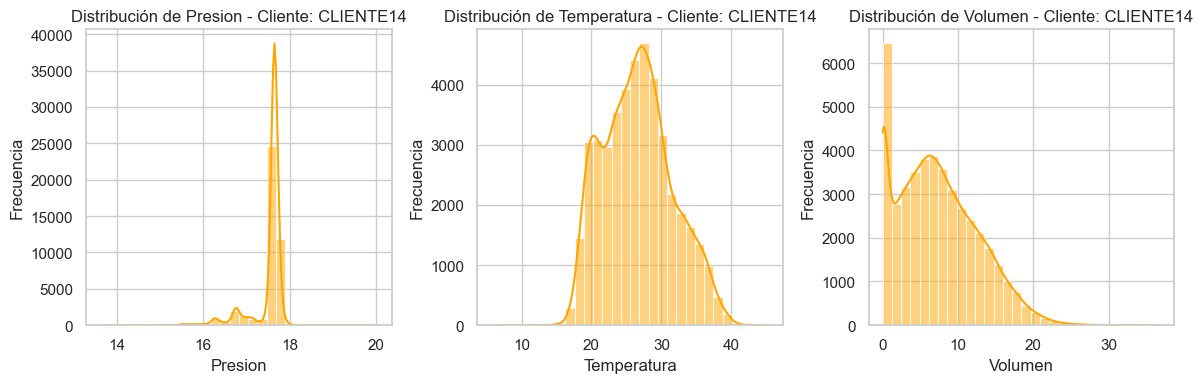

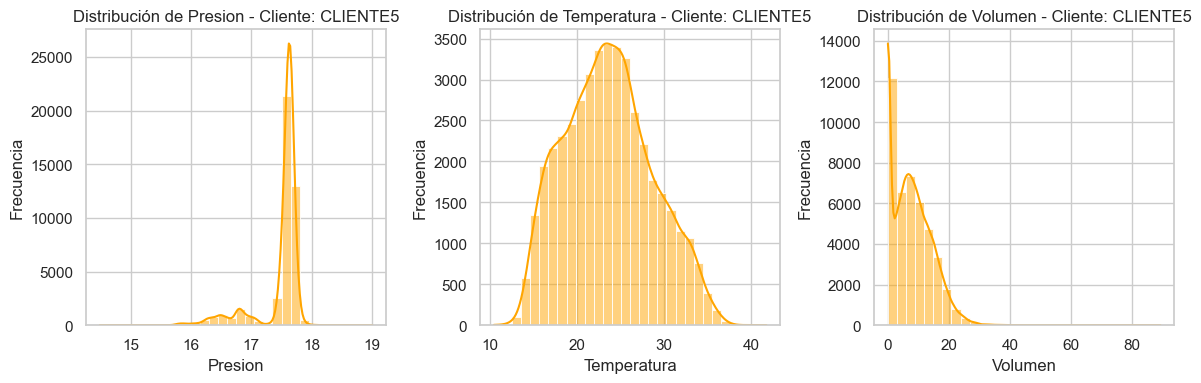

In [33]:
for cliente in lista_pares_organizados:
    graficar_distribuciones_por_cliente(df, cliente, "orange", variables)

### Conclusiones

**Completitud**
- El total de registros es 847960 donde hay 20 clientes industriales.
- No se observaron valores nulos
- No se observaron valores duplicados
- Se registran 22294 valores faltantes en total (2,63%)
- Los clientes que evidencias más valores faltantes son el 10 y el 13 con un porcentaje de 5,64%, seguidos por los clientes 13 y 18 con un porcentaje de 4,91%.
- Se evidencia un patrón en los valores faltantes. Están por pares los valores faltantes, ya que coincide tanto las fechas como el  porcentaje. Se intuye que puedan estar ocasionados por problemas de la red.

- Se evidencia que hay 270660 registros con volumen igual a 0 (31.92%), de los cuales 37386 son del cliente 9 (equivalente al 88,12%) cliente con mayor cantidad de registros con este volumen), seguido por el cliente 10 y 15 (87,49% y 86,81%), sin embargo, a diferencia de los valores faltantes, no se observan patrones, por lo que podria interpretarse como propio de la actividad individual de cada cliente.

- Al comparar la distribución de los valores con volumen diferentes de 0 e igual a 0, no se observan distribuciones similares, por lo que se descarta el reemplaza usando la Ley de lo Gases.

- Al explorar la tendencia de los valores de 0, se observa que a diferencia de los otros clientes, los cuales presentan estos valores sin un patrón importante, los Clientes 12 y 7 presentan un mayor número de registros con volumen igual a 0 desde junio hasta septiembre en todos los años, esto puede relacionarse quizás con el tipo de actividad que tienen.

**Consistencia**
- El conjunto de datos contiene 847960 registros desde el 14 de enero de 2019 hasta el 31 de diciembre de 2023. En cuanto a las variables numéricas, la presión presenta una media de 16.07 y una desviación estándar de 4.19, con valores que van desde 2.93 hasta 20.31, mostrando una ligera asimetría hacia valores bajos. La temperatura tiene una media de 25.20 °C y un rango entre -5.26 °C y 50.02 °C, con una dispersión moderada (desviación estándar de 3.79 °C). Por su parte, el volumen muestra un comportamiento más heterogéneo, con una media de 62.33 y una desviación estándar alta (80.50), destacándose que el 25% de los registros tienen un volumen igual a cero, lo que sugiere una gran cantidad de periodos sin consumo o sin datos registrados.

- Al observar las distribuciones generales en los datos se observa que la presión es bimodal. Al detallar las estadísticas descriptivas, es notable que los clientes 3 y 11 presentan presiones promedio inferiores (3,5 bar aproximadamente) a los otros clientes (17,5 bar aprox).

- Mediante las estadisticas descriptivas y los histogramas desglosados por clientes, se vuelve a observar que hay patrones por pares.


### Imputación de Datos

**Completar Fechas Faltantes para Clientes Críticos**

In [ ]:
# Crear rango completo de fechas por hora
fecha_inicio = pd.Timestamp("2019-01-14 00:00:00")
fecha_fin = pd.Timestamp("2023-12-31 23:00:00")
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq="H")

# Seleccionar solo los clientes críticos
clientes_criticos = ['CLIENTE10', 'CLIENTE13', 'CLIENTE18', 'CLIENTE2']

# Diccionario para guardar fechas faltantes por cliente
fechas_faltantes_criticos = {}

for cliente in clientes_criticos:
    df_cliente = df[df['Cliente'] == cliente].copy()
    fechas_cliente = df_cliente['Fecha'].drop_duplicates()
    fechas_faltantes = rango_fechas[~rango_fechas.isin(fechas_cliente)]
    fechas_faltantes_criticos[cliente] = fechas_faltantes

# Crear resumen
total_fechas_esperadas = len(rango_fechas)
faltantes_resumen_criticos = {
    cliente: {
        "faltantes": len(fechas),
        "porcentaje": 100 * len(fechas) / total_fechas_esperadas
    } for cliente, fechas in fechas_faltantes_criticos.items()
}

# Mostrar en DataFrame
df_faltantes_criticos = pd.DataFrame.from_dict(faltantes_resumen_criticos, orient="index")
df_faltantes_criticos = df_faltantes_criticos.sort_values(by="porcentaje", ascending=False)
print(df_faltantes_criticos)

**Completar las demas fechas faltantes**

In [ ]:
# Crear un DataFrame base con todas las fechas como índice
df_base_fechas = pd.DataFrame(index=rango_fechas)

# Diccionario para almacenar los DataFrames completos por cliente
clientes_completos = {}

# Completar los datos para los clientes críticos
for cliente in clientes_criticos:
    df_cliente = df[df['Cliente'] == cliente].copy()
    df_cliente = df_cliente.set_index('Fecha')
    
    # Reindexar sobre el rango completo para insertar NaNs donde falten datos
    df_completo = df_base_fechas.merge(df_cliente, how='left', left_index=True, right_index=True)
    
    # Guardar el DataFrame completo por cliente
    clientes_completos[cliente] = df_completo

# Ver estructura de CLIENTE10 como ejemplo
clientes_completos['CLIENTE10'].head()

df_completo['Cliente'] = cliente  # Rellenar la columna Cliente para todas las filas

**Imputación de Datos**

-Interpolación lineal para CLIENTE10 y CLIENTE13.

-Media por mes para cada cliente, CLIENTE18 y CLIENTE2.

In [ ]:
# Aplicar estrategias de imputación mixtas

clientes_imputados = {}

for cliente, df in clientes_completos.items():
    df_imputado = df.copy()
    
    if cliente in ['CLIENTE10', 'CLIENTE13']:
        # Interpolación lineal
        df_imputado[['Presion', 'Temperatura', 'Volumen']] = df_imputado[['Presion', 'Temperatura', 'Volumen']].interpolate(method='linear', limit_direction='both')
    
    elif cliente in ['CLIENTE18', 'CLIENTE2']:
        # Imputación por promedio mensual
        df_imputado['Mes'] = df_imputado.index.month
        df_imputado['Anio'] = df_imputado.index.year
        
        for col in ['Presion', 'Temperatura', 'Volumen']:
            df_imputado[col] = df_imputado.groupby(['Anio', 'Mes'])[col].transform(lambda x: x.fillna(x.mean()))
        
        df_imputado = df_imputado.drop(columns=['Mes', 'Anio'])

    clientes_imputados[cliente] = df_imputado

# Verificar imputación para uno de los clientes
clientes_imputados['CLIENTE18'].head(10)

In [ ]:
# Generar gráficos para los demás clientes críticos
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex='col')
clientes_a_graficar = ['CLIENTE13', 'CLIENTE18', 'CLIENTE2']

for idx, cliente in enumerate(clientes_a_graficar):
    df_plot = clientes_imputados[cliente].copy()
    df_plot.index = pd.to_datetime(df_plot.index)
    df_sub = df_plot['2019-01-14':'2019-01-28']
    
    df_sub['Presion'].plot(ax=axes[0, idx], title=f'{cliente} - Presión')
    axes[0, idx].set_ylabel('Bar')

    df_sub['Temperatura'].plot(ax=axes[1, idx], title=f'{cliente} - Temperatura')
    axes[1, idx].set_ylabel('°C')

    df_sub['Volumen'].plot(ax=axes[2, idx], title=f'{cliente} - Volumen')
    axes[2, idx].set_ylabel('m³')

plt.tight_layout()
plt.show()

In [ ]:
# Verificar que no hay valores faltantes y que el índice es de tipo datetime
for cliente, df in clientes_imputados.items():
    df['Cliente'] = cliente  # Reasignar el nombre del cliente a todas las filas
    print(f"\n Cliente: {cliente}")
    
    # Verificar tipo de índice
    print("Tipo de índice:", type(df.index), "->", df.index.dtype)
    
    # Verificar cantidad de valores nulos por columna
    nulos = df.isna().sum()
    print("Valores nulos por columna:\n", nulos)

    if nulos.sum() == 0 and pd.api.types.is_datetime64_any_dtype(df.index):
        print("Sin valores faltantes y el índice tiene formato datetime.\n")
    else:
        print("Hay valores faltantes o problemas con el índice.\n")


In [ ]:
# Usamos el primer nombre de columna como 'Fecha' y añadimos la hoja como 'Cliente'
df = pd.concat(
    [df.rename(columns={df.columns[0]: 'Fecha'}).assign(Cliente=sheet_name)
     for sheet_name, df in pd.read_excel(path, sheet_name=None).items()],
    ignore_index=True
)

# Asegurar que 'Fecha' esté en formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [ ]:
clientes_todos = df['Cliente'].unique().tolist()

clientes_completos = {}
clientes_imputados = {}

for cliente in clientes_todos:
    df_cliente = df[df['Cliente'] == cliente].copy()

    if 'Fecha' not in df_cliente.columns:
        print(f"⚠️ Cliente {cliente} no tiene columna 'Fecha'. Se omite.")
        continue

    df_cliente = df_cliente.set_index('Fecha')
    df_completo = df_base_fechas.merge(df_cliente, how='left', left_index=True, right_index=True)
    df_imputado = df_completo.copy()

    if df_imputado[['Presion', 'Temperatura', 'Volumen']].isna().sum().sum() > 0:
        df_imputado[['Presion', 'Temperatura', 'Volumen']] = df_imputado[['Presion', 'Temperatura', 'Volumen']].interpolate(method='linear', limit_direction='both')
        df_imputado['Mes'] = df_imputado.index.month
        df_imputado['Anio'] = df_imputado.index.year
        for col in ['Presion', 'Temperatura', 'Volumen']:
            df_imputado[col] = df_imputado.groupby(['Anio', 'Mes'])[col].transform(lambda x: x.fillna(x.mean()))
        df_imputado = df_imputado.drop(columns=['Mes', 'Anio'])

    df_imputado['Cliente'] = cliente
    clientes_completos[cliente] = df_completo
    clientes_imputados[cliente] = df_imputado

In [ ]:
for cliente, df in clientes_imputados.items():
    nulos = df.isna().sum().sum()
    print(f"{cliente}: {'OK' if nulos == 0 else f'❌ {nulos} valores faltantes'}")

In [ ]:
for cliente, df in clientes_imputados.items():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    fig.suptitle(f'Cliente: {cliente}', fontsize=14, fontweight='bold')
    
    # Histograma de Presión
    axs[0].hist(df['Presion'], bins=30, color='steelblue', edgecolor='black')
    axs[0].set_title('Distribución de Presión')
    axs[0].set_xlabel('Presión (bar)')
    axs[0].set_ylabel('Frecuencia')
    
    # Histograma de Temperatura
    axs[1].hist(df['Temperatura'], bins=30, color='salmon', edgecolor='black')
    axs[1].set_title('Distribución de Temperatura')
    axs[1].set_xlabel('Temperatura (°C)')
    axs[1].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

# Proceso de Imputación de Datos Faltantes

## 1. Construcción del Rango Completo de Fechas

Se generó un índice con todas las fechas y horas esperadas entre el 14 de enero de 2019 y el 31 de diciembre de 2023 (frecuencia horaria). Este rango fue fundamental para identificar los registros faltantes.

```python
rango_fechas = pd.date_range("2019-01-14 00:00:00", "2023-12-31 23:00:00", freq="H")

## 2. Identificación de Clientes Críticos
Se definieron como "clientes críticos" aquellos con mayor porcentaje de registros faltantes, para los cuales era prioritario completar la serie de tiempo:

Cliente	Registros Faltantes	Porcentaje (%)
CLIENTE10	2453	5.64
CLIENTE13	2453	5.64
CLIENTE18	2135	4.91
CLIENTE2	2135	4.91

## 3. Reconstrucción de Series Temporales Completas
Para estos clientes, se completaron las fechas faltantes con valores NaN mediante reindexing usando el rango total de fechas. Esto permitió preservar la continuidad temporal para cada cliente, independientemente de los registros efectivamente disponibles.

## 4. Estrategia de Imputación Mixta
Se aplicaron dos técnicas según el patrón de datos de cada cliente:

a. Interpolación Lineal (limit_direction='both')
Utilizada en clientes con registros relativamente continuos y sin fuertes estacionalidades:

CLIENTE10

CLIENTE13

Esta técnica suaviza los datos ausentes estimando sus valores según la línea recta entre los valores anterior y posterior conocidos.

df[['Presion', 'Temperatura', 'Volumen']] = df[['Presion', 'Temperatura', 'Volumen']].interpolate(method='linear', limit_direction='both')


b. Imputación por Promedio Mensual
Aplicada a clientes con variabilidad más marcada a lo largo del tiempo:

CLIENTE2

CLIENTE18

Esta técnica preserva la estacionalidad del comportamiento mensual:

python
Copy
Edit
df['Mes'] = df.index.month
df['Anio'] = df.index.year
df[col] = df.groupby(['Anio', 'Mes'])[col].transform(lambda x: x.fillna(x.mean()))

## 5. Verificación del Proceso
Se validó que todos los DataFrames resultantes no contuvieran valores nulos:

python
Copy
Edit
for cliente, df in clientes_imputados.items():
    print(f"{cliente}: {'OK' if df.isna().sum().sum() == 0 else '❌ Faltantes'}")
Resultado: Todos los clientes mostraron OK, indicando imputación exitosa.

## 6. Visualización de Resultados
a. Serie Temporal Imputada (2019-01-14 a 2019-01-28)
Se graficaron las tres variables para los clientes críticos, verificando que la continuidad temporal y el comportamiento general se mantuviera razonable tras la imputación.

b. Histogramas por Cliente
Se graficaron histogramas de presión y temperatura para cada cliente:

Confirman que no se introdujeron distribuciones artificiales.

La forma de las distribuciones se conserva o suaviza de forma razonable tras la imputación.

Se observa continuidad estadística sin sesgos extremos ni acumulaciones inesperadas.

Conclusiones
- La interpolación lineal fue efectiva para clientes con registros regulares.
- La media mensual respetó patrones estacionales en clientes más variables.
- El proceso fue robusto, preservando tanto la estructura temporal como la distribución de los datos.
- No se detectaron valores faltantes tras el proceso.
- Las visualizaciones apoyan la calidad del procedimiento y confirman la coherencia del dataset imputado.


### 2. Series de tiempo

#### Datos originales

In [ ]:
# Crear la figura y subplots
# Crear la figura y subplots: 3 columnas (Volumen, Presión, Temperatura)
n_clientes = len(lista_pares_organizados)
fig, axes = plt.subplots(n_clientes, 3, figsize=(18, 4 * n_clientes), sharex=True)

# Iterar por cliente
for i, cliente in enumerate(lista_pares_organizados):
    df_cliente = df[df['Cliente'] == cliente]

    # Volumen
    axes[i][0].plot(df_cliente['Fecha'], df_cliente['Volumen'], color='steelblue')
    axes[i][0].set_ylabel(f'Cliente {cliente}\nVolumen')
    axes[i][0].grid(True)

    # Presión
    axes[i][1].plot(df_cliente['Fecha'], df_cliente['Presion'], color='darkorange')
    axes[i][1].set_ylabel('Presión')
    axes[i][1].grid(True)

    # Temperatura
    axes[i][2].plot(df_cliente['Fecha'], df_cliente['Temperatura'], color='forestgreen')
    axes[i][2].set_ylabel('Temperatura')
    axes[i][2].grid(True)

# Etiquetas de los ejes X en la última fila
for ax in axes[-1]:
    ax.set_xlabel('Fecha')

# Títulos por columna
fig.suptitle('Series de Tiempo por Cliente: Volumen, Presión y Temperatura', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Datos completos imputados con promedio

In [ ]:
# Crear DataFrame completo por cliente con fechas faltantes
df_completo = pd.DataFrame()

for cliente in lista_pares_organizados:
    # Asegurar una sola fila por fecha: usar promedio si hay duplicados
    df_cliente_raw = df[df['Cliente'] == cliente].copy()
    df_cliente = df_cliente_raw.groupby('Fecha').mean(numeric_only=True).reset_index()
    fecha_min = df_cliente['Fecha'].min()
    fecha_max = df_cliente['Fecha'].max()
    fechas_cliente = pd.date_range(start=fecha_min, end=fecha_max, freq='D')

    # Crear dataframe con fechas completas
    df_cliente = df_cliente.set_index('Fecha').reindex(fechas_cliente)
    df_cliente['Cliente'] = cliente
    df_cliente = df_cliente.reset_index().rename(columns={'index': 'Fecha'})
    df_completo = pd.concat([df_completo, df_cliente], ignore_index=True)

# Marcar valores imputados
for var in ['Volumen', 'Presion', 'Temperatura']:
    df_completo[f'{var}_faltante'] = df_completo[var].isna().astype(int)

# Imputar con la media por cliente
for var in ['Volumen', 'Presion', 'Temperatura']:
    df_completo[var] = df_completo.groupby('Cliente')[var].transform(lambda x: x.fillna(x.mean()))

# Graficar
fig, axes = plt.subplots(len(lista_pares_organizados), 3, figsize=(18, 4 * len(lista_pares_organizados)), sharex=False)

if len(lista_pares_organizados) == 1:
    axes = [axes]

for i, cliente in enumerate(lista_pares_organizados):
    df_cli = df_completo[df_completo['Cliente'] == cliente]

    for j, (var, color) in enumerate(zip(['Volumen', 'Presion', 'Temperatura'], ['steelblue', 'darkorange', 'forestgreen'])):
        ax = axes[i][j]
        ax.plot(df_cli['Fecha'], df_cli[var], label=var, color=color, alpha=0.7)
        df_faltantes = df_cli[df_cli[f'{var}_faltante'] == 1]
        ax.scatter(df_faltantes['Fecha'], df_faltantes[var], color='red', s=10, label='Imputado')
        ax.set_ylabel(var)
        ax.grid(True)
        ax.legend()
        if j == 0:
            ax.set_title(f'Cliente {cliente}')
        if i == len(lista_pares_organizados) - 1:
            ax.set_xlabel('Fecha')

fig.suptitle('Series de Tiempo por Cliente (Imputaciones en Rojo)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



#### Datos completos imputados con promedio y resaltados valores con volumen de 0

In [ ]:
# Graficar
fig, axes = plt.subplots(len(lista_pares_organizados), 3, figsize=(18, 4 * len(lista_pares_organizados)), sharex=False)

if len(lista_pares_organizados) == 1:
    axes = [axes]

for i, cliente in enumerate(lista_pares_organizados):
    df_cli = df_completo[df_completo['Cliente'] == cliente]

    # Fechas donde el Volumen es 0
    fechas_volumen_cero = df_cli[df_cli['Volumen'] == 0]['Fecha']

    for j, (var, color) in enumerate(zip(['Volumen', 'Presion', 'Temperatura'], ['steelblue', 'darkorange', 'forestgreen'])):
        ax = axes[i][j]
        ax.plot(df_cli['Fecha'], df_cli[var], label=var, color=color, alpha=0.7)

        # Marcar imputados en rojo
        df_faltantes = df_cli[df_cli[f'{var}_faltante'] == 1]
        ax.scatter(df_faltantes['Fecha'], df_faltantes[var], color='red', s=10, label='Imputado')

        # Marcar valores en las fechas donde Volumen == 0 en azul
        df_ceros = df_cli[df_cli['Fecha'].isin(fechas_volumen_cero)]
        ax.scatter(df_ceros['Fecha'], df_ceros[var], color='blue', s=10, label='Volumen = 0')

        ax.set_ylabel(var)
        ax.grid(True)
        ax.legend()
        if j == 0:
            ax.set_title(f'Cliente {cliente}')
        if i == len(lista_pares_organizados) - 1:
            ax.set_xlabel('Fecha')

fig.suptitle('Series de Tiempo por Cliente (Rojo: Imputado, Azul: Fecha con Volumen = 0)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Conclusiones
- Solo para efectos de completitud, se imputaron los datos con el promedio, sin embargo, ya este tipo de métodos con la media y la mediana son descartados, porque no funcionan bien especialmente para los clientes 18, 2, 19, 4, 20, 6, 1, 17, 14 y 5, los cuales venian con unos datos relativamente constantes, pero a partir de inicios del segundo trimestre de 2023, cambian los valores especialmente de presión con una disminución relativamente continua.

- Al resaltar los valores con volumen 0 en las tres series de tiempo, no se observan a simple vista relaciones anomalas con presión y temperatura.

- Se propone crear un modelo en el que se aisle el componente de temperatura ambiente, puesto que las series de tiempo de temperatura son muy ciclicas

## 2. Preprocesamiento de los datos

Dado el alto porcentaje de ceros y valores faltantes, no se deben tratar como ruido de entrada sin antes interpretarlos:

Valores faltantes por pares: al observar un patrón sincronizado por cliente, conviene marcar estas ausencias como posibles fallos de red y no como anomalías propias del cliente.

→ Acción: crear una variable categórica de "fallo de red" vs. "registro perdido aleatorio".

Volumen = 0:

Si el patrón es repetitivo en ciertos clientes (e.g., cliente 7 y 12), debe considerarse comportamiento normal si está estacionalmente correlacionado.

Pero si aparece de forma aislada, podría representar anomalía operativa.

→ Acción: crear variable volumen_0_contextual que codifique si un 0 es esperado o no (según mes/cliente).

🧠 2. Ingeniería de Características
Extraer nuevas variables que capturen dinámicas temporales o condiciones físicas:

Variables temporales: hora, día de la semana, mes, feriado, etc.

Variables derivadas:

Cambio de volumen respecto a la hora anterior (Δ volumen)

Ratio volumen/presión o volumen/temperatura (útil para detectar fugas o comportamientos anómalos de consumo)

Tendencias semanales/mensuales (moving average, rolling std)

Etiquetado contextual: por ejemplo, cliente con actividad estacional o continuo.

⚙️ 3. Estrategia de Detección de Anomalías
Como tienes series de tiempo por cliente, es conveniente un enfoque híbrido:

a. Enfoques Estadísticos
Modelos basados en Z-score, IQR o control estadístico (Shewhart, CUSUM, EWMA) para detectar cambios abruptos.

Útil para detectar desviaciones puntuales sin necesidad de entrenar.

b. Modelos no supervisados:
Isolation Forest y LOF (Local Outlier Factor): robustos ante outliers.

Autoencoders recurrentes (LSTM): ideales si buscas modelar patrones temporales complejos.

c. Modelos semi-supervisados por cliente:
Entrenar modelos por cliente o por pares similares.

Enfocar en su patrón típico de consumo.

### Cálculo del Volumen usando la Ecuación de los Gases Ideales

Como se tiene la **presión** y la **temperatura** en datos donde el valor del volumen es 0, es posible calcular el **volumen** utilizando la **ecuación de los gases ideales**. Esta ecuación relaciona estos tres parámetros (presión, temperatura y volumen) en condiciones ideales.

La ecuación de los gases ideales es:

$$
PV = nRT
$$

Donde:

- \( P \) es la **presión** (en unidades de presión, como pascales (Pa) o atmósferas (atm)).
- \( V \) es el **volumen** (en unidades de volumen, como litros (L) o metros cúbicos (m³)).
- \( n \) es la **cantidad de sustancia**, es decir, el número de moles de gas.
- \( R \) es la **constante de los gases ideales**, cuyo valor depende de las unidades utilizadas. Por ejemplo, si la presión está en atm y el volumen en litros:

  $$R = 0.0821$$

- \( T \) es la **temperatura absoluta** en **Kelvin**. Si tienes la temperatura en grados Celsius, debes convertirla usando:

$$
T(K) = T(°C) + 273.15
$$

Para calcular el volumen \( V \), puedes reorganizar la ecuación:

$$
V = \frac{nRT}{P}
$$

### Valores extremos:

In [ ]:
# Identificar valores extremos usando percentiles
limites = {}
for col in ['Presion', 'Temperatura', 'Volumen']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limites[col] = {'min': Q1 - 1.5 * IQR, 'max': Q3 + 1.5 * IQR}

print("\nLímites calculados para valores extremos:")
print(limites)

# Marcar valores extremos
for col in limites:
    df[f'{col}_es_extremo_general'] = ~df[col].between(limites[col]['min'], limites[col]['max'])

# Conteo de valores extremos
print("\nConteo de valores extremos por variable:")
for col in ['Presion', 'Temperatura', 'Volumen']:
    print(f"{col}: {df[f'{col}_es_extremo_general'].sum()}")

In [ ]:
def calcular_limites_y_contar_extremos(df, columnas):
    resultados = []

    for cliente in df['Cliente'].unique():
        df_cliente = df[df['Cliente'] == cliente].copy()
        resultado_cliente = {'Cliente': cliente}

        for col in columnas:
            # Calcular límites
            Q1 = df_cliente[col].quantile(0.25)
            Q3 = df_cliente[col].quantile(0.75)
            IQR = Q3 - Q1
            min_val = Q1 - 1.5 * IQR
            max_val = Q3 + 1.5 * IQR

            # Marcar valores extremos
            extremos = ~df_cliente[col].between(min_val, max_val)
            conteo_extremos = extremos.sum()

            # Marcar valores extremos en el DataFrame principal
            df.loc[df['Cliente'] == cliente, f'{col}_extremo_usuario'] = ~df_cliente[col].between(min_val, max_val)

            # Guardar resultados
            resultado_cliente[f'{col}_min'] = min_val
            resultado_cliente[f'{col}_max'] = max_val
            resultado_cliente[f'{col}_cont_extremos'] = conteo_extremos

        resultados.append(resultado_cliente)

    # Crear DataFrame con los resultados y ordenarlo
    resultados_df = pd.DataFrame(resultados)

    return resultados_df

# Aplicar la función
resultado_df = calcular_limites_y_contar_extremos(df, ['Presion', 'Temperatura', 'Volumen'])

# Mostrar el DataFrame resultante
print("\nResultados de límites y conteo de valores extremos:")
print(resultado_df)


In [ ]:
import matplotlib.pyplot as plt

# Función para graficar extremos globales y por cliente con límites globales como líneas
def graficar_extremos_con_limites(df, variable, clientes, limites_globales):
    for cliente in clientes:
        df_cliente = df[df['Cliente'] == cliente]

        plt.figure(figsize=(12, 6))

        # Gráfico de líneas para la variable
        plt.plot(df_cliente['Fecha'], df_cliente[variable], label=f'{variable} (normal)', color='blue', alpha=0.7)

        # Líneas horizontales para los límites globales
        plt.axhline(limites_globales[variable]['min'], color='orange', linestyle='--', label='Límite Global Mínimo', alpha=0.7)
        plt.axhline(limites_globales[variable]['max'], color='green', linestyle='--', label='Límite Global Máximo', alpha=0.7)

        # Extremos por cliente
        plt.scatter(
            df_cliente[df_cliente[f'{variable}_extremo_usuario']]['Fecha'],
            df_cliente[df_cliente[f'{variable}_extremo_usuario']][variable],
            color='red',
            label='Extremos Usuario',
            alpha=0.7
        )

        # Configuración del gráfico
        plt.title(f"Comparación de Extremos con Límites Globales para {variable} (Cliente: {cliente})")
        plt.xlabel("Fecha")
        plt.ylabel(variable)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()


# Seleccionar un subconjunto de clientes para graficar
clientes_para_graficar = df['Cliente'].unique()[:3]  # Ejemplo con los 3 primeros clientes

# Graficar para las tres variables con límites globales
for variable in ['Presion', 'Temperatura', 'Volumen']:
    graficar_extremos_con_limites(df, variable, clientes_unicos, limites)

## 3. Entendimiento de los Datos

### Series temporales

In [ ]:
def graficar_series_generales(df, variables=['Presion', 'Temperatura', 'Volumen'], estadistico='media'):
    """
    Grafica las series de tiempo generales para las variables seleccionadas, calculando
    un estadístico (media, suma, etc.) agregado para todos los clientes.

    Args:
        df (DataFrame): DataFrame que contiene las columnas 'Fecha', 'Cliente' y las variables a graficar.
        variables (list): Lista de nombres de las variables a graficar.
        estadistico (str): Estadístico a calcular ('media', 'suma', etc.).
    """
    # Agrupar por fecha y calcular el estadístico deseado
    if estadistico == 'media':
        datos_aggregados = df.groupby('Fecha')[variables].mean()
    elif estadistico == 'suma':
        datos_aggregados = df.groupby('Fecha')[variables].sum()
    else:
        raise ValueError("Estadístico no soportado. Usa 'media' o 'suma'.")

    # Configurar subgráficos
    n_variables = len(variables)
    fig, axes = plt.subplots(1, n_variables, figsize=(15, 5), sharex=True)

    # Iterar sobre las variables y los ejes
    for i, var in enumerate(variables):
        ax = axes[i]
        ax.plot(datos_aggregados.index, datos_aggregados[var], label=f'{var} ({estadistico})')
        ax.set_title(f"Serie General de {var}")
        ax.set_xlabel("Fecha")
        ax.set_ylabel(var)
        ax.grid()
        ax.legend()

    # Ajustar el espacio entre gráficos
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
graficar_series_generales(df, estadistico='media')  # Cambia a 'suma' para sumar valores


### Correlaciones

In [ ]:
# Correlaciones entre variables
correlaciones = df[['Presion', 'Temperatura', 'Volumen']].corr()
print("\nCorrelaciones entre variables:")
print(correlaciones)

sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Correlaciones")
plt.show()

### Descomposición, Autocorrelación y Límites de Control

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def analizar_serie_temporal(df, cliente, variable, frecuencia):
    """
    Realiza el análisis de una serie temporal específica para un cliente y variable:
    - Descomposición en tendencia, estacionalidad y ruido (STL)
    - Normalización/estandarización de los valores
    - Gráficos ACF y PACF
    - Cálculo de límites de control dinámicos (IQR) y gráficos de control.

    Args:
    - df (DataFrame): DataFrame con los datos.
    - cliente (str): Cliente a analizar.
    - variable (str): Variable a analizar (e.g., Presion, Temperatura).
    - frecuencia (int): Frecuencia esperada de la serie (e.g., 24 para datos horarios).

    Retorna:
    - Gráficos de análisis.
    """
    # Filtrar datos por cliente
    df_cliente = df[df['Cliente'] == cliente].copy()

    # Asegurar orden temporal
    df_cliente = df_cliente.sort_values(by='Fecha')

    # Descomposición STL
    stl = STL(df_cliente[variable], period=frecuencia)
    resultado_stl = stl.fit()

    # Visualización de la descomposición
    plt.figure(figsize=(10, 8))
    resultado_stl.plot()
    plt.suptitle(f'Descomposición STL - Cliente: {cliente} - Variable: {variable}', fontsize=14)
    plt.show()

    # Normalización/Estandarización
    df_cliente[f'{variable}_normalizado'] = (df_cliente[variable] - df_cliente[variable].mean()) / df_cliente[variable].std()

    # Gráficos ACF y PACF
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plot_acf(df_cliente[variable].dropna(), lags=40, ax=plt.gca(), title=f'ACF - {variable}')
    plt.subplot(1, 2, 2)
    plot_pacf(df_cliente[variable].dropna(), lags=40, ax=plt.gca(), title=f'PACF - {variable}')
    plt.tight_layout()
    plt.show()

    # Cálculo de Límites de Control Dinámicos
    Q1 = df_cliente[variable].quantile(0.25)
    Q3 = df_cliente[variable].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    print(f"Límites de control para {variable} - Cliente: {cliente}")
    print(f"  - Límite Inferior: {limite_inferior}")
    print(f"  - Límite Superior: {limite_superior}")
    print(f"  - IQR: {IQR}")

    # Gráfico de Control Estadístico
    plt.figure(figsize=(12, 6))
    plt.plot(df_cliente['Fecha'], df_cliente[variable], label=f'{variable}', color='blue', alpha=0.7)
    plt.axhline(y=limite_superior, color='red', linestyle='--', label='Límite Superior')
    plt.axhline(y=limite_inferior, color='green', linestyle='--', label='Límite Inferior')
    plt.axhline(y=df_cliente[variable].median(), color='orange', linestyle='-', label='Mediana')
    plt.title(f'Gráfico de Control Estadístico - Cliente: {cliente} - Variable: {variable}')
    plt.xlabel('Fecha')
    plt.ylabel(variable)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# --------------------------------------------
# Ejemplo de Uso
# --------------------------------------------

# Cliente y variable a analizar
clientes_unicos = df['Cliente'].unique()[:3]  # Ejemplo con los 3 primeros clientes
frecuencia_ejemplo = 24  # Frecuencia diaria para datos horarios

# Graficar para las tres variables con límites globales
for cliente in clientes_unicos:
  for variable in ['Presion', 'Temperatura', 'Volumen']:
      analizar_serie_temporal(df, cliente, variable, frecuencia_ejemplo)


**Descomposición STL (Seasonal-Trend Decomposition using Loess)**

La descomposición STL es una técnica que divide una serie temporal en tres componentes principales:

- Tendencia (Trend):Representa los cambios a largo plazo en la serie, como un aumento o disminución sostenidos.

- Estacionalidad (Seasonal):Captura patrones cíclicos repetitivos, como fluctuaciones diarias, mensuales o anuales.

- Ruido (Residual):Incluye la variabilidad no explicada por la tendencia o la estacionalidad, es decir, las fluctuaciones aleatorias.


**ACF y PACF**

ACF (Autocorrelation Function):
- Mide la correlación entre los valores actuales y sus retardos.
- Ayuda a identificar estacionalidad (picos regulares) y la estructura MA (Media Móvil).
- Un corte en la ACF tras un número de lags indica el orden q de un modelo MA.

PACF (Partial Autocorrelation Function):
- Mide la correlación directa entre los valores actuales y sus retardos eliminando el efecto de los retardos intermedios.
- Ayuda a identificar la estructura AR (Autorregresiva).
- Un corte en la PACF tras un número de lags indica el orden p de un modelo AR.

Diferencias Clave:
- ACF analiza correlaciones completas.
- PACF analiza correlaciones parciales (directas).

Usos:
- Determinar el orden p (AR) y q (MA) para modelos ARIMA.
- Identificar patrones estacionales en los datos.



**Gráfico de Control Estadístico**

Un gráfico de control estadístico es una herramienta visual utilizada para monitorear y evaluar procesos a lo largo del tiempo, ayudando a identificar variaciones anómalas o fuera de control. Dado el objetivo de identificar anomalías y la posible presencia de outliers, se usa con el IQR (Rango Intercuartil) ya que no depende de la suposición de normalidad.

- Identificación de Anomalías: Los valores fuera de [Límite Inferior, Límite Superior] son considerados anómalos o fuera de control.




### Extracción de Variables Explicativas o Features

In [35]:
df.head(5)

Fecha    Presion  Temperatura    Volumen   Cliente
0 2019-01-14 00:00:00  17.732563    28.209354  20.969751  CLIENTE1
1 2019-01-14 01:00:00  17.747776    28.518614  17.845739  CLIENTE1
2 2019-01-14 02:00:00  17.758916    28.230191  20.975914  CLIENTE1
3 2019-01-14 03:00:00  17.727940    27.811509  20.592299  CLIENTE1
4 2019-01-14 04:00:00  17.746484    27.795293  21.690626  CLIENTE1

In [36]:
# Ordenar los datos por cliente y fecha
df_newfeatures = df.copy()
df_newfeatures = df_newfeatures.sort_values(by=['Cliente', 'Fecha'])

# --------------------------------------------
# 1. Tasa de cambio (diferencia) entre registros consecutivos
# --------------------------------------------
df_newfeatures['Presion_delta'] = df_newfeatures.groupby('Cliente')['Presion'].diff()
df_newfeatures['Temperatura_delta'] = df_newfeatures.groupby('Cliente')['Temperatura'].diff()
df_newfeatures['Volumen_delta'] = df_newfeatures.groupby('Cliente')['Volumen'].diff()

# --------------------------------------------
# 2. Media móvil (promedio móvil)
# --------------------------------------------
window_size = 5  # Puedes ajustar el tamaño de la ventana según necesidad
df_newfeatures['Presion_moving_avg'] = df_newfeatures.groupby('Cliente')['Presion'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
df_newfeatures['Temperatura_moving_avg'] = df_newfeatures.groupby('Cliente')['Temperatura'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
df_newfeatures['Volumen_moving_avg'] = df_newfeatures.groupby('Cliente')['Volumen'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

# --------------------------------------------
# 3. Desviación estándar móvil
# --------------------------------------------
df_newfeatures['Presion_moving_std'] = df_newfeatures.groupby('Cliente')['Presion'].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
df_newfeatures['Temperatura_moving_std'] = df_newfeatures.groupby('Cliente')['Temperatura'].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
df_newfeatures['Volumen_moving_std'] = df_newfeatures.groupby('Cliente')['Volumen'].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())

# --------------------------------------------
# 4. Relación entre variables (Ratios)
# --------------------------------------------
df_newfeatures['Volumen_presion_ratio'] = df_newfeatures['Volumen'] / (df_newfeatures['Presion'] + 1e-6)  # Evitar divisiones por cero
df_newfeatures['Temperatura_presion_ratio'] = df_newfeatures['Temperatura'] / (df_newfeatures['Presion'] + 1e-6)

# --------------------------------------------
# Visualización de los nuevos features
print("Primeros registros con los nuevos features:")
# Reemplazar NaN con 0
df_newfeatures = df_newfeatures.fillna(0)
df_newfeatures.head()

# Guardar los datos con los nuevos features
#df_newfeatures.to_csv("datos_con_features.csv", index=False)



Primeros registros con los nuevos features:


Fecha    Presion  Temperatura    Volumen   Cliente  \
0 2019-01-14 00:00:00  17.732563    28.209354  20.969751  CLIENTE1   
1 2019-01-14 01:00:00  17.747776    28.518614  17.845739  CLIENTE1   
2 2019-01-14 02:00:00  17.758916    28.230191  20.975914  CLIENTE1   
3 2019-01-14 03:00:00  17.727940    27.811509  20.592299  CLIENTE1   
4 2019-01-14 04:00:00  17.746484    27.795293  21.690626  CLIENTE1   

   Presion_delta  Temperatura_delta  Volumen_delta  Presion_moving_avg  \
0       0.000000           0.000000       0.000000           17.732563   
1       0.015213           0.309261      -3.124012           17.740170   
2       0.011140          -0.288424       3.130175           17.746419   
3      -0.030976          -0.418682      -0.383615           17.741799   
4       0.018544          -0.016215       1.098327           17.742736   

   Temperatura_moving_avg  Volumen_moving_avg  Presion_moving_std  \
0               28.209354           20.969751            0.000000   
1               28.363984           19.407745            0.010757   
2               28.319386           19.930468            0.013229   
3               28.192417           20.095926            0.014214   
4               28.112992           20.414866            0.012486   

   Temperatura_moving_std  Volumen_moving_std  Volumen_presion_ratio  \
0                0.000000            0.000000               1.182556   
1                0.218680            2.209010               1.005520   
2                0.172851            1.805431               1.181148   
3                0.290522            1.510814               1.161573   
4                0.307967            1.490145               1.222249   

   Temperatura_presion_ratio  
0                   1.590822  
1                   1.606884  
2                   1.589635  
3                   1.568795  
4                   1.566242


Estadísticas descriptivas generales de las nuevas variables:
       Presion_delta  Temperatura_delta  Volumen_delta  Presion_moving_avg  \
count  847960.000000      847960.000000  847960.000000       847960.000000   
mean       -0.000024          -0.000016       0.000398           16.073005   
std         0.127591           1.085982      24.051801            4.185074   
min        -4.281339         -32.492645    -515.680606            3.345486   
25%        -0.032056          -0.450311      -2.407256           17.104977   
50%        -0.000239          -0.001315       0.000000           17.573625   
75%         0.031593           0.454704       2.943568           17.690055   
max         4.017144          30.284375     524.692433           18.992925   

       Temperatura_moving_avg  Volumen_moving_avg  Presion_moving_std  \
count           847960.000000       847960.000000       847960.000000   
mean                25.198267           62.327177            0.068876   
std             

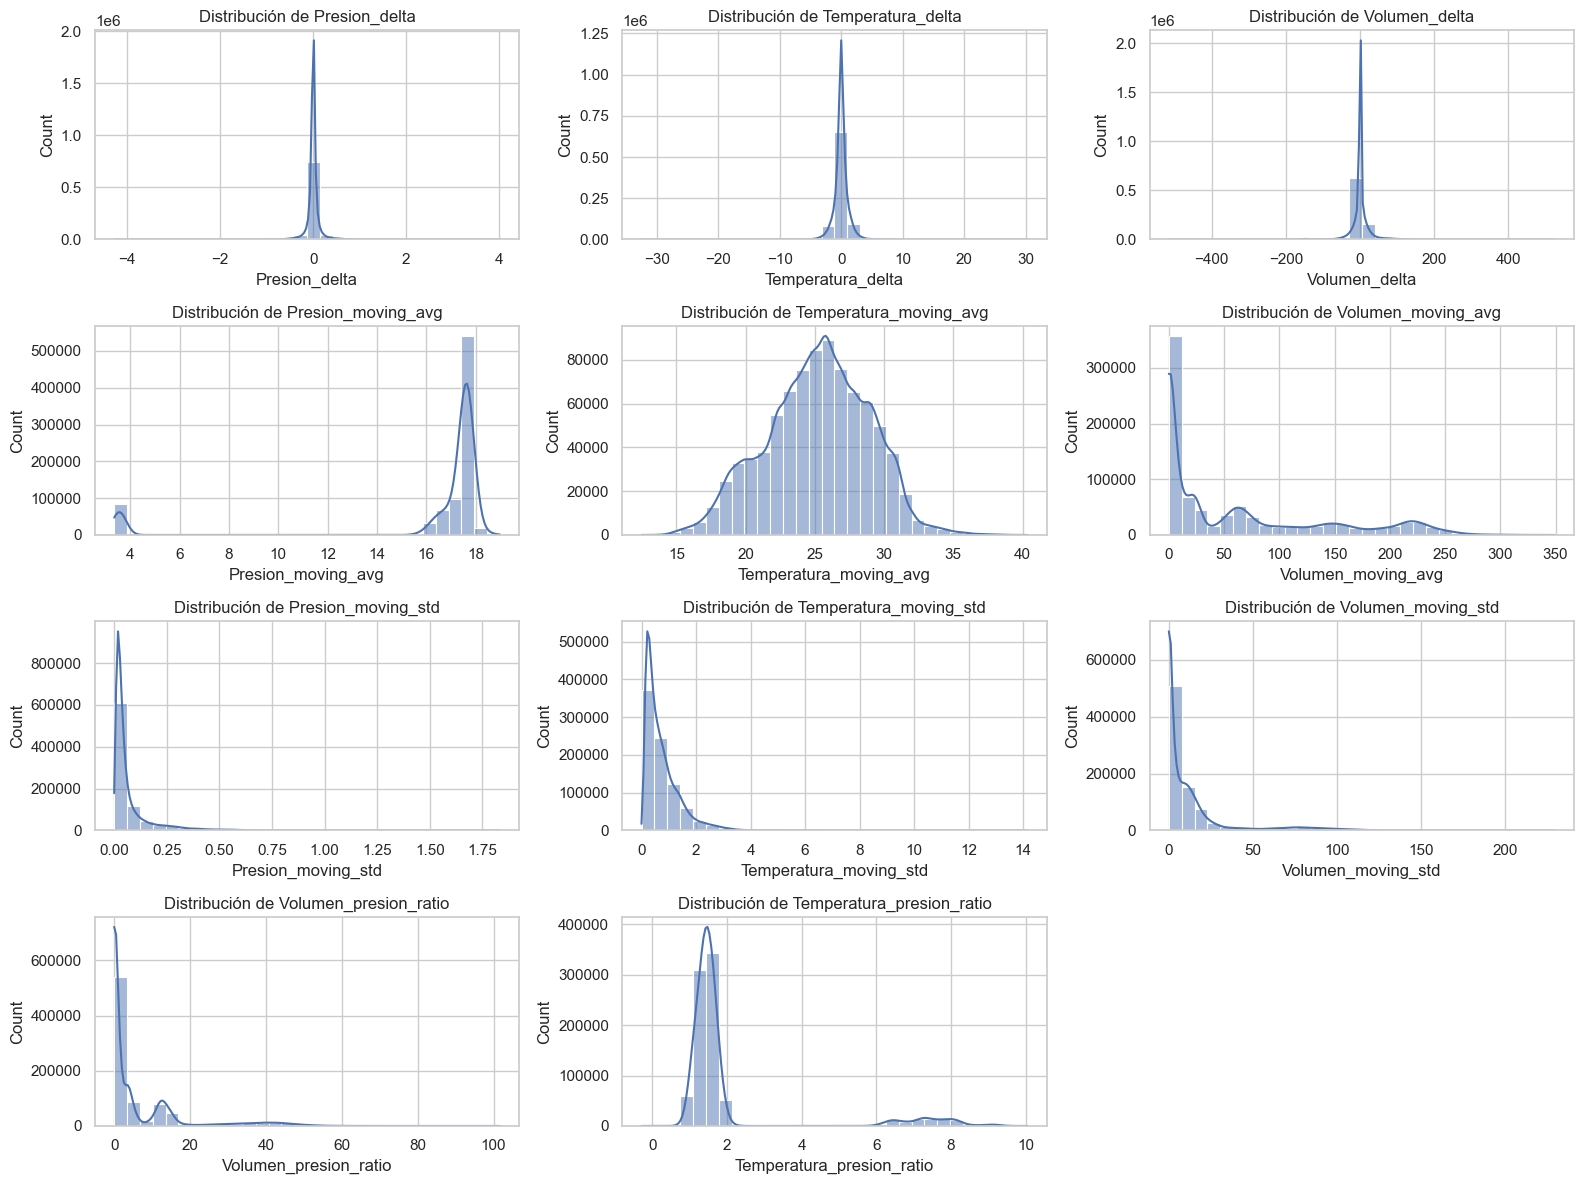

In [37]:
# --------------------------------------------
# Análisis General de las Nuevas Variables
# --------------------------------------------

# Estadísticas descriptivas generales
print("\nEstadísticas descriptivas generales de las nuevas variables:")
print(df_newfeatures[['Presion_delta', 'Temperatura_delta', 'Volumen_delta',
          'Presion_moving_avg', 'Temperatura_moving_avg', 'Volumen_moving_avg',
          'Presion_moving_std', 'Temperatura_moving_std', 'Volumen_moving_std',
          'Volumen_presion_ratio', 'Temperatura_presion_ratio']].describe())

# Histograma para las nuevas variables
variables = ['Presion_delta', 'Temperatura_delta', 'Volumen_delta',
             'Presion_moving_avg', 'Temperatura_moving_avg', 'Volumen_moving_avg',
             'Presion_moving_std', 'Temperatura_moving_std', 'Volumen_moving_std',
             'Volumen_presion_ratio', 'Temperatura_presion_ratio']

plt.figure(figsize=(16, 12))
for i, var in enumerate(variables):
    plt.subplot(4, 3, i + 1)
    sns.histplot(df_newfeatures[var].dropna(), kde=True, bins=30)
    plt.title(f"Distribución de {var}")
plt.tight_layout()
plt.show()




--- Análisis Descriptivo para el Cliente: CLIENTE1 ---
       Presion_delta  Temperatura_delta  Volumen_delta  Presion_moving_avg  \
count   43412.000000       43412.000000   43412.000000        43412.000000   
mean       -0.000043          -0.000039      -0.000252           17.536018   
std         0.035599           0.908694       2.895046            0.357389   
min        -1.390984          -6.686338     -51.964345           15.767522   
25%        -0.019094          -0.448596      -1.673127           17.594223   
50%        -0.000465          -0.003331       0.000000           17.651057   
75%         0.018544           0.448250       1.662683           17.711873   
max         1.380490           6.790508      47.578115           17.825216   

       Temperatura_moving_avg  Volumen_moving_avg  Presion_moving_std  \
count            43412.000000        43412.000000        43412.000000   
mean                25.575943           19.976870            0.021203   
std                  2

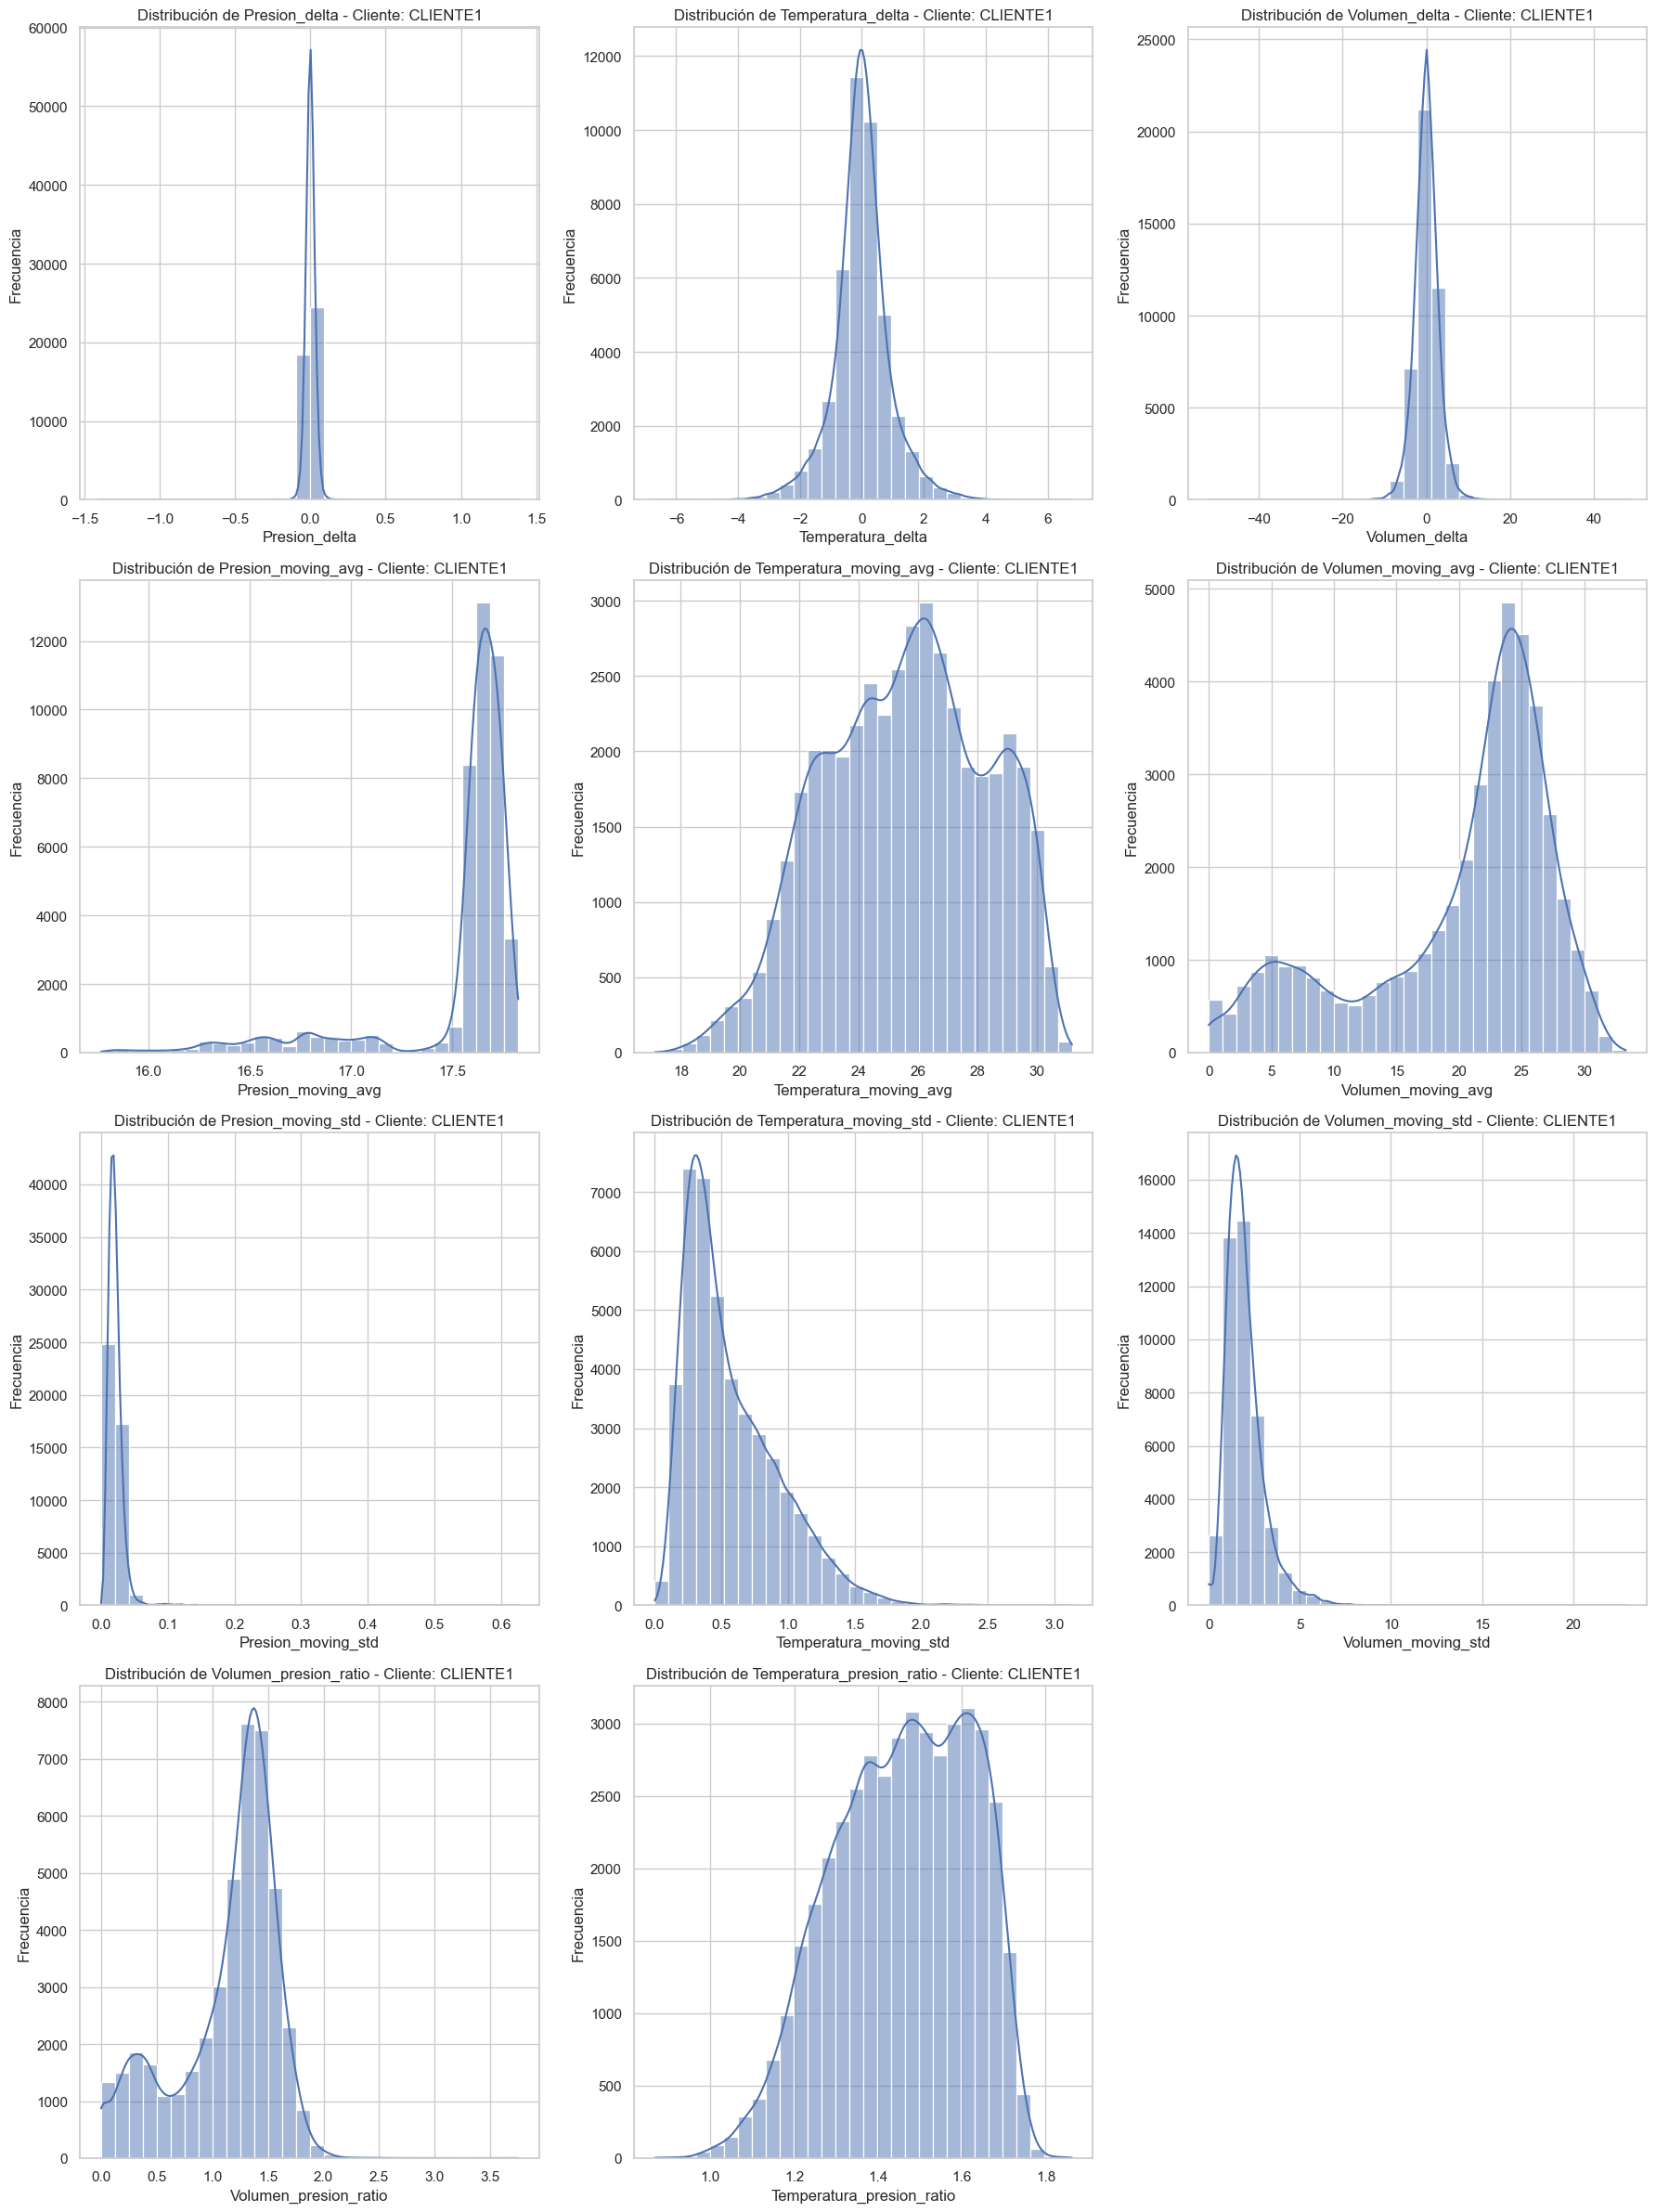


--- Análisis Descriptivo para el Cliente: CLIENTE10 ---
       Presion_delta  Temperatura_delta  Volumen_delta  Presion_moving_avg  \
count   41059.000000       41059.000000   4.105900e+04        41059.000000   
mean       -0.000002          -0.000046   4.519401e-18           17.473697   
std         0.082786           0.913370   1.475103e+01            0.123167   
min        -0.978143         -11.678552  -2.063691e+02           16.595795   
25%        -0.016560          -0.518862   0.000000e+00           17.417892   
50%        -0.000082          -0.002390   0.000000e+00           17.493652   
75%         0.016616           0.524577   0.000000e+00           17.564570   
max         0.995326          11.699670   1.817760e+02           17.782905   

       Temperatura_moving_avg  Volumen_moving_avg  Presion_moving_std  \
count            41059.000000        41059.000000        41059.000000   
mean                23.500582           11.788209            0.031100   
std                  

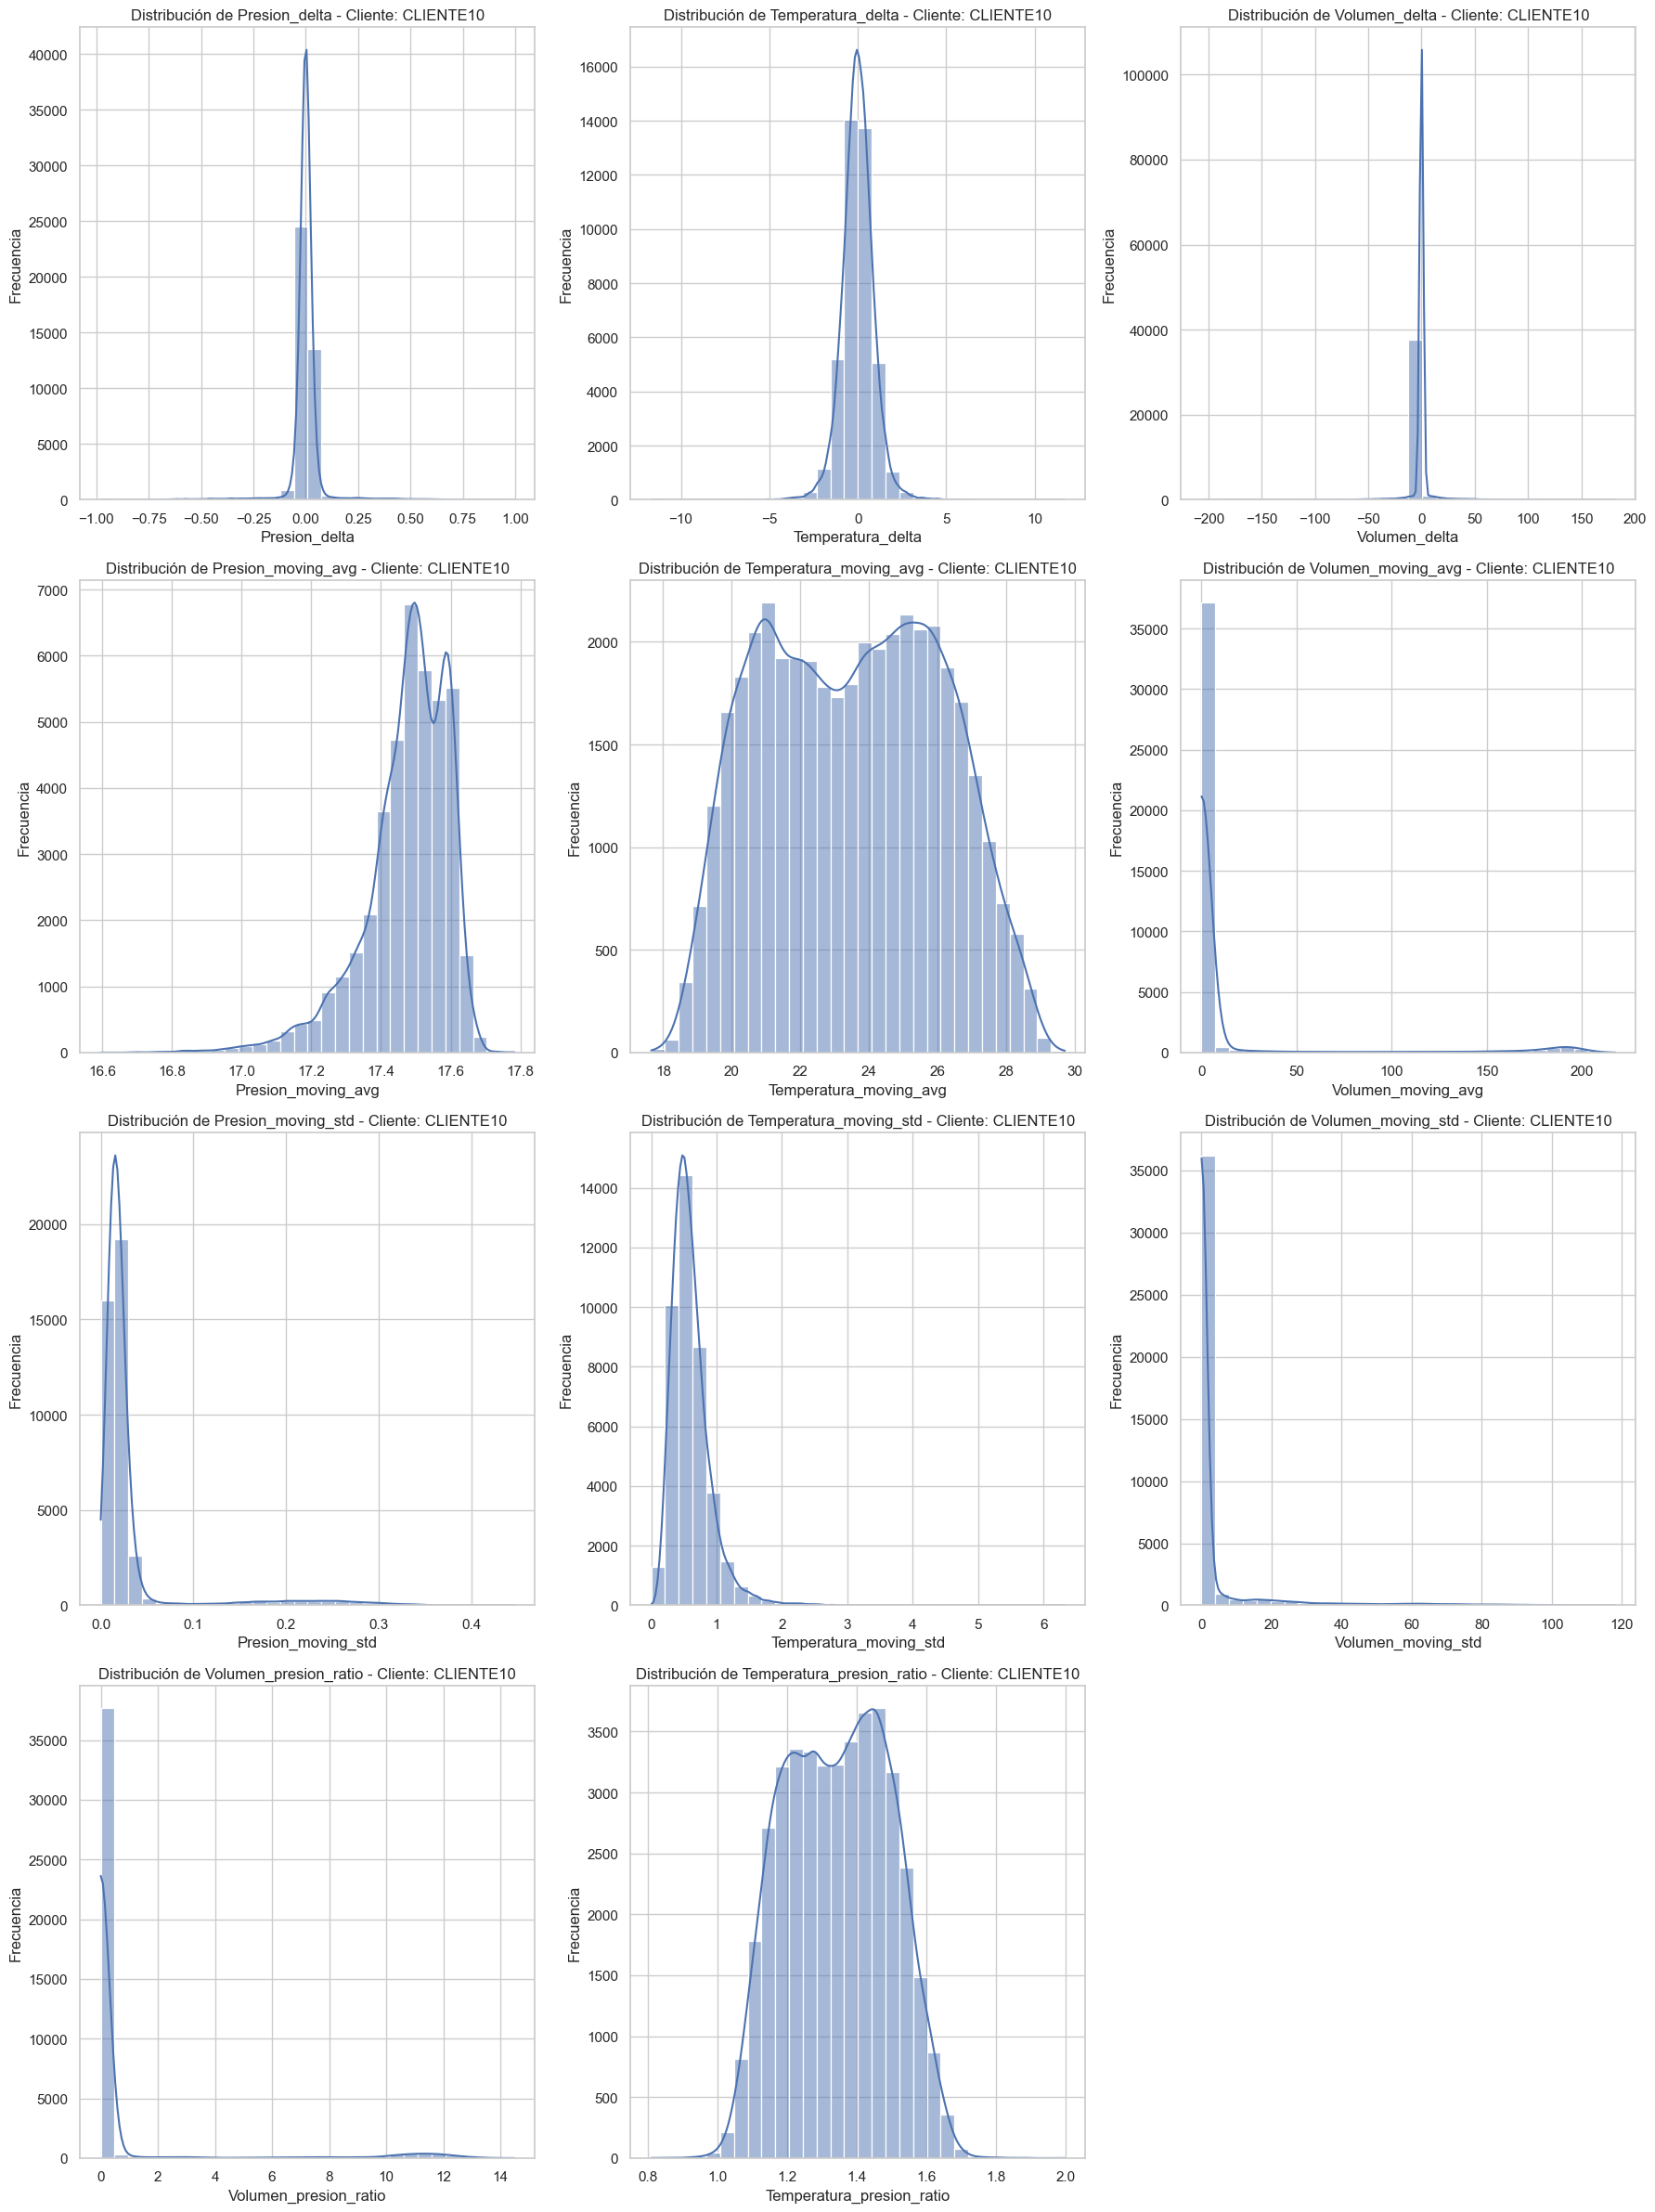


--- Análisis Descriptivo para el Cliente: CLIENTE11 ---
       Presion_delta  Temperatura_delta  Volumen_delta  Presion_moving_avg  \
count   42248.000000       42248.000000   42248.000000        42248.000000   
mean       -0.000002           0.000051       0.001316            3.545516   
std         0.058280           0.429353      24.711492            0.073146   
min        -0.590533         -12.391045    -146.833618            3.345486   
25%        -0.036545          -0.229427     -15.247688            3.497287   
50%         0.000336           0.000935      -0.014377            3.534118   
75%         0.036495           0.230269      15.202179            3.576022   
max         0.560211          11.538392     163.625525            3.847712   

       Temperatura_moving_avg  Volumen_moving_avg  Presion_moving_std  \
count            42248.000000        42248.000000        42248.000000   
mean                26.307044          131.646369            0.039764   
std                  

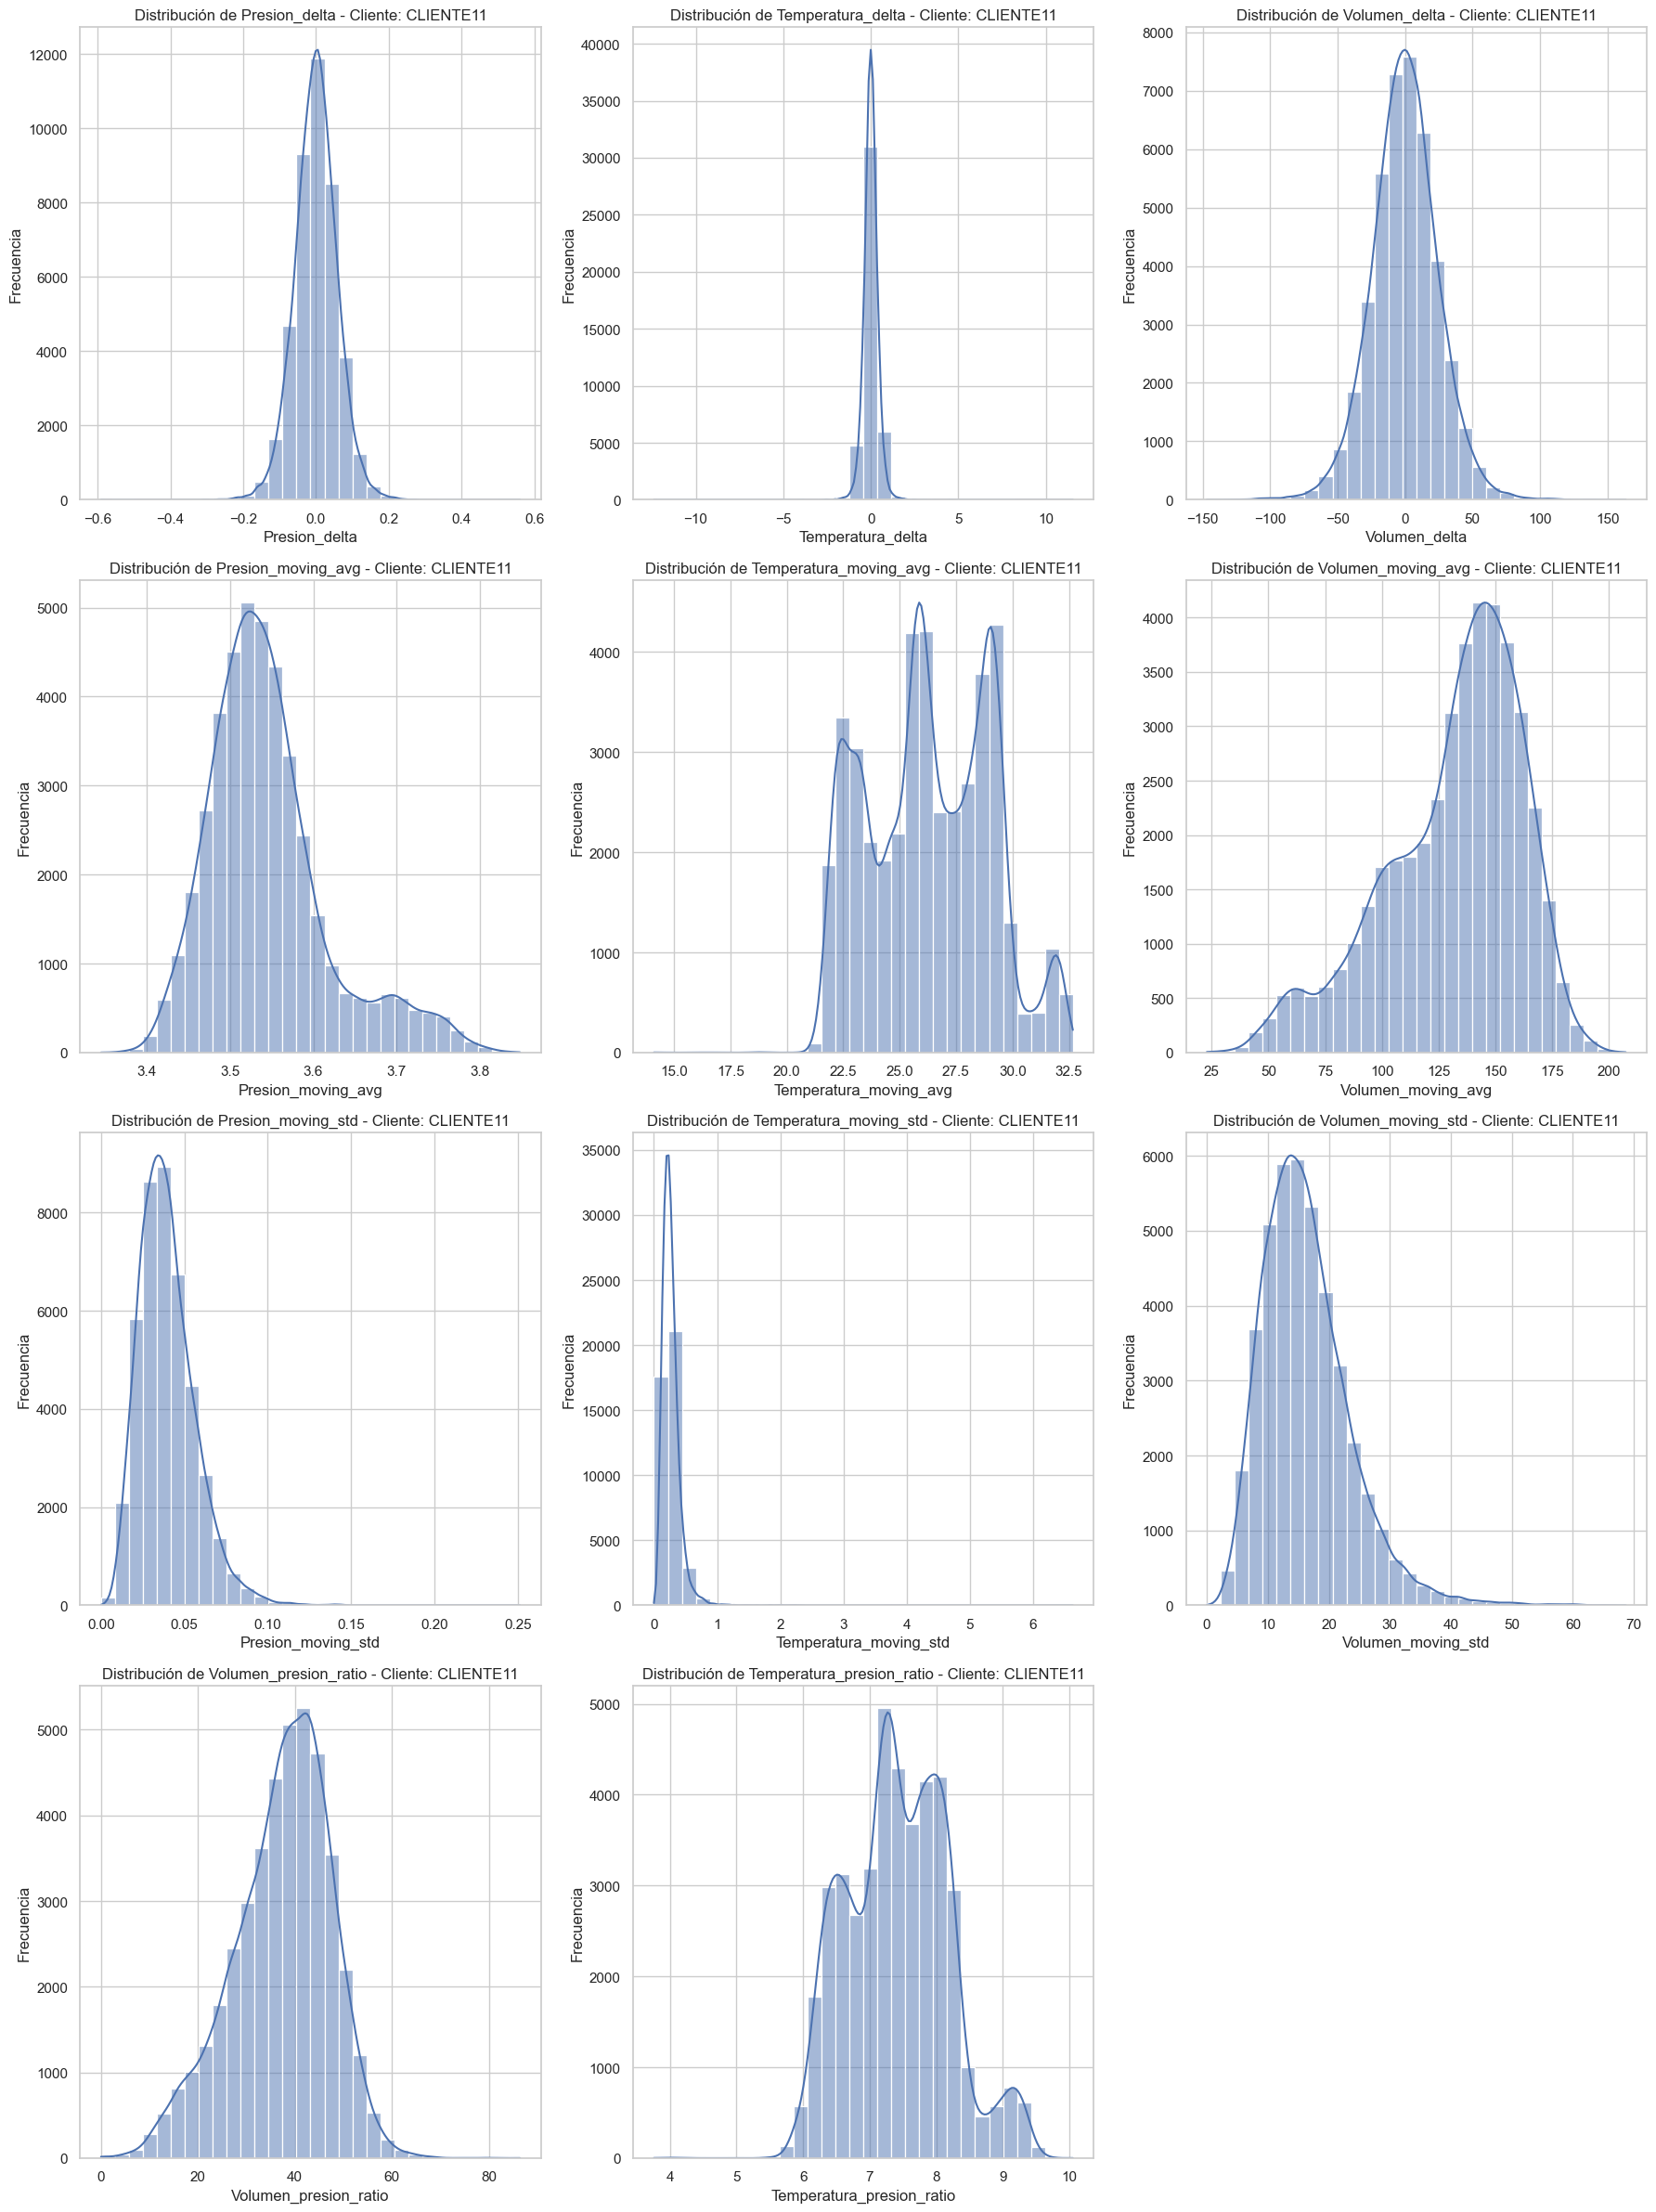

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

def analizar_cliente(df, cliente):
    """
    Realiza el análisis descriptivo y gráficos de distribución de las variables derivadas para un cliente específico.

    Args:
    - df (DataFrame): DataFrame que contiene los datos.
    - cliente (str): Identificador del cliente a analizar.

    Retorna:
    - Análisis descriptivo y gráficos de distribución de las variables para el cliente dado.
    """
    # Filtrar datos del cliente
    cliente_data = df[df['Cliente'] == cliente]

    # Variables derivadas a analizar
    variables = ['Presion_delta', 'Temperatura_delta', 'Volumen_delta',
                 'Presion_moving_avg', 'Temperatura_moving_avg', 'Volumen_moving_avg',
                 'Presion_moving_std', 'Temperatura_moving_std', 'Volumen_moving_std',
                 'Volumen_presion_ratio', 'Temperatura_presion_ratio']

    # Análisis descriptivo
    print(f"\n--- Análisis Descriptivo para el Cliente: {cliente} ---")
    print(cliente_data[variables].describe())

    # Generar gráficos de distribución
    num_vars = len(variables)
    num_rows = (num_vars + 2) // 3  # Calcular el número de filas para subplots

    plt.figure(figsize=(18, 6 * num_rows))
    for i, var in enumerate(variables):
        plt.subplot(num_rows, 3, i + 1)
        sns.histplot(cliente_data[var].dropna(), kde=True, bins=30)
        plt.title(f'Distribución de {var} - Cliente: {cliente}')
        plt.xlabel(var)
        plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

# --------------------------------------------
# Iterar sobre todos los clientes para realizar el análisis
# --------------------------------------------

# Obtener lista de clientes únicos
clientes = df_newfeatures['Cliente'].unique()[:3]

# Aplicar la función para cada cliente
for cliente in clientes:
    analizar_cliente(df_newfeatures, cliente)


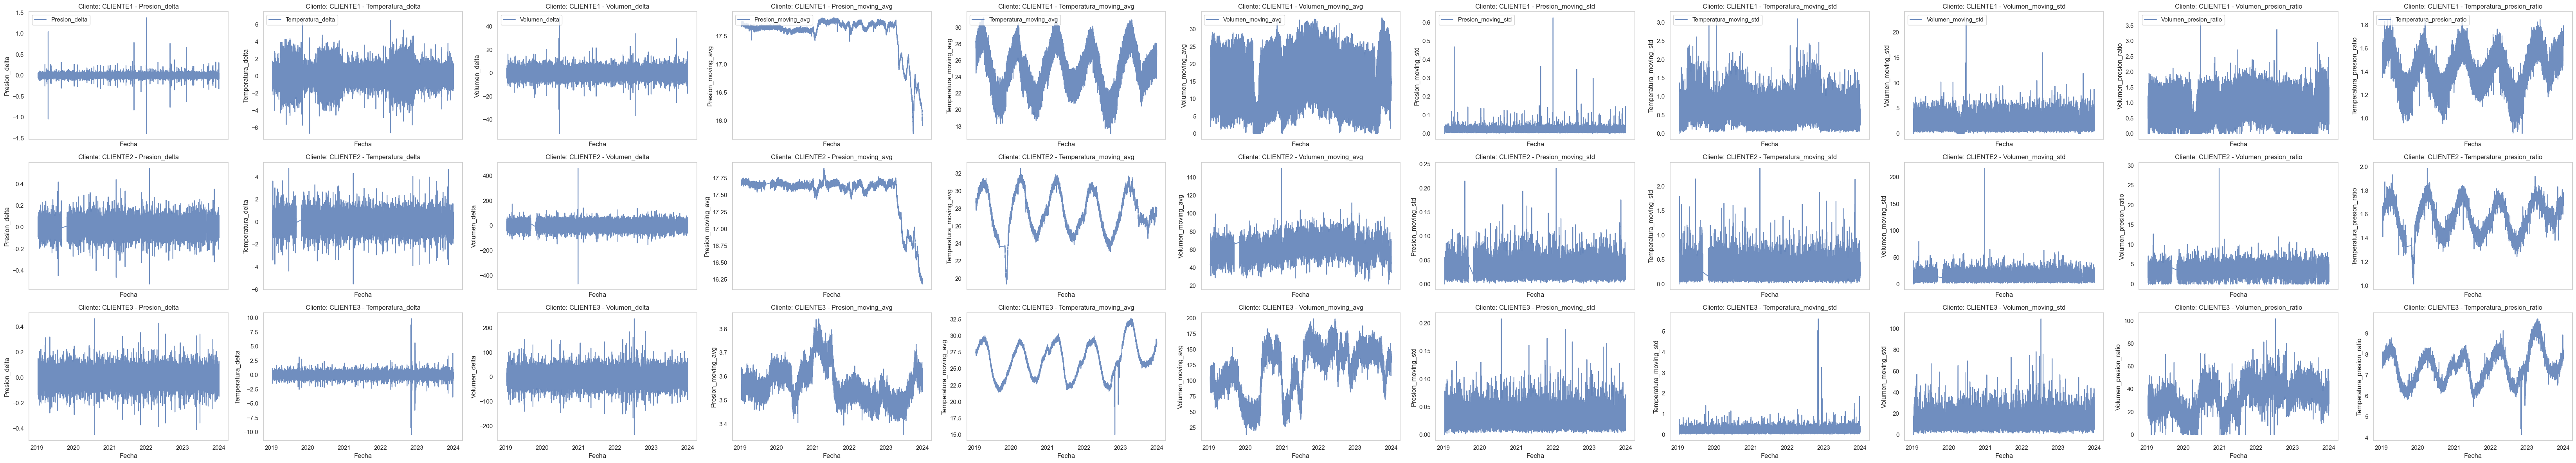

In [39]:
def graficar_series_por_cliente_y_variable(df, variables, clientes):
    """
    Genera un gráfico con las series de tiempo de las variables indicadas para cada cliente.
    Cada fila corresponde a un cliente y cada columna a una variable.

    Args:
    - df (DataFrame): DataFrame con los datos.
    - variables (list): Lista de variables a graficar.
    - clientes (list): Lista de clientes a incluir en los gráficos.

    Retorna:
    - Gráfico con la disposición solicitada.
    """
    num_clientes = len(clientes)
    num_variables = len(variables)

    # Crear la figura y los ejes
    fig, axes = plt.subplots(num_clientes, num_variables, figsize=(6 * num_variables, 4 * num_clientes), sharex=True)

    # Si solo hay un cliente o una variable, convertir a lista de listas para iterar
    if num_clientes == 1:
        axes = [axes]
    if num_variables == 1:
        axes = [[ax] for ax in axes]

    for i, cliente in enumerate(clientes):
        cliente_data = df[df['Cliente'] == cliente]
        for j, variable in enumerate(variables):
            ax = axes[i][j]
            ax.plot(cliente_data['Fecha'], cliente_data[variable], label=f'{variable}', alpha=0.8)
            ax.set_title(f'Cliente: {cliente} - {variable}')
            ax.set_xlabel('Fecha')
            ax.set_ylabel(variable)
            ax.grid()
            if i == 0:
                ax.legend(loc='upper left')

    # Ajustar espaciado entre los gráficos
    plt.tight_layout()
    plt.show()

# --------------------------------------------
# Uso de la Función
# --------------------------------------------

# Lista de variables a graficar
variables_a_graficar = ['Presion_delta', 'Temperatura_delta', 'Volumen_delta',
                 'Presion_moving_avg', 'Temperatura_moving_avg', 'Volumen_moving_avg',
                 'Presion_moving_std', 'Temperatura_moving_std', 'Volumen_moving_std',
                 'Volumen_presion_ratio', 'Temperatura_presion_ratio']

# Lista de clientes a incluir en los gráficos
clientes_a_incluir = df['Cliente'].unique()[:3]   # Los primeros 3 clientes como ejemplo

# Llamar a la función
graficar_series_por_cliente_y_variable(df_newfeatures, variables_a_graficar, clientes_a_incluir)


### Segmentación de los Datos para Encontrar Patrones


Resumen promedio por Cliente y Día de la Semana:
      Cliente Dia_semana    Presion  Temperatura    Volumen
0    CLIENTE1     Friday  17.536107    26.085398  24.064920
1    CLIENTE1     Monday  17.538637    25.133059  16.643483
2    CLIENTE1   Saturday  17.534114    26.044245  23.177951
3    CLIENTE1     Sunday  17.531900    25.590801  19.546513
4    CLIENTE1   Thursday  17.537901    25.670348  21.016165
..        ...        ...        ...          ...        ...
135  CLIENTE9   Saturday  17.463327    22.085161  14.817175
136  CLIENTE9     Sunday  17.456938    22.076283  16.985358
137  CLIENTE9   Thursday  17.467873    22.103907  11.996165
138  CLIENTE9    Tuesday  17.467765    22.067803  11.715140
139  CLIENTE9  Wednesday  17.467673    22.069177  11.561091

[140 rows x 5 columns]

Resumen promedio por Cliente y Hora:
      Cliente  Hora    Presion  Temperatura    Volumen
0    CLIENTE1     0  17.533661    25.562288  19.645070
1    CLIENTE1     1  17.529844    25.587113  19.878443
2  

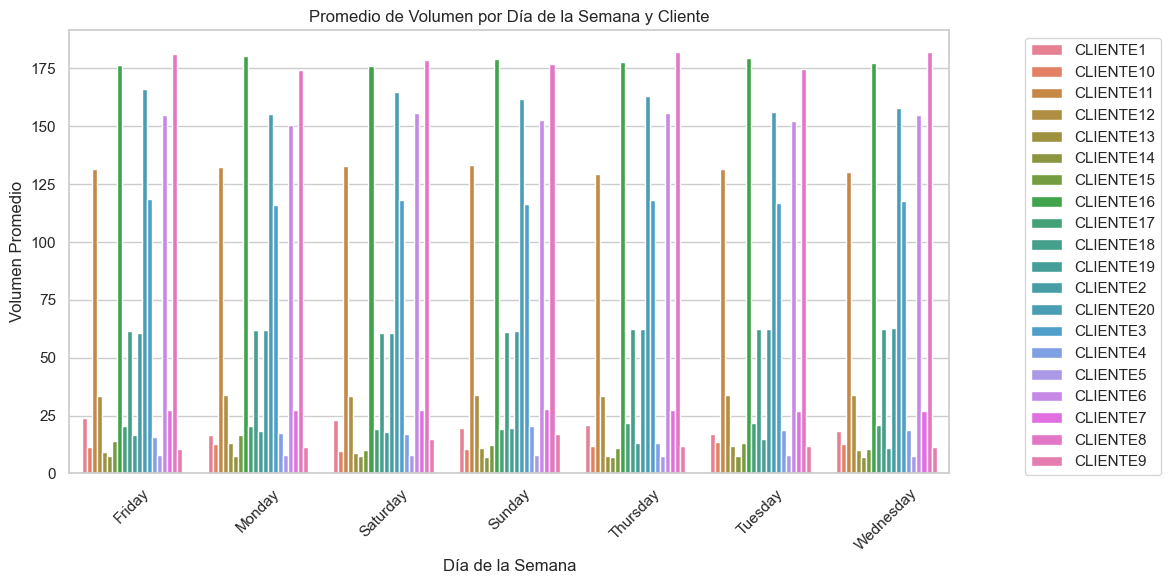

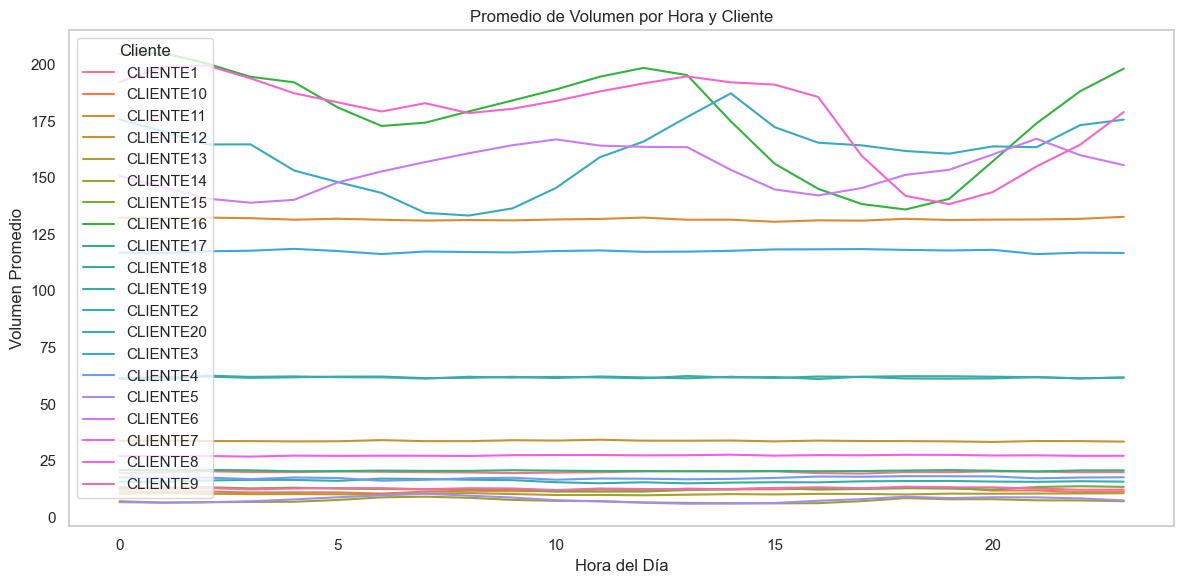

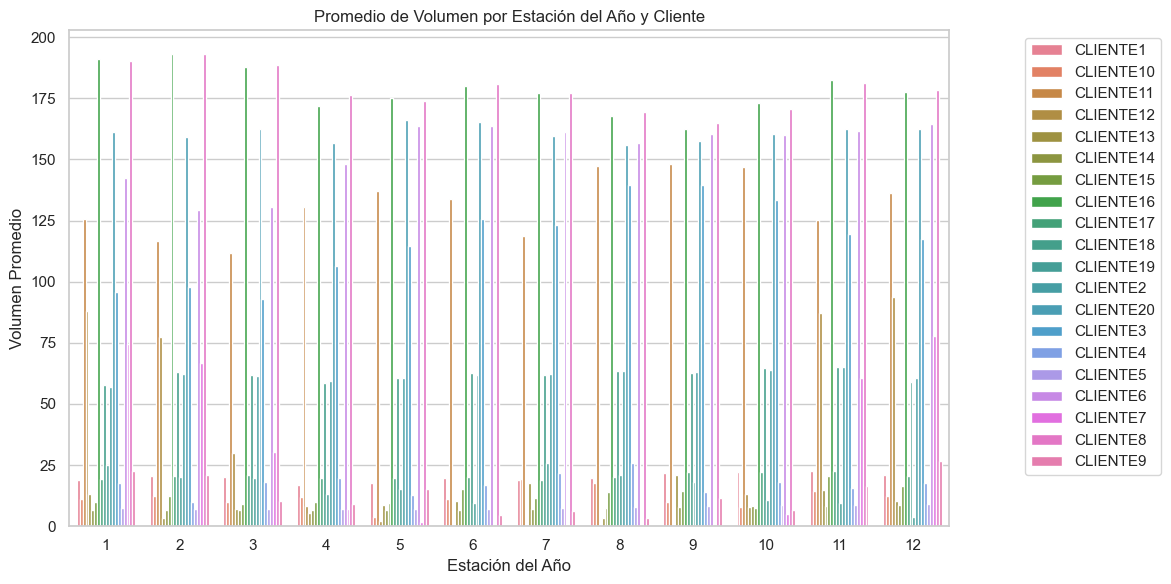

In [40]:
def segmentar_y_analizar(df):
    """
    Segmenta los datos por cliente, día de la semana, hora y estación del año
    para identificar patrones específicos.

    Args:
    - df (DataFrame): DataFrame que contiene las columnas 'Fecha', 'Cliente', y las variables a analizar.

    Retorna:
    - Análisis segmentado y visualizaciones.
    """
    # Resumen por Cliente y Día de la Semana
    resumen_dia = df.groupby(['Cliente', 'Dia_semana'])[['Presion', 'Temperatura', 'Volumen']].mean().reset_index()
    print("\nResumen promedio por Cliente y Día de la Semana:")
    print(resumen_dia)

    # Resumen por Cliente y Hora
    resumen_hora = df.groupby(['Cliente', 'Hora'])[['Presion', 'Temperatura', 'Volumen']].mean().reset_index()
    print("\nResumen promedio por Cliente y Hora:")
    print(resumen_hora)

    # Resumen por Cliente y Estación
    resumen_estacion = df.groupby(['Cliente', 'Mes'])[['Presion', 'Temperatura', 'Volumen']].mean().reset_index()
    print("\nResumen promedio por Cliente y mes:")
    print(resumen_estacion)

    # Visualizaciones

    # Distribución promedio por día de la semana
    plt.figure(figsize=(12, 6))
    sns.barplot(data=resumen_dia, x='Dia_semana', y='Volumen', hue='Cliente')
    plt.title('Promedio de Volumen por Día de la Semana y Cliente')
    plt.xlabel('Día de la Semana')
    plt.ylabel('Volumen Promedio')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.tight_layout()
    plt.show()

    # Distribución promedio por hora
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=resumen_hora, x='Hora', y='Volumen', hue='Cliente')
    plt.title('Promedio de Volumen por Hora y Cliente')
    plt.xlabel('Hora del Día')
    plt.ylabel('Volumen Promedio')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Distribución promedio por estación del año
    plt.figure(figsize=(12, 6))
    sns.barplot(data=resumen_estacion, x='Mes', y='Volumen', hue='Cliente')
    plt.title('Promedio de Volumen por Estación del Año y Cliente')
    plt.xlabel('Estación del Año')
    plt.ylabel('Volumen Promedio')
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.tight_layout()
    plt.show()

# --------------------------------------------
# Uso de la Función
# --------------------------------------------

# Extraer día de la semana, hora y estación del año de la columna Fecha
df_newfeatures['Dia_semana'] = df_newfeatures['Fecha'].dt.day_name()  # Nombre del día de la semana
df_newfeatures['Hora'] = df_newfeatures['Fecha'].dt.hour  # Hora del día
df_newfeatures['Mes'] = df_newfeatures['Fecha'].dt.month  # Mes para determinar la estación

# Llamar a la función con el DataFrame limpio
segmentar_y_analizar(df_newfeatures)


In [41]:
df_newfeatures.head(5)

Fecha    Presion  Temperatura    Volumen   Cliente  \
0 2019-01-14 00:00:00  17.732563    28.209354  20.969751  CLIENTE1   
1 2019-01-14 01:00:00  17.747776    28.518614  17.845739  CLIENTE1   
2 2019-01-14 02:00:00  17.758916    28.230191  20.975914  CLIENTE1   
3 2019-01-14 03:00:00  17.727940    27.811509  20.592299  CLIENTE1   
4 2019-01-14 04:00:00  17.746484    27.795293  21.690626  CLIENTE1   

   Presion_delta  Temperatura_delta  Volumen_delta  Presion_moving_avg  \
0       0.000000           0.000000       0.000000           17.732563   
1       0.015213           0.309261      -3.124012           17.740170   
2       0.011140          -0.288424       3.130175           17.746419   
3      -0.030976          -0.418682      -0.383615           17.741799   
4       0.018544          -0.016215       1.098327           17.742736   

   Temperatura_moving_avg  Volumen_moving_avg  Presion_moving_std  \
0               28.209354           20.969751            0.000000   
1               28.363984           19.407745            0.010757   
2               28.319386           19.930468            0.013229   
3               28.192417           20.095926            0.014214   
4               28.112992           20.414866            0.012486   

   Temperatura_moving_std  Volumen_moving_std  Volumen_presion_ratio  \
0                0.000000            0.000000               1.182556   
1                0.218680            2.209010               1.005520   
2                0.172851            1.805431               1.181148   
3                0.290522            1.510814               1.161573   
4                0.307967            1.490145               1.222249   

   Temperatura_presion_ratio Dia_semana  Hora  Mes  
0                   1.590822     Monday     0    1  
1                   1.606884     Monday     1    1  
2                   1.589635     Monday     2    1  
3                   1.568795     Monday     3    1  
4                   1.566242     Monday     4    1

Explicación de las Nuevas Variables

Tasa de cambio (delta): Representa la variación entre un registro y el siguiente, útil para detectar tendencias y cambios bruscos,
Ejemplo: Presion_delta = Presion_actual - Presion_anterior.

Media móvil (moving_avg):Captura el promedio de los últimos valores, suavizando fluctuaciones a corto plazo, Útil para identificar patrones más estables.

Desviación estándar móvil (moving_std):Mide la variabilidad en un periodo reciente, Indica estabilidad o inestabilidad operativa.

Ratios entre variables: Relación entre Volumen y Presión o Temperatura y Presión, que puede destacar patrones de comportamiento conjunto.

### Clasificación o Agrupación

In [47]:
df.head()

Fecha    Presion  Temperatura    Volumen   Cliente  Cluster
0 2019-01-14 00:00:00  17.732563    28.209354  20.969751  CLIENTE1        1
1 2019-01-14 01:00:00  17.747776    28.518614  17.845739  CLIENTE1        1
2 2019-01-14 02:00:00  17.758916    28.230191  20.975914  CLIENTE1        1
3 2019-01-14 03:00:00  17.727940    27.811509  20.592299  CLIENTE1        1
4 2019-01-14 04:00:00  17.746484    27.795293  21.690626  CLIENTE1        1

c:\Users\johan\.conda\envs\optigas\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\johan\.conda\envs\optigas\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\johan\.conda\envs\optigas\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\johan\.conda\envs\optigas\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\johan\.conda\envs\optigas\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(ex

K-Means aplicado con 3 clústeres.
Centroides:
[[ 0.24268834  0.59645563  1.69384454]
 [ 0.35423192 -0.19977969 -0.55712386]
 [-2.98953452  0.2979964   0.77326297]]


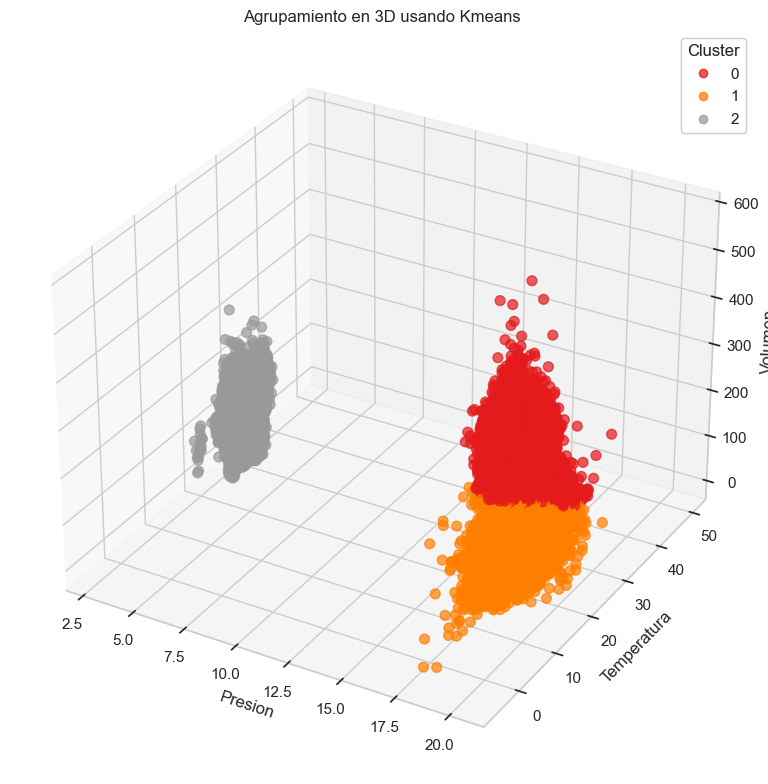

In [42]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def clasificar_agrupacion_3d(df, variables, metodo='kmeans', n_clusters=3, eps=0.5, min_samples=5):
    """
    Realiza agrupación de clientes o periodos de tiempo según patrones operativos utilizando K-Means, DBSCAN o Clustering Jerárquico.
    Incluye una visualización 3D para las variables seleccionadas.

    Args:
    - df (DataFrame): DataFrame con los datos.
    - variables (list): Lista de variables a utilizar para el agrupamiento.
    - metodo (str): Algoritmo de agrupamiento ('kmeans', 'dbscan', 'jerarquico').
    - n_clusters (int): Número de clústeres (para K-Means y clustering jerárquico).
    - eps (float): Distancia máxima entre puntos para DBSCAN.
    - min_samples (int): Número mínimo de puntos para formar un clúster en DBSCAN.

    Retorna:
    - DataFrame con la asignación de clústeres y un gráfico 3D.
    """
    # Filtrar y escalar las variables
    data = df[variables]
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    if metodo == 'kmeans':
        # K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        df['Cluster'] = kmeans.fit_predict(data_scaled)
        print(f"K-Means aplicado con {n_clusters} clústeres.")
        print("Centroides:")
        print(kmeans.cluster_centers_)

    elif metodo == 'dbscan':
        # DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        df['Cluster'] = dbscan.fit_predict(data_scaled)
        print(f"DBSCAN aplicado con eps={eps} y min_samples={min_samples}.")
        print("Clústeres formados:")
        print(df['Cluster'].value_counts())

    elif metodo == 'jerarquico':
        # Clustering Jerárquico
        linkage_matrix = linkage(data_scaled, method='ward')
        plt.figure(figsize=(12, 8))
        dendrogram(linkage_matrix, truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=10)
        plt.title('Dendrograma - Clustering Jerárquico')
        plt.xlabel('Índices de Muestras')
        plt.ylabel('Distancia')
        plt.tight_layout()
        plt.show()
        # Asignar clústeres según corte
        from scipy.cluster.hierarchy import fcluster
        df['Cluster'] = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
        print(f"Clustering jerárquico aplicado con {n_clusters} clústeres.")

    else:
        raise ValueError("Método no reconocido. Usa 'kmeans', 'dbscan' o 'jerarquico'.")

    # Visualización 3D de los clústeres
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        df[variables[0]],
        df[variables[1]],
        df[variables[2]],
        c=df['Cluster'],
        cmap='Set1',
        s=50,
        alpha=0.7
    )
    ax.set_title(f'Agrupamiento en 3D usando {metodo.capitalize()}')
    ax.set_xlabel(variables[0])
    ax.set_ylabel(variables[1])
    ax.set_zlabel(variables[2])
    legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
    ax.add_artist(legend1)
    plt.tight_layout()
    plt.show()

    return df

# --------------------------------------------
# Uso de la Función
# --------------------------------------------

# Lista de variables para agrupar (en 3D)
variables_para_agrupamiento = ['Presion', 'Temperatura', 'Volumen']

# Aplicar la función para K-Means con visualización en 3D
df_kmeans = clasificar_agrupacion_3d(df, variables_para_agrupamiento, metodo='kmeans', n_clusters=3)

# Aplicar la función para DBSCAN con visualización en 3D
#df_dbscan = clasificar_agrupacion_3d(df, variables_para_agrupamiento, metodo='dbscan', eps=0.7, min_samples=10)

# Aplicar la función para Clustering Jerárquico con visualización en 3D
#df_jerarquico = clasificar_agrupacion_3d(df, variables_para_agrupamiento, metodo='jerarquico', n_clusters=3)


In [43]:
df_consolidado = pd.merge(df_newfeatures, df_kmeans[['Fecha', 'Cliente', 'Cluster']], on=['Fecha', 'Cliente'], how='left')

# Mostrar las primeras filas del DataFrame unido
df_consolidado.head(5)

Fecha    Presion  Temperatura    Volumen   Cliente  \
0 2019-01-14 00:00:00  17.732563    28.209354  20.969751  CLIENTE1   
1 2019-01-14 01:00:00  17.747776    28.518614  17.845739  CLIENTE1   
2 2019-01-14 02:00:00  17.758916    28.230191  20.975914  CLIENTE1   
3 2019-01-14 03:00:00  17.727940    27.811509  20.592299  CLIENTE1   
4 2019-01-14 04:00:00  17.746484    27.795293  21.690626  CLIENTE1   

   Presion_delta  Temperatura_delta  Volumen_delta  Presion_moving_avg  \
0       0.000000           0.000000       0.000000           17.732563   
1       0.015213           0.309261      -3.124012           17.740170   
2       0.011140          -0.288424       3.130175           17.746419   
3      -0.030976          -0.418682      -0.383615           17.741799   
4       0.018544          -0.016215       1.098327           17.742736   

   Temperatura_moving_avg  Volumen_moving_avg  Presion_moving_std  \
0               28.209354           20.969751            0.000000   
1               28.363984           19.407745            0.010757   
2               28.319386           19.930468            0.013229   
3               28.192417           20.095926            0.014214   
4               28.112992           20.414866            0.012486   

   Temperatura_moving_std  Volumen_moving_std  Volumen_presion_ratio  \
0                0.000000            0.000000               1.182556   
1                0.218680            2.209010               1.005520   
2                0.172851            1.805431               1.181148   
3                0.290522            1.510814               1.161573   
4                0.307967            1.490145               1.222249   

   Temperatura_presion_ratio Dia_semana  Hora  Mes  Cluster  
0                   1.590822     Monday     0    1        1  
1                   1.606884     Monday     1    1        1  
2                   1.589635     Monday     2    1        1  
3                   1.568795     Monday     3    1        1  
4                   1.566242     Monday     4    1        1

In [44]:
# Contar registros por cliente y clúster
conteo = df_consolidado.groupby(['Cliente', 'Cluster']).size().reset_index(name='Cantidad')

# Ordenar los resultados para una visualización más clara
conteo = conteo.sort_values(by=['Cliente', 'Cluster'])

print("\nCantidad de registros por cliente y clúster:")
print(conteo)


Cantidad de registros por cliente y clúster:
      Cliente  Cluster  Cantidad
0    CLIENTE1        1     43412
1   CLIENTE10        0      2254
2   CLIENTE10        1     38805
3   CLIENTE11        2     42250
4   CLIENTE12        0     11942
5   CLIENTE12        1     29834
6   CLIENTE13        0      1800
7   CLIENTE13        1     39259
8   CLIENTE14        0       223
9   CLIENTE14        1     43192
10  CLIENTE15        0      1961
11  CLIENTE15        1     40467
12  CLIENTE16        0     33231
13  CLIENTE16        1      9918
14  CLIENTE17        1     43412
15  CLIENTE18        0      3509
16  CLIENTE18        1     37883
17  CLIENTE19        0      2676
18  CLIENTE19        1     39629
19   CLIENTE2        0      3006
20   CLIENTE2        1     38386
21  CLIENTE20        0     30926
22  CLIENTE20        1     11882
23   CLIENTE3        2     42250
24   CLIENTE4        0      2926
25   CLIENTE4        1     39379
26   CLIENTE5        0         9
27   CLIENTE5        1     434

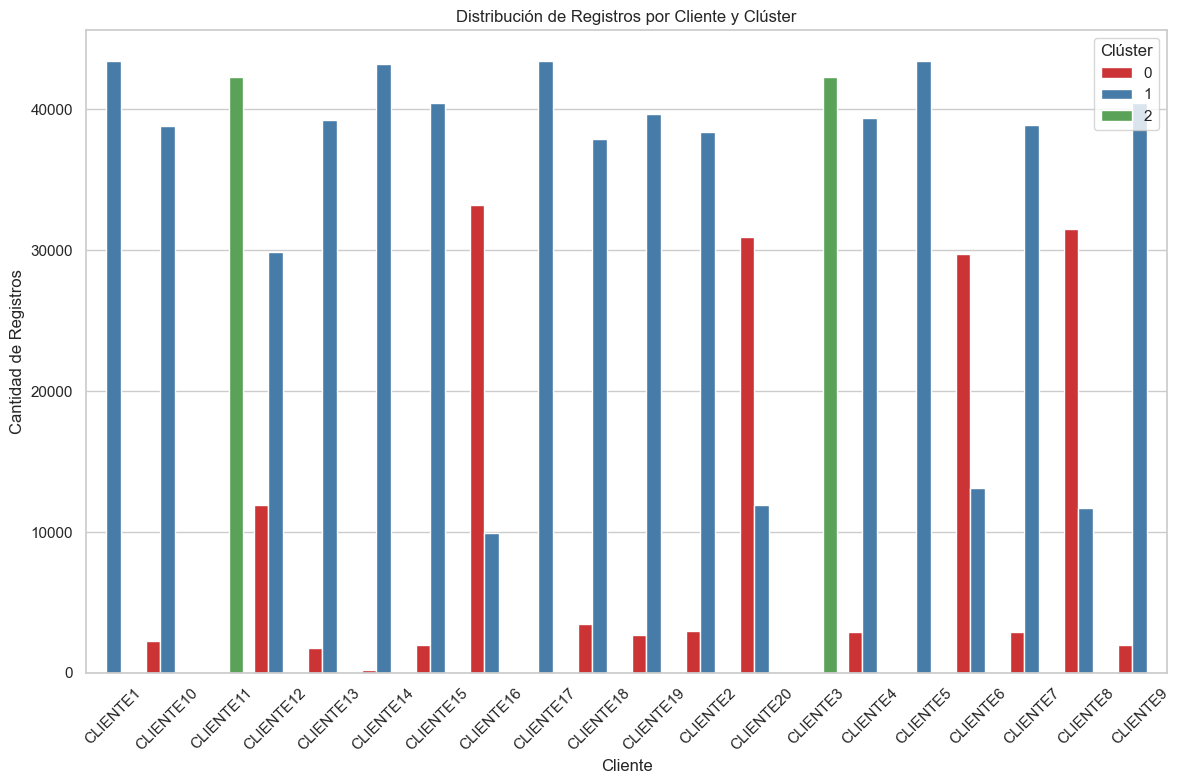

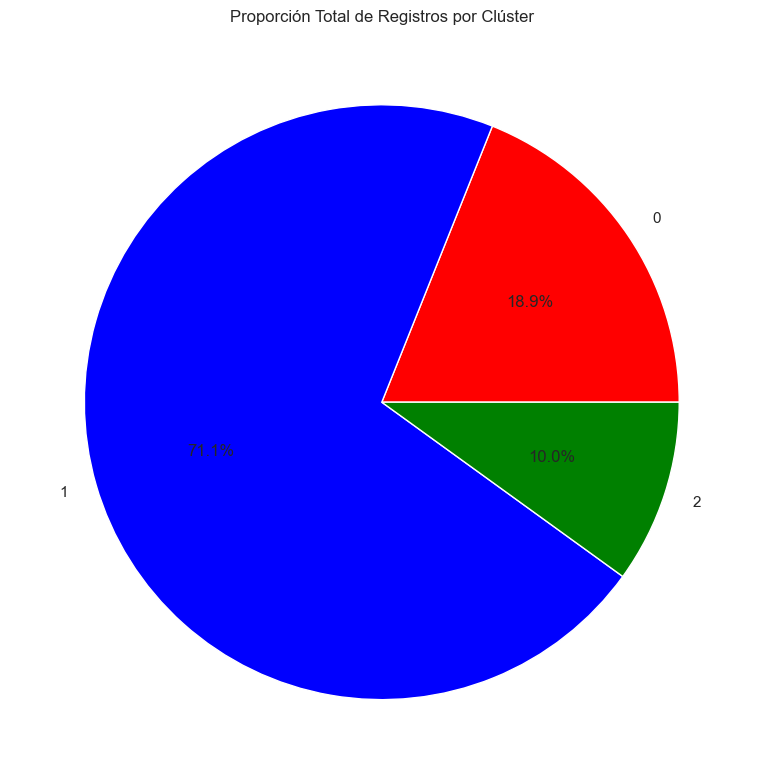

In [45]:
# Gráfico de barras apiladas por cliente
plt.figure(figsize=(12, 8))
sns.barplot(data=conteo, x='Cliente', y='Cantidad', hue='Cluster', palette='Set1')
plt.title('Distribución de Registros por Cliente y Clúster')
plt.xlabel('Cliente')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=45)
plt.legend(title='Clúster')
plt.tight_layout()
plt.show()

# Gráfico circular para la proporción total por clúster
proporciones = conteo.groupby('Cluster')['Cantidad'].sum()
plt.figure(figsize=(8, 8))
proporciones.plot.pie(autopct='%1.1f%%', colors=['red', 'blue', 'green'])
plt.title('Proporción Total de Registros por Clúster')
plt.ylabel('')
plt.tight_layout()
plt.show()


1. Distribución General por Clúster

- Clústeres Identificados: Los clientes están asignados principalmente a tres clústeres: 0, 1 y 2.
- El clúster 2 aparece exclusivamente para CLIENTE11 y CLIENTE3.

- Clúster Dominante: El clúster 1 es el predominante para la mayoría de los clientes, indicando patrones similares en sus registros.

2. Análisis por Cliente

- Clientes con Exclusividad en un Clúster: Algunos clientes tienen todos sus registros en un solo clúster:
    - CLIENTE1, CLIENTE17 (Clúster 1)
    - CLIENTE11, CLIENTE3 (Clúster 2)

- Clientes con Distribución en Múltiples Clústeres: Varios clientes tienen sus registros distribuidos entre los clústeres 0 y 1, lo que indica una posible variabilidad en su comportamiento:
    - Ejemplo: CLIENTE10, CLIENTE12, CLIENTE20, etc.

- Clientes con Mayor Variabilidad: CLIENTE16, CLIENTE6, y CLIENTE20 tienen proporciones notables entre clústeres 0 y 1, lo que podría reflejar cambios operativos o estacionales.


3. Proporción de Registros por Clúster y Cliente
Clientes con Mayor Proporción en Clúster 0:
  - CLIENTE16 y CLIENTE6 tienen una proporción significativa de registros en el clúster 0, sugiriendo patrones operativos distintos al resto.

Clientes con Mayor Proporción en Clúster 1:
  - Clientes como CLIENTE5 (99.98% en clúster 1) y CLIENTE17 están casi completamente asignados al clúster 1.

Clientes en Clúster 2:
  - CLIENTE11 y CLIENTE3 son los únicos con asignaciones completas en el clúster 2, indicando que tienen un comportamiento único comparado con los otros clientes.


4. Interpretación Operativa
Clúster 0: Representa un patrón menos común pero significativo para ciertos clientes (CLIENTE16, CLIENTE20).
Posible relación con variaciones específicas en condiciones operativas o temporales (Posibles anomalias).

Clúster 1: Patrones más comunes y homogéneos en los datos, probablemente representando operaciones estándar para la mayoría de los clientes.

Clúster 2:Exclusivo para dos clientes (CLIENTE11 y CLIENTE3), lo que indica comportamientos muy específicos en sus patrones de operación (posibles anomalias).

## Resultados y conclusiones

**Parte l. Características de calidad de los datos**

**Completitud**

- Resultado: No hay valores nulos en ninguna de las columnas (Fecha, Presión,Temperatura, Volumen, Cliente).
- Conclusión: Los datos están completos, lo que garantiza la base necesaria para los análisis sin necesidad de imputar datos faltantes.

*Consistencia**

Estadísticas descriptivas generales:
- Presión: Media de 16.07 bar, con un rango amplio (mínimo 2.93 y máximo 20.30 bar).
- Temperatura: Media de 25.19°C, con valores extremos desde -5.25°C hasta 50.01°C.
- Volumen: Media de 62.32 m³, con un rango notable (0 a 577.41 m³).

Conclusión: Aunque los valores globales muestran consistencia en las definiciones de las variables, existen valores extremos que requieren evaluación adicional.

Formato

Todas las columnas tienen un formato adecuado para análisis:
- Fecha: En formato datetime.
- Variables operativas (Presión, Temperatura, Volumen): Numéricas (float).
- Cliente: Categórica.

**Limpieza de Datos**

Identificación de Valores Extremos

Criterio: Se utilizaron los límites del rango intercuartil (IQR).

Resultados Globales:
- Presión: 105,110 valores extremos.
- Temperatura: 4,420 valores extremos.
- Volumen: 19,031 valores extremos.


Resultados por Cliente:
- Los clientes presentan diferentes niveles de valores extremos, especialmente en Volumen, donde algunos tienen más del 50% de sus datos marcados como extremos.


Procesos Aplicados:

Validación de valores extremos: Los valores extremos representan condiciones operativas reales y no se eliminaron.


**Entendimiento de los Datos**

Estadísticas Descriptivas por Cliente
- Se identificaron diferencias significativas entre los clientes en términos de consumo (Volumen), rangos de operación (Presión) y condiciones de entorno (Temperatura).
- Algunos clientes tienen un rango operacional muy limitado, mientras que otros muestran mayor variabilidad.


Correlaciones entre Variables

- Presión y Volumen: Correlación negativa (-0.30), lo que sugiere una relación inversa en ciertas condiciones.
- Temperatura y Volumen: Correlación positiva (0.33), indicando que el volumen aumenta con la temperatura.



Visualizaciones
- Las series temporales muestran patrones individuales únicos para cada cliente, algunos con variaciones cíclicas, mientras que otros tienen comportamientos más erráticos.
- Los valores extremos son evidentes en ciertas ventanas de tiempo.


Conclusión

Coherencia con la Problemática de Negocio:

- Los datos son adecuados para analizar patrones individuales y generales, identificar anomalías y desarrollar un sistema de detección temprana.
Las diferencias entre clientes destacan la importancia de personalizar el modelo de análisis.

Limpieza:

- Los datos se encuentran en un estado limpio, con formatos consistentes y valores extremos tratados adecuadamente.

Insights Iniciales:

- Existen relaciones significativas entre las variables que pueden ser aprovechadas para detectar anomalías.

- Los clientes presentan patrones operativos variados, lo que resalta la necesidad de análisis a nivel individual.


**Anexos Técnicos**

graficas y resultados del codigo

**Parte II. Técnicas de limpieza de datos**

¿Incluyen los datos respuestas únicamente válidas acorde a un rango posible?

Resultados Observados:
Algunos valores están fuera del rango esperado según los límites definidos por el IQR. Sin embargo, estos valores podrían ser operativamente válidos dependiendo de la infraestructura, asi como posiblemente relacionados con errores en sensores o condiciones atípicas.

Acción Tomada:
Se evaluaron los valores extremos y se retuvieron ya que para el objetivo de identificar anomalias son necesarios, los consideraremos operativamente válidos.


¿Existen respuestas inválidas como espacios vacíos o tipo de datos no correspondientes?
Resultados Observados:
No se identificaron valores vacíos ni inconsistencias de tipo de datos en las variables (Presión, Temperatura, Volumen, Cliente).

¿Existen valores extremos? Justifica si deben existir o eliminarse.
Resultados Observados:
Sí, se encontraron valores extremos en todas las variables y se mantuvieron para ser utilizados en la modelacion asumiendo que pueden ayudar con el objetivo de detectar anomalias.


¿Existen interrelaciones entre los campos que no debieran existir?

Resultados Observados:
Correlaciones observadas entre las variables (Presión, Temperatura, Volumen) son coherentes con las operaciones esperadas de la red de distribución de gas.
No se detectaron interrelaciones anómalas que indicaran inconsistencias entre campos.


**Parte III. Identificación de técnicas para un primer entendimiento de los datos**

A continuación, se seleccionan y justifican las técnicas que se consideran necesarias para entender los datos, teniendo en cuenta los resultados del análisis previo y los objetivos del negocio:

Filtración
- Implementación: Filtrar los datos para marcar observaciones como valores extremos.
- Filtrar por cliente para analizar comportamientos individuales.


Descripción de Estadísticas Básicas
- Implementación:
  - Calcular estadísticas descriptivas (media, mediana, desviación estándar, percentiles) para cada variable, tanto de forma general como por cliente.
- Justificación:
  - Ofrece un panorama inicial del comportamiento de las variables y posibles diferencias entre clientes.


Extracción de Variables Explicativas o Features
- Implementación:
    - Derivar nuevas variables como:
      - Tasa de cambio de presión y temperatura: Indicadores de variabilidad operativa.
      - Media móvil del volumen: Refleja el comportamiento promedio reciente.
    - Calcular métricas como la desviación estándar móvil para evaluar estabilidad operativa.

Justificación: Proporciona variables adicionales que capturan patrones temporales y comportamientos operativos, facilitando la identificación de anomalías.

Segmentación de los Datos para Encontrar Patrones
- Implementación: Agrupar los datos por cliente, día de la semana, hora o estación del año para identificar patrones específicos.
- Justificación: Ayuda a identificar ciclos o comportamientos recurrentes que puedan ser útiles para la detección de anomalías.

Clasificación o Agrupación
- Implementación: Aplicar algoritmos como DBSCAN, k-means o clustering jerárquico para agrupar clientes o periodos de tiempo según patrones similares.
- Justificación: Identificar grupos de clientes o condiciones operativas con comportamientos similares puede facilitar la personalización de estrategias y detección de anomalías.
